# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt18_raw/ggH_bbtt*.root', 'root_raw/mt18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt17_raw/ggH_bbtt*.root', 'root_raw/mt17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt16_raw/ggH_bbtt*.root', 'root_raw/mt16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 2b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.2770').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.2770')
    files17[i] = files17[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3033').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.3033')
    files16[i] = files16[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3093').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.3093')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_1,beta_deepflavour_1,bphi_deepflavour_1,bm_deepflavour_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_2,beta_deepflavour_2,bphi_deepflavour_2,bm_deepflavour_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1mu = '(mymu+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
m_b2mu = '(mymu+myb2).M()'
m_b2tau = '(mytau+myb2).M()'
m_bbmu = '(myb1+myb2+mymu).M()'
m_bbtau = '(myb1+myb2+mytau).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b2mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb2)'
dR_b2tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbmu = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mymu)'
dR_bbtau = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mytau)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'

tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)
    
    files17[i] = files17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)
    
    files16[i] = files16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 mu+tau trigger requirements
trigger24OR27_18 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_18 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger2027HPS_18 = '(passMu20HPSTau27 && matchMu20HPSTau27_1 && filterMu20HPSTau27_1 && matchMu20HPSTau27_2 && filterMu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_18 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027HPS_emb_18 = '(matchEmbFilter_Mu20Tau27_1 && matchEmbFilter_Mu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_18 = trigger24OR27_18 + str(' or ') + trigger2027HPS_18
trigger_obs_1_18 = trigger2027_18 + str(' or ') + trigger24OR27_18
trigger_obs_2_18 = trigger2027HPS_18 + str(' or ') + trigger24OR27_18
trigger_emb_18 = trigger24OR27_emb_18 + str(' or ') + trigger2027HPS_emb_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files18[1] = files18[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files18[1] = files18[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements
trigger24OR27_17 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_17 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_17 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_emb_17 = '(matchEmbFilter_Mu20Tau27_2017_1 && matchEmbFilter_Mu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger24OR27_17 + str(' or ') + trigger2027_17
trigger_emb_17 = trigger24OR27_emb_17 + str(' or ') + trigger2027_emb_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files17[1] = files17[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files17[1] = files17[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger22_16 = '((passMu22eta2p1 && matchMu22eta2p1_1 && filterMu22eta2p1_1 && pt_1>23) or (passTkMu22eta2p1 && matchTkMu22eta2p1_1 && filterTkMu22eta2p1_1 && pt_1>23) or (passMu22 && matchMu22_1 && filterMu22_1 && pt_1>23) or (passTkMu22 && matchTkMu22_1 && filterTkMu22_1 && pt_1>23))'
trigger1920_16 = '((passMu19Tau20 && matchMu19Tau20_1 && matchMu19Tau20_2 && filterMu19Tau20_1 && filterMu19Tau20_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1) or (passMu19Tau20SingleL1 && matchMu19Tau20SingleL1_1 && matchMu19Tau20SingleL1_2 && filterMu19Tau20SingleL1_1 && filterMu19Tau20SingleL1_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1))'

trigger_all_16 = trigger22_16 + str(' or ') + trigger1920_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files16[1] = files16[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files16[1] = files16[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1mu', 'm_b1tau', 'm_b2mu', 'm_b2tau', 'dm_a',\
                'm_bbmu', 'm_bbtau', 'dR_tt', 'dR_b1mu', 'dR_b1tau', 'dR_b2mu', 'dR_b2tau', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbmu','dR_bbtau', 'mT_mu', 'mT_tau', 'mT_b1', 'mT_b2', 'Dzeta',\
                'bpt_deepflavour_1', 'bpt_deepflavour_2', 'tt_pt', 'tt_eta']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (3751, 30)
ZTT18.shape  : (30111, 30)
TT18.shape   : (462917, 30)
qcd18_1.shape: (21472, 30)
qcd18_2.shape: (47039, 30)

sig17.shape  : (3710, 30)
ZTT17.shape  : (18617, 30)
TT17.shape   : (65161, 30)
qcd17.shape  : (41725, 30)

sig16.shape  : (5401, 30)
ZTT16.shape  : (14146, 30)
TT16.shape   : (47648, 30)
qcd16.shape  : (34924, 30)

sig_allyears.shape: (12862, 31)
ZTT_allyears.shape: (62874, 31)
TT_allyears.shape : (575726, 31)
qcd_allyears.shape: (145160, 31)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 797, random_state = 20)#2814->6.2%->
TT_allyears = TT_allyears.sample(n = 8811, random_state = 20)#31229->68.5%->
qcd_allyears = qcd_allyears.sample(n = 3254, random_state = 20)#11555->25.3%->

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1      m_b1tt      m_b2tt      m_bbtt        m_bb      m_b1mu  \
0      32.660397   94.647697  120.410140  151.744459   19.395630   53.470747   
1      26.113337   96.599493   91.177771  133.384855   26.476068   60.494242   
2      25.241083   59.624233   64.407527   87.362635   18.260259   49.421937   
3      32.486774   61.808439   47.103625   76.886425   22.359828   59.301547   
4      31.760111   70.728307   68.607083  119.586829   72.841892   63.338850   
...          ...         ...         ...         ...         ...         ...   
2913   50.941513  349.825099  157.841164  510.665371  353.693662  188.693957   
1778   62.773766  142.715182  184.458547  219.565758   64.336545   97.225607   
7247   44.209938  221.795384  194.565700  288.365358  117.947373   93.402900   
27639  22.506849  145.427513  119.719102  258.017812  184.127866   33.780660   
27328  53.571808  509.444036  406.860471  594.472423  186.478698   75.738664   

          m_b1tau      

## Compare input feature distributions between sig and bkg

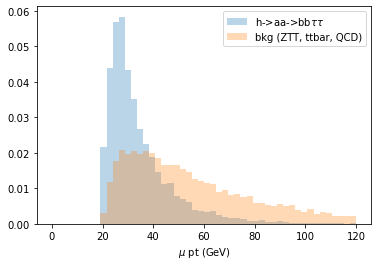

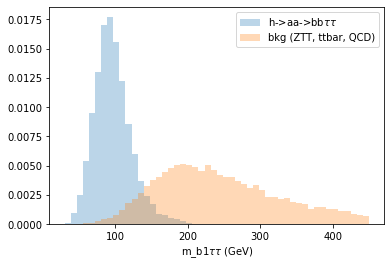

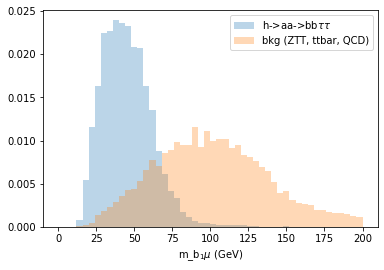

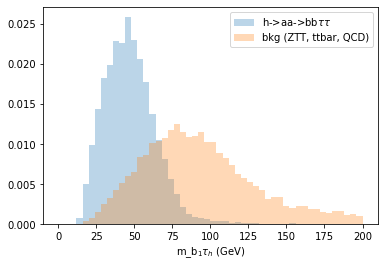

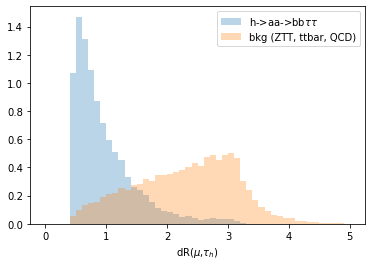

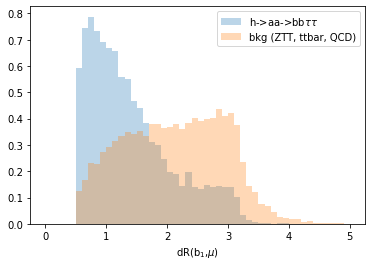

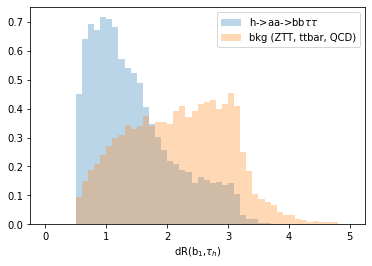

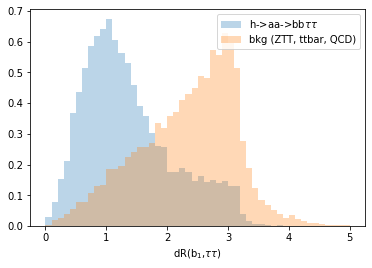

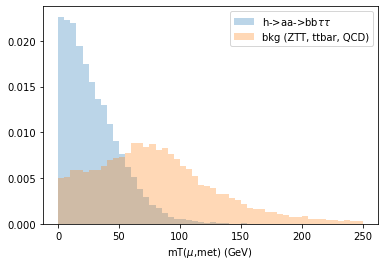

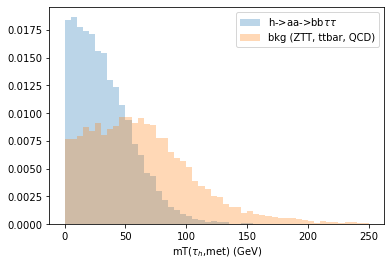

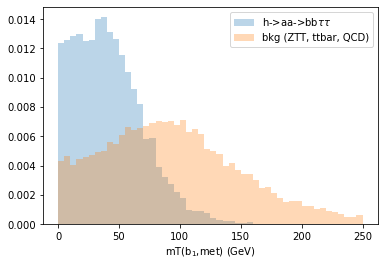

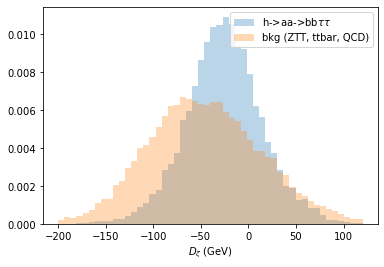

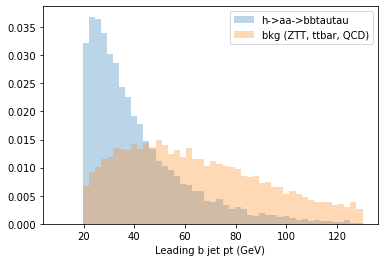

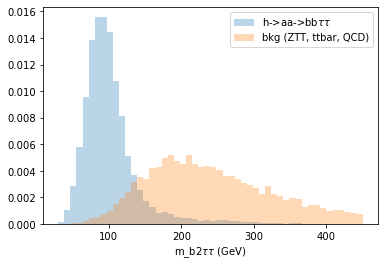

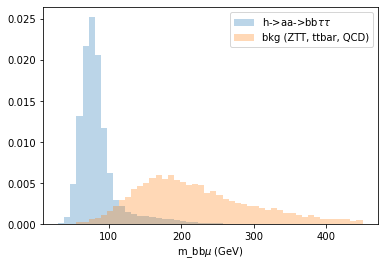

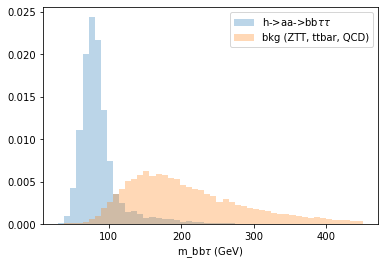

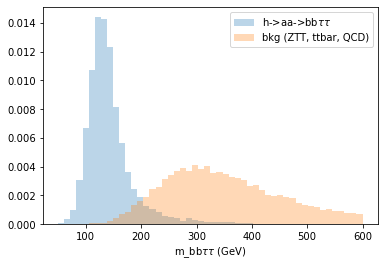

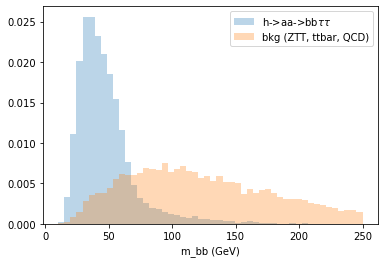

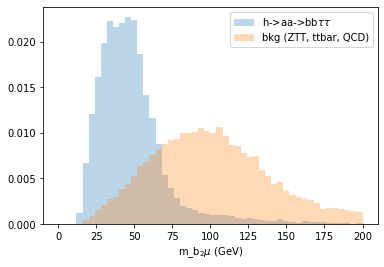

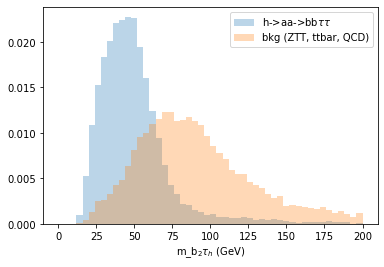

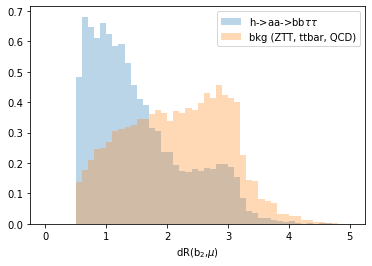

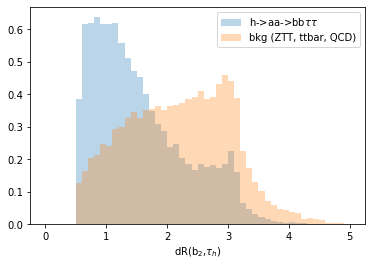

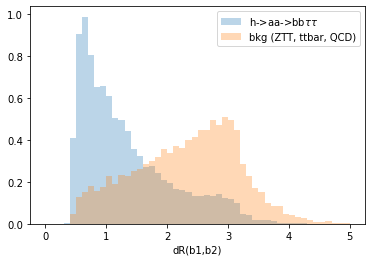

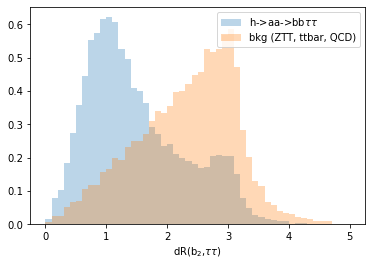

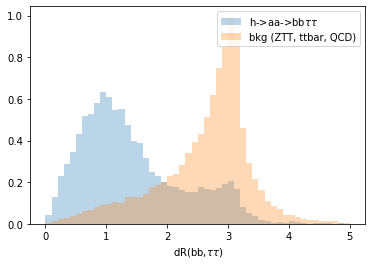

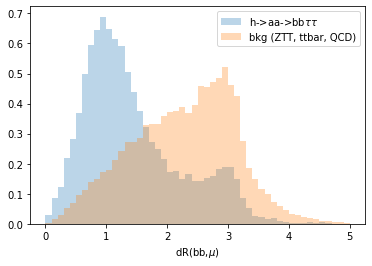

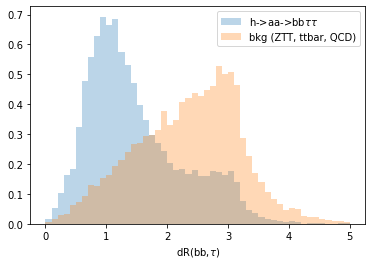

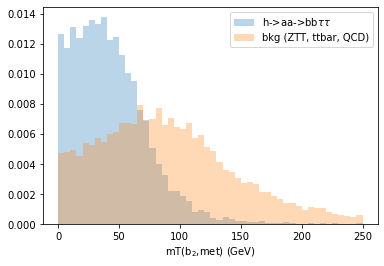

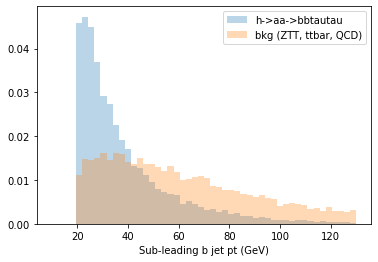

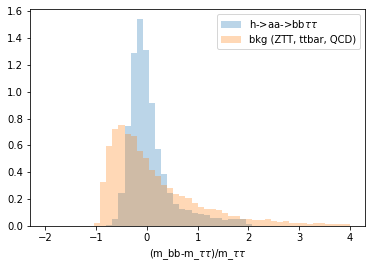

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

############## for 2b events
pyplot.hist(sig_allyears['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()




pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.50/0.25/0.25
X_train.shape: (12862, 30)
Y_train.shape: (12862, 1)
X_val.shape: (6431, 30)
Y_val.shape: (6431, 1)
X_test.shape: (6431, 30)
Y_test.shape: (6431, 1)

Total number of sig/bkg examples: 12862/12862 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 6522/6340 (50.7%/49.3%)
val   : 3208/3223 (49.9%/50.1%)
test  : 3132/3299 (48.7%/51.3%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 30,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-04-11 21:30:36.294027: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-11 21:30:36.294426: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 30, validation_data = (X_val,Y_val), batch_size = 128)

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 1:05 - loss: 0.6807 - accuracy: 0.61 - ETA: 6s - loss: 0.6037 - accuracy: 0.7094 - ETA: 3s - loss: 0.5176 - accuracy: 0.78 - ETA: 2s - loss: 0.4583 - accuracy: 0.82 - ETA: 1s - loss: 0.3989 - accuracy: 0.85 - ETA: 1s - loss: 0.3584 - accuracy: 0.86 - ETA: 0s - loss: 0.3292 - accuracy: 0.88 - ETA: 0s - loss: 0.3053 - accuracy: 0.89 - ETA: 0s - loss: 0.2849 - accuracy: 0.89 - ETA: 0s - loss: 0.2707 - accuracy: 0.90 - ETA: 0s - loss: 0.2556 - accuracy: 0.90 - 1s 115us/sample - loss: 0.2431 - accuracy: 0.9134 - val_loss: 0.0984 - val_accuracy: 0.9638
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.0933 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 53s - loss: 0.7932 - accuracy: 0.500 - ETA: 4s - loss: 0.6791 - accuracy: 0.611 - ETA: 2s - loss: 0.6113 - accuracy: 0.66 - ETA: 1s - loss: 0.5494 - accuracy: 0.71 - ETA: 1s - loss: 0.4990 - accuracy: 0.75 - ETA: 0s - loss: 0.4575 - accuracy: 0.77 - ETA: 0s - loss: 0.4226 - accuracy: 0.80 - ETA: 0s - loss: 0.3962 - accuracy: 0.81 - ETA: 0s - loss: 0.3694 - accuracy: 0.83 - ETA: 0s - loss: 0.3502 - accuracy: 0.84 - 1s 100us/sample - loss: 0.3326 - accuracy: 0.8528 - val_loss: 0.1247 - val_accuracy: 0.9529
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.96 - ETA: 0s - loss: 0.1841 - accuracy: 0.93 - ETA: 0s - loss: 0.1648 - accuracy: 0.94 - ETA: 0s - loss: 0.1558 - accuracy: 0.94 - ETA: 0s - loss: 0.1595 - accuracy: 0.94 - ETA: 0s - loss: 0.1547 - accuracy: 0.94 - ETA: 0s - loss: 0.1514 - accuracy: 0.94 - ETA: 0s - loss: 0.1510 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6986 - accuracy: 0.531 - ETA: 4s - loss: 0.6059 - accuracy: 0.632 - ETA: 2s - loss: 0.5258 - accuracy: 0.73 - ETA: 1s - loss: 0.4670 - accuracy: 0.78 - ETA: 1s - loss: 0.4126 - accuracy: 0.82 - ETA: 0s - loss: 0.3742 - accuracy: 0.84 - ETA: 0s - loss: 0.3437 - accuracy: 0.85 - ETA: 0s - loss: 0.3196 - accuracy: 0.86 - ETA: 0s - loss: 0.2996 - accuracy: 0.87 - ETA: 0s - loss: 0.2799 - accuracy: 0.88 - ETA: 0s - loss: 0.2650 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2553 - accuracy: 0.8959 - val_loss: 0.0989 - val_accuracy: 0.9594
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6985 - accuracy: 0.570 - ETA: 5s - loss: 0.5795 - accuracy: 0.712 - ETA: 2s - loss: 0.4961 - accuracy: 0.77 - ETA: 1s - loss: 0.4301 - accuracy: 0.82 - ETA: 1s - loss: 0.3798 - accuracy: 0.84 - ETA: 0s - loss: 0.3441 - accuracy: 0.86 - ETA: 0s - loss: 0.3181 - accuracy: 0.87 - ETA: 0s - loss: 0.2967 - accuracy: 0.88 - ETA: 0s - loss: 0.2786 - accuracy: 0.89 - ETA: 0s - loss: 0.2630 - accuracy: 0.89 - ETA: 0s - loss: 0.2478 - accuracy: 0.90 - ETA: 0s - loss: 0.2371 - accuracy: 0.90 - 1s 103us/sample - loss: 0.2358 - accuracy: 0.9095 - val_loss: 0.0935 - val_accuracy: 0.9641
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.96 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6840 - accuracy: 0.625 - ETA: 4s - loss: 0.5874 - accuracy: 0.659 - ETA: 2s - loss: 0.5091 - accuracy: 0.74 - ETA: 1s - loss: 0.4539 - accuracy: 0.79 - ETA: 1s - loss: 0.4103 - accuracy: 0.82 - ETA: 0s - loss: 0.3726 - accuracy: 0.84 - ETA: 0s - loss: 0.3409 - accuracy: 0.85 - ETA: 0s - loss: 0.3115 - accuracy: 0.87 - ETA: 0s - loss: 0.2912 - accuracy: 0.88 - ETA: 0s - loss: 0.2739 - accuracy: 0.89 - ETA: 0s - loss: 0.2585 - accuracy: 0.89 - 1s 99us/sample - loss: 0.2560 - accuracy: 0.8976 - val_loss: 0.1024 - val_accuracy: 0.9607
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.96 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 48s - loss: 0.7566 - accuracy: 0.468 - ETA: 3s - loss: 0.5822 - accuracy: 0.668 - ETA: 2s - loss: 0.5019 - accuracy: 0.74 - ETA: 1s - loss: 0.4437 - accuracy: 0.79 - ETA: 1s - loss: 0.3895 - accuracy: 0.82 - ETA: 0s - loss: 0.3489 - accuracy: 0.85 - ETA: 0s - loss: 0.3211 - accuracy: 0.86 - ETA: 0s - loss: 0.2944 - accuracy: 0.88 - ETA: 0s - loss: 0.2751 - accuracy: 0.88 - ETA: 0s - loss: 0.2585 - accuracy: 0.89 - ETA: 0s - loss: 0.2455 - accuracy: 0.90 - 1s 97us/sample - loss: 0.2446 - accuracy: 0.9027 - val_loss: 0.1019 - val_accuracy: 0.9599
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.7133 - accuracy: 0.609 - ETA: 4s - loss: 0.5880 - accuracy: 0.676 - ETA: 2s - loss: 0.5027 - accuracy: 0.75 - ETA: 1s - loss: 0.4396 - accuracy: 0.79 - ETA: 1s - loss: 0.3909 - accuracy: 0.82 - ETA: 0s - loss: 0.3504 - accuracy: 0.84 - ETA: 0s - loss: 0.3242 - accuracy: 0.86 - ETA: 0s - loss: 0.3014 - accuracy: 0.87 - ETA: 0s - loss: 0.2869 - accuracy: 0.88 - ETA: 0s - loss: 0.2714 - accuracy: 0.88 - ETA: 0s - loss: 0.2575 - accuracy: 0.89 - 1s 99us/sample - loss: 0.2561 - accuracy: 0.8951 - val_loss: 0.1080 - val_accuracy: 0.9580
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.96 - ETA: 0s - loss: 0.1465 - accuracy: 0.94 - ETA: 0s - loss: 0.1369 - accuracy: 0.94 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.8266 - accuracy: 0.421 - ETA: 4s - loss: 0.6744 - accuracy: 0.589 - ETA: 2s - loss: 0.5634 - accuracy: 0.70 - ETA: 1s - loss: 0.4928 - accuracy: 0.75 - ETA: 1s - loss: 0.4250 - accuracy: 0.80 - ETA: 0s - loss: 0.3837 - accuracy: 0.83 - ETA: 0s - loss: 0.3525 - accuracy: 0.84 - ETA: 0s - loss: 0.3260 - accuracy: 0.86 - ETA: 0s - loss: 0.3063 - accuracy: 0.87 - ETA: 0s - loss: 0.2872 - accuracy: 0.87 - ETA: 0s - loss: 0.2711 - accuracy: 0.88 - ETA: 0s - loss: 0.2570 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2548 - accuracy: 0.8950 - val_loss: 0.0969 - val_accuracy: 0.9635
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.96 - ETA: 0s - loss: 0.0965 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.7343 - accuracy: 0.507 - ETA: 5s - loss: 0.5913 - accuracy: 0.697 - ETA: 2s - loss: 0.4965 - accuracy: 0.78 - ETA: 1s - loss: 0.4306 - accuracy: 0.83 - ETA: 1s - loss: 0.3840 - accuracy: 0.85 - ETA: 0s - loss: 0.3441 - accuracy: 0.87 - ETA: 0s - loss: 0.3135 - accuracy: 0.88 - ETA: 0s - loss: 0.2902 - accuracy: 0.89 - ETA: 0s - loss: 0.2724 - accuracy: 0.90 - ETA: 0s - loss: 0.2543 - accuracy: 0.90 - ETA: 0s - loss: 0.2390 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2316 - accuracy: 0.9159 - val_loss: 0.0920 - val_accuracy: 0.9661
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.96 - ETA: 0s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.95 - ETA: 0s - loss: 0.1099 - accuracy: 0.95 - ETA: 0s - loss: 0.1074 - accuracy: 0.95 - ETA: 0s - loss: 0.1055 - accuracy: 0.95 - ETA: 0s - loss: 0.1015 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.8177 - accuracy: 0.406 - ETA: 4s - loss: 0.6008 - accuracy: 0.669 - ETA: 2s - loss: 0.4872 - accuracy: 0.77 - ETA: 1s - loss: 0.4073 - accuracy: 0.83 - ETA: 1s - loss: 0.3571 - accuracy: 0.85 - ETA: 0s - loss: 0.3172 - accuracy: 0.87 - ETA: 0s - loss: 0.2891 - accuracy: 0.88 - ETA: 0s - loss: 0.2674 - accuracy: 0.89 - ETA: 0s - loss: 0.2485 - accuracy: 0.90 - ETA: 0s - loss: 0.2338 - accuracy: 0.90 - ETA: 0s - loss: 0.2194 - accuracy: 0.91 - ETA: 0s - loss: 0.2093 - accuracy: 0.91 - 1s 102us/sample - loss: 0.2089 - accuracy: 0.9187 - val_loss: 0.0904 - val_accuracy: 0.9649
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6807 - accuracy: 0.617 - ETA: 4s - loss: 0.5535 - accuracy: 0.703 - ETA: 2s - loss: 0.4518 - accuracy: 0.80 - ETA: 1s - loss: 0.3916 - accuracy: 0.84 - ETA: 1s - loss: 0.3401 - accuracy: 0.86 - ETA: 0s - loss: 0.3035 - accuracy: 0.88 - ETA: 0s - loss: 0.2758 - accuracy: 0.89 - ETA: 0s - loss: 0.2575 - accuracy: 0.90 - ETA: 0s - loss: 0.2397 - accuracy: 0.90 - ETA: 0s - loss: 0.2276 - accuracy: 0.91 - ETA: 0s - loss: 0.2159 - accuracy: 0.91 - ETA: 0s - loss: 0.2072 - accuracy: 0.92 - 1s 104us/sample - loss: 0.2031 - accuracy: 0.9241 - val_loss: 0.0903 - val_accuracy: 0.9667
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.97 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.0928 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0935 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6900 - accuracy: 0.515 - ETA: 5s - loss: 0.5442 - accuracy: 0.767 - ETA: 2s - loss: 0.4591 - accuracy: 0.82 - ETA: 1s - loss: 0.3888 - accuracy: 0.85 - ETA: 1s - loss: 0.3370 - accuracy: 0.88 - ETA: 0s - loss: 0.2964 - accuracy: 0.89 - ETA: 0s - loss: 0.2689 - accuracy: 0.90 - ETA: 0s - loss: 0.2493 - accuracy: 0.91 - ETA: 0s - loss: 0.2346 - accuracy: 0.91 - ETA: 0s - loss: 0.2198 - accuracy: 0.92 - ETA: 0s - loss: 0.2075 - accuracy: 0.92 - ETA: 0s - loss: 0.1990 - accuracy: 0.92 - 1s 104us/sample - loss: 0.1939 - accuracy: 0.9305 - val_loss: 0.0873 - val_accuracy: 0.9670
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.0935 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0907 - accuracy: 0.96 - ETA: 0s - loss: 0.0889 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.8125 - accuracy: 0.523 - ETA: 4s - loss: 0.5818 - accuracy: 0.690 - ETA: 2s - loss: 0.4739 - accuracy: 0.77 - ETA: 1s - loss: 0.4077 - accuracy: 0.82 - ETA: 1s - loss: 0.3575 - accuracy: 0.84 - ETA: 0s - loss: 0.3229 - accuracy: 0.86 - ETA: 0s - loss: 0.2935 - accuracy: 0.88 - ETA: 0s - loss: 0.2724 - accuracy: 0.89 - ETA: 0s - loss: 0.2563 - accuracy: 0.89 - ETA: 0s - loss: 0.2428 - accuracy: 0.90 - ETA: 0s - loss: 0.2309 - accuracy: 0.90 - 1s 99us/sample - loss: 0.2273 - accuracy: 0.9109 - val_loss: 0.0980 - val_accuracy: 0.9627
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.1140 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 51s - loss: 0.9260 - accuracy: 0.367 - ETA: 5s - loss: 0.7566 - accuracy: 0.524 - ETA: 2s - loss: 0.5978 - accuracy: 0.67 - ETA: 1s - loss: 0.4941 - accuracy: 0.76 - ETA: 1s - loss: 0.4169 - accuracy: 0.81 - ETA: 0s - loss: 0.3699 - accuracy: 0.83 - ETA: 0s - loss: 0.3317 - accuracy: 0.85 - ETA: 0s - loss: 0.3031 - accuracy: 0.87 - ETA: 0s - loss: 0.2830 - accuracy: 0.88 - ETA: 0s - loss: 0.2658 - accuracy: 0.88 - ETA: 0s - loss: 0.2504 - accuracy: 0.89 - ETA: 0s - loss: 0.2377 - accuracy: 0.90 - 1s 105us/sample - loss: 0.2368 - accuracy: 0.9031 - val_loss: 0.0884 - val_accuracy: 0.9653
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.0916 - accuracy: 0.96 - ETA: 0s - loss: 0.0868 - accuracy: 0.96 - ETA: 0s - loss: 0.0836 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6677 - accuracy: 0.507 - ETA: 4s - loss: 0.5823 - accuracy: 0.685 - ETA: 2s - loss: 0.5070 - accuracy: 0.76 - ETA: 1s - loss: 0.4569 - accuracy: 0.80 - ETA: 1s - loss: 0.4095 - accuracy: 0.83 - ETA: 0s - loss: 0.3710 - accuracy: 0.85 - ETA: 0s - loss: 0.3418 - accuracy: 0.86 - ETA: 0s - loss: 0.3162 - accuracy: 0.87 - ETA: 0s - loss: 0.2975 - accuracy: 0.88 - ETA: 0s - loss: 0.2830 - accuracy: 0.89 - ETA: 0s - loss: 0.2671 - accuracy: 0.89 - 1s 100us/sample - loss: 0.2614 - accuracy: 0.9017 - val_loss: 0.1122 - val_accuracy: 0.9555
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.96 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1292 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6442 - accuracy: 0.632 - ETA: 5s - loss: 0.4992 - accuracy: 0.782 - ETA: 2s - loss: 0.4215 - accuracy: 0.83 - ETA: 1s - loss: 0.3685 - accuracy: 0.86 - ETA: 1s - loss: 0.3231 - accuracy: 0.88 - ETA: 0s - loss: 0.2921 - accuracy: 0.89 - ETA: 0s - loss: 0.2665 - accuracy: 0.90 - ETA: 0s - loss: 0.2471 - accuracy: 0.91 - ETA: 0s - loss: 0.2294 - accuracy: 0.92 - ETA: 0s - loss: 0.2155 - accuracy: 0.92 - ETA: 0s - loss: 0.2042 - accuracy: 0.93 - 1s 100us/sample - loss: 0.1985 - accuracy: 0.9324 - val_loss: 0.0865 - val_accuracy: 0.9686
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.93 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0894 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6538 - accuracy: 0.656 - ETA: 4s - loss: 0.5542 - accuracy: 0.742 - ETA: 2s - loss: 0.4694 - accuracy: 0.81 - ETA: 1s - loss: 0.4090 - accuracy: 0.85 - ETA: 1s - loss: 0.3589 - accuracy: 0.87 - ETA: 0s - loss: 0.3230 - accuracy: 0.88 - ETA: 0s - loss: 0.2954 - accuracy: 0.89 - ETA: 0s - loss: 0.2738 - accuracy: 0.90 - ETA: 0s - loss: 0.2551 - accuracy: 0.91 - ETA: 0s - loss: 0.2423 - accuracy: 0.91 - ETA: 0s - loss: 0.2300 - accuracy: 0.91 - 1s 100us/sample - loss: 0.2256 - accuracy: 0.9216 - val_loss: 0.0932 - val_accuracy: 0.9624
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.96 - ETA: 0s - loss: 0.1173 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.0972 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.7508 - accuracy: 0.546 - ETA: 4s - loss: 0.6841 - accuracy: 0.570 - ETA: 2s - loss: 0.5739 - accuracy: 0.69 - ETA: 1s - loss: 0.4988 - accuracy: 0.75 - ETA: 1s - loss: 0.4347 - accuracy: 0.80 - ETA: 0s - loss: 0.3834 - accuracy: 0.83 - ETA: 0s - loss: 0.3488 - accuracy: 0.84 - ETA: 0s - loss: 0.3171 - accuracy: 0.86 - ETA: 0s - loss: 0.2902 - accuracy: 0.87 - ETA: 0s - loss: 0.2693 - accuracy: 0.88 - ETA: 0s - loss: 0.2532 - accuracy: 0.89 - 1s 99us/sample - loss: 0.2499 - accuracy: 0.8980 - val_loss: 0.0924 - val_accuracy: 0.9644
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.95 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0910 - accuracy: 0.97 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.8867 - accuracy: 0.523 - ETA: 4s - loss: 0.7055 - accuracy: 0.598 - ETA: 2s - loss: 0.6068 - accuracy: 0.67 - ETA: 1s - loss: 0.5266 - accuracy: 0.73 - ETA: 0s - loss: 0.4652 - accuracy: 0.77 - ETA: 0s - loss: 0.4187 - accuracy: 0.80 - ETA: 0s - loss: 0.3818 - accuracy: 0.82 - ETA: 0s - loss: 0.3571 - accuracy: 0.84 - ETA: 0s - loss: 0.3338 - accuracy: 0.85 - ETA: 0s - loss: 0.3135 - accuracy: 0.86 - 1s 98us/sample - loss: 0.2968 - accuracy: 0.8712 - val_loss: 0.1157 - val_accuracy: 0.9540
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.96 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6747 - accuracy: 0.601 - ETA: 4s - loss: 0.5579 - accuracy: 0.741 - ETA: 2s - loss: 0.4643 - accuracy: 0.81 - ETA: 1s - loss: 0.3896 - accuracy: 0.85 - ETA: 1s - loss: 0.3377 - accuracy: 0.87 - ETA: 0s - loss: 0.3023 - accuracy: 0.89 - ETA: 0s - loss: 0.2762 - accuracy: 0.90 - ETA: 0s - loss: 0.2522 - accuracy: 0.91 - ETA: 0s - loss: 0.2355 - accuracy: 0.91 - ETA: 0s - loss: 0.2205 - accuracy: 0.92 - ETA: 0s - loss: 0.2091 - accuracy: 0.92 - 1s 101us/sample - loss: 0.2025 - accuracy: 0.9296 - val_loss: 0.0867 - val_accuracy: 0.9692
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.99 - ETA: 0s - loss: 0.0873 - accuracy: 0.97 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0865 - accuracy: 0.97 - ETA: 0s - loss: 0.0931 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0893 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.7604 - accuracy: 0.500 - ETA: 4s - loss: 0.6339 - accuracy: 0.627 - ETA: 2s - loss: 0.5473 - accuracy: 0.71 - ETA: 1s - loss: 0.4817 - accuracy: 0.76 - ETA: 1s - loss: 0.4362 - accuracy: 0.80 - ETA: 0s - loss: 0.3951 - accuracy: 0.82 - ETA: 0s - loss: 0.3655 - accuracy: 0.84 - ETA: 0s - loss: 0.3364 - accuracy: 0.85 - ETA: 0s - loss: 0.3141 - accuracy: 0.86 - ETA: 0s - loss: 0.2939 - accuracy: 0.87 - 1s 97us/sample - loss: 0.2799 - accuracy: 0.8830 - val_loss: 0.1082 - val_accuracy: 0.9572
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - ETA: 0s - loss: 0.1436 - accuracy: 0.94 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1133 - accuracy: 0.96 - ETA: 0s - loss: 0.1123 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.8089 - accuracy: 0.468 - ETA: 4s - loss: 0.7365 - accuracy: 0.582 - ETA: 2s - loss: 0.6147 - accuracy: 0.69 - ETA: 1s - loss: 0.5267 - accuracy: 0.76 - ETA: 1s - loss: 0.4683 - accuracy: 0.79 - ETA: 0s - loss: 0.4178 - accuracy: 0.82 - ETA: 0s - loss: 0.3761 - accuracy: 0.84 - ETA: 0s - loss: 0.3432 - accuracy: 0.85 - ETA: 0s - loss: 0.3213 - accuracy: 0.87 - ETA: 0s - loss: 0.2991 - accuracy: 0.88 - ETA: 0s - loss: 0.2815 - accuracy: 0.88 - 1s 99us/sample - loss: 0.2808 - accuracy: 0.8889 - val_loss: 0.0943 - val_accuracy: 0.9641
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.96 - ETA: 0s - loss: 0.1187 - accuracy: 0.96 - ETA: 0s - loss: 0.1199 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.7121 - accuracy: 0.500 - ETA: 4s - loss: 0.5984 - accuracy: 0.687 - ETA: 2s - loss: 0.5327 - accuracy: 0.75 - ETA: 1s - loss: 0.4690 - accuracy: 0.80 - ETA: 1s - loss: 0.4193 - accuracy: 0.82 - ETA: 0s - loss: 0.3802 - accuracy: 0.84 - ETA: 0s - loss: 0.3541 - accuracy: 0.86 - ETA: 0s - loss: 0.3300 - accuracy: 0.87 - ETA: 0s - loss: 0.3093 - accuracy: 0.88 - ETA: 0s - loss: 0.2913 - accuracy: 0.88 - ETA: 0s - loss: 0.2759 - accuracy: 0.89 - 1s 98us/sample - loss: 0.2753 - accuracy: 0.8950 - val_loss: 0.1114 - val_accuracy: 0.9574
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.96 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.8036 - accuracy: 0.437 - ETA: 4s - loss: 0.7075 - accuracy: 0.537 - ETA: 2s - loss: 0.6406 - accuracy: 0.61 - ETA: 1s - loss: 0.5904 - accuracy: 0.67 - ETA: 1s - loss: 0.5438 - accuracy: 0.71 - ETA: 0s - loss: 0.5034 - accuracy: 0.75 - ETA: 0s - loss: 0.4666 - accuracy: 0.77 - ETA: 0s - loss: 0.4352 - accuracy: 0.79 - ETA: 0s - loss: 0.4067 - accuracy: 0.81 - ETA: 0s - loss: 0.3839 - accuracy: 0.82 - ETA: 0s - loss: 0.3623 - accuracy: 0.83 - 1s 100us/sample - loss: 0.3504 - accuracy: 0.8437 - val_loss: 0.1164 - val_accuracy: 0.9572
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.92 - ETA: 0s - loss: 0.1712 - accuracy: 0.93 - ETA: 0s - loss: 0.1645 - accuracy: 0.94 - ETA: 0s - loss: 0.1657 - accuracy: 0.94 - ETA: 0s - loss: 0.1641 - accuracy: 0.94 - ETA: 0s - loss: 0.1572 - accuracy: 0.94 - ETA: 0s - loss: 0.1537 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.5675 - accuracy: 0.773 - ETA: 4s - loss: 0.4791 - accuracy: 0.796 - ETA: 2s - loss: 0.4031 - accuracy: 0.84 - ETA: 1s - loss: 0.3512 - accuracy: 0.87 - ETA: 1s - loss: 0.3110 - accuracy: 0.88 - ETA: 0s - loss: 0.2805 - accuracy: 0.89 - ETA: 0s - loss: 0.2609 - accuracy: 0.90 - ETA: 0s - loss: 0.2442 - accuracy: 0.91 - ETA: 0s - loss: 0.2299 - accuracy: 0.91 - ETA: 0s - loss: 0.2187 - accuracy: 0.92 - ETA: 0s - loss: 0.2095 - accuracy: 0.92 - 1s 99us/sample - loss: 0.2081 - accuracy: 0.9261 - val_loss: 0.0933 - val_accuracy: 0.9645
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1099 - accuracy: 0.95 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.8627 - accuracy: 0.484 - ETA: 4s - loss: 0.6651 - accuracy: 0.572 - ETA: 2s - loss: 0.5735 - accuracy: 0.68 - ETA: 1s - loss: 0.5018 - accuracy: 0.75 - ETA: 1s - loss: 0.4425 - accuracy: 0.79 - ETA: 0s - loss: 0.3923 - accuracy: 0.82 - ETA: 0s - loss: 0.3529 - accuracy: 0.84 - ETA: 0s - loss: 0.3262 - accuracy: 0.85 - ETA: 0s - loss: 0.3045 - accuracy: 0.87 - ETA: 0s - loss: 0.2822 - accuracy: 0.88 - ETA: 0s - loss: 0.2671 - accuracy: 0.88 - 1s 102us/sample - loss: 0.2555 - accuracy: 0.8933 - val_loss: 0.0967 - val_accuracy: 0.9602
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6886 - accuracy: 0.609 - ETA: 4s - loss: 0.5897 - accuracy: 0.700 - ETA: 2s - loss: 0.5211 - accuracy: 0.76 - ETA: 1s - loss: 0.4598 - accuracy: 0.80 - ETA: 1s - loss: 0.4165 - accuracy: 0.82 - ETA: 0s - loss: 0.3813 - accuracy: 0.84 - ETA: 0s - loss: 0.3506 - accuracy: 0.86 - ETA: 0s - loss: 0.3261 - accuracy: 0.87 - ETA: 0s - loss: 0.3058 - accuracy: 0.88 - ETA: 0s - loss: 0.2893 - accuracy: 0.88 - ETA: 0s - loss: 0.2764 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2672 - accuracy: 0.8992 - val_loss: 0.1039 - val_accuracy: 0.9619
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.96 - ETA: 0s - loss: 0.1523 - accuracy: 0.95 - ETA: 0s - loss: 0.1427 - accuracy: 0.95 - ETA: 0s - loss: 0.1359 - accuracy: 0.95 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1273 - accuracy: 0.95 - ETA: 0s - loss: 0.1287 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 1.0841 - accuracy: 0.421 - ETA: 4s - loss: 0.7667 - accuracy: 0.583 - ETA: 2s - loss: 0.6334 - accuracy: 0.68 - ETA: 1s - loss: 0.5436 - accuracy: 0.74 - ETA: 1s - loss: 0.4775 - accuracy: 0.78 - ETA: 0s - loss: 0.4240 - accuracy: 0.81 - ETA: 0s - loss: 0.3828 - accuracy: 0.83 - ETA: 0s - loss: 0.3539 - accuracy: 0.85 - ETA: 0s - loss: 0.3311 - accuracy: 0.86 - ETA: 0s - loss: 0.3107 - accuracy: 0.87 - ETA: 0s - loss: 0.2944 - accuracy: 0.87 - 1s 102us/sample - loss: 0.2808 - accuracy: 0.8852 - val_loss: 0.1032 - val_accuracy: 0.9608
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1163 - accuracy: 0.96 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1196 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6684 - accuracy: 0.570 - ETA: 4s - loss: 0.5001 - accuracy: 0.757 - ETA: 2s - loss: 0.4312 - accuracy: 0.80 - ETA: 1s - loss: 0.3801 - accuracy: 0.83 - ETA: 1s - loss: 0.3417 - accuracy: 0.85 - ETA: 0s - loss: 0.3105 - accuracy: 0.87 - ETA: 0s - loss: 0.2875 - accuracy: 0.88 - ETA: 0s - loss: 0.2677 - accuracy: 0.89 - ETA: 0s - loss: 0.2526 - accuracy: 0.89 - ETA: 0s - loss: 0.2391 - accuracy: 0.90 - ETA: 0s - loss: 0.2271 - accuracy: 0.91 - ETA: 0s - loss: 0.2173 - accuracy: 0.91 - 1s 102us/sample - loss: 0.2168 - accuracy: 0.9149 - val_loss: 0.0942 - val_accuracy: 0.9650
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.99 - ETA: 0s - loss: 0.0913 - accuracy: 0.96 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.7204 - accuracy: 0.546 - ETA: 4s - loss: 0.5403 - accuracy: 0.744 - ETA: 2s - loss: 0.4370 - accuracy: 0.81 - ETA: 1s - loss: 0.3696 - accuracy: 0.85 - ETA: 1s - loss: 0.3272 - accuracy: 0.87 - ETA: 0s - loss: 0.2930 - accuracy: 0.88 - ETA: 0s - loss: 0.2734 - accuracy: 0.89 - ETA: 0s - loss: 0.2531 - accuracy: 0.90 - ETA: 0s - loss: 0.2377 - accuracy: 0.90 - ETA: 0s - loss: 0.2236 - accuracy: 0.91 - ETA: 0s - loss: 0.2127 - accuracy: 0.91 - ETA: 0s - loss: 0.2055 - accuracy: 0.92 - 1s 105us/sample - loss: 0.2023 - accuracy: 0.9214 - val_loss: 0.0914 - val_accuracy: 0.9656
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.95 - ETA: 0s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6747 - accuracy: 0.585 - ETA: 4s - loss: 0.5245 - accuracy: 0.755 - ETA: 2s - loss: 0.4529 - accuracy: 0.81 - ETA: 1s - loss: 0.4000 - accuracy: 0.84 - ETA: 1s - loss: 0.3605 - accuracy: 0.86 - ETA: 0s - loss: 0.3255 - accuracy: 0.87 - ETA: 0s - loss: 0.2986 - accuracy: 0.88 - ETA: 0s - loss: 0.2797 - accuracy: 0.89 - ETA: 0s - loss: 0.2610 - accuracy: 0.90 - ETA: 0s - loss: 0.2472 - accuracy: 0.90 - ETA: 0s - loss: 0.2345 - accuracy: 0.91 - 1s 99us/sample - loss: 0.2317 - accuracy: 0.9148 - val_loss: 0.0995 - val_accuracy: 0.9616
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.94 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.95 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.95 - ETA: 0s - loss: 0.1074 - accuracy: 0.95 - ETA: 0s - loss: 0.1033 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.7897 - accuracy: 0.421 - ETA: 4s - loss: 0.6481 - accuracy: 0.610 - ETA: 2s - loss: 0.5370 - accuracy: 0.73 - ETA: 1s - loss: 0.4657 - accuracy: 0.78 - ETA: 1s - loss: 0.4162 - accuracy: 0.82 - ETA: 0s - loss: 0.3778 - accuracy: 0.84 - ETA: 0s - loss: 0.3435 - accuracy: 0.85 - ETA: 0s - loss: 0.3189 - accuracy: 0.87 - ETA: 0s - loss: 0.2960 - accuracy: 0.88 - ETA: 0s - loss: 0.2787 - accuracy: 0.88 - ETA: 0s - loss: 0.2639 - accuracy: 0.89 - ETA: 0s - loss: 0.2528 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2508 - accuracy: 0.9001 - val_loss: 0.0992 - val_accuracy: 0.9635
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1155 - accuracy: 0.96 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.7973 - accuracy: 0.476 - ETA: 4s - loss: 0.6109 - accuracy: 0.694 - ETA: 2s - loss: 0.5228 - accuracy: 0.76 - ETA: 1s - loss: 0.4483 - accuracy: 0.81 - ETA: 1s - loss: 0.3931 - accuracy: 0.84 - ETA: 0s - loss: 0.3548 - accuracy: 0.86 - ETA: 0s - loss: 0.3242 - accuracy: 0.87 - ETA: 0s - loss: 0.2972 - accuracy: 0.88 - ETA: 0s - loss: 0.2760 - accuracy: 0.89 - ETA: 0s - loss: 0.2602 - accuracy: 0.90 - ETA: 0s - loss: 0.2471 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2382 - accuracy: 0.9125 - val_loss: 0.0947 - val_accuracy: 0.9658
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1035 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8628 - accuracy: 0.328 - ETA: 4s - loss: 0.6648 - accuracy: 0.598 - ETA: 2s - loss: 0.5874 - accuracy: 0.68 - ETA: 1s - loss: 0.5237 - accuracy: 0.73 - ETA: 1s - loss: 0.4775 - accuracy: 0.77 - ETA: 0s - loss: 0.4356 - accuracy: 0.79 - ETA: 0s - loss: 0.4026 - accuracy: 0.81 - ETA: 0s - loss: 0.3743 - accuracy: 0.83 - ETA: 0s - loss: 0.3530 - accuracy: 0.84 - ETA: 0s - loss: 0.3304 - accuracy: 0.85 - ETA: 0s - loss: 0.3144 - accuracy: 0.86 - 1s 101us/sample - loss: 0.3046 - accuracy: 0.8704 - val_loss: 0.1077 - val_accuracy: 0.9583
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.92 - ETA: 0s - loss: 0.1461 - accuracy: 0.94 - ETA: 0s - loss: 0.1447 - accuracy: 0.95 - ETA: 0s - loss: 0.1421 - accuracy: 0.94 - ETA: 0s - loss: 0.1386 - accuracy: 0.95 - ETA: 0s - loss: 0.1349 - accuracy: 0.95 - ETA: 0s - loss: 0.1358 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6633 - accuracy: 0.593 - ETA: 5s - loss: 0.5087 - accuracy: 0.782 - ETA: 2s - loss: 0.4246 - accuracy: 0.83 - ETA: 1s - loss: 0.3612 - accuracy: 0.86 - ETA: 1s - loss: 0.3170 - accuracy: 0.88 - ETA: 0s - loss: 0.2886 - accuracy: 0.89 - ETA: 0s - loss: 0.2605 - accuracy: 0.90 - ETA: 0s - loss: 0.2416 - accuracy: 0.91 - ETA: 0s - loss: 0.2250 - accuracy: 0.91 - ETA: 0s - loss: 0.2119 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.92 - ETA: 0s - loss: 0.1932 - accuracy: 0.93 - 1s 105us/sample - loss: 0.1885 - accuracy: 0.9320 - val_loss: 0.0861 - val_accuracy: 0.9695
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.97 - ETA: 0s - loss: 0.0860 - accuracy: 0.97 - ETA: 0s - loss: 0.0865 - accuracy: 0.97 - ETA: 0s - loss: 0.0868 - accuracy: 0.96 - ETA: 0s - loss: 0.0865 - accuracy: 0.96 - ETA: 0s - loss: 0.0833 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6577 - accuracy: 0.578 - ETA: 4s - loss: 0.5236 - accuracy: 0.780 - ETA: 2s - loss: 0.4377 - accuracy: 0.84 - ETA: 1s - loss: 0.3772 - accuracy: 0.87 - ETA: 1s - loss: 0.3379 - accuracy: 0.88 - ETA: 0s - loss: 0.3028 - accuracy: 0.89 - ETA: 0s - loss: 0.2768 - accuracy: 0.90 - ETA: 0s - loss: 0.2534 - accuracy: 0.91 - ETA: 0s - loss: 0.2370 - accuracy: 0.91 - ETA: 0s - loss: 0.2240 - accuracy: 0.92 - ETA: 0s - loss: 0.2127 - accuracy: 0.92 - ETA: 0s - loss: 0.2041 - accuracy: 0.92 - 1s 102us/sample - loss: 0.2036 - accuracy: 0.9285 - val_loss: 0.0877 - val_accuracy: 0.9687
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 49s - loss: 0.7016 - accuracy: 0.562 - ETA: 4s - loss: 0.5383 - accuracy: 0.739 - ETA: 2s - loss: 0.4459 - accuracy: 0.81 - ETA: 1s - loss: 0.3827 - accuracy: 0.84 - ETA: 1s - loss: 0.3386 - accuracy: 0.87 - ETA: 0s - loss: 0.3019 - accuracy: 0.88 - ETA: 0s - loss: 0.2731 - accuracy: 0.89 - ETA: 0s - loss: 0.2493 - accuracy: 0.90 - ETA: 0s - loss: 0.2346 - accuracy: 0.91 - ETA: 0s - loss: 0.2221 - accuracy: 0.91 - ETA: 0s - loss: 0.2105 - accuracy: 0.92 - 1s 102us/sample - loss: 0.2018 - accuracy: 0.9258 - val_loss: 0.0874 - val_accuracy: 0.9666
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.95 - ETA: 0s - loss: 0.1042 - accuracy: 0.95 - ETA: 0s - loss: 0.1015 - accuracy: 0.95 - ETA: 0s - loss: 0.0972 - accuracy: 0.95 - ETA: 0s - loss: 0.1008 - accuracy: 0.95 - ETA: 0s - loss: 0.0997 - accuracy: 0.95 - ETA: 0s - loss: 0.0975 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7251 - accuracy: 0.515 - ETA: 4s - loss: 0.5768 - accuracy: 0.698 - ETA: 2s - loss: 0.4799 - accuracy: 0.78 - ETA: 1s - loss: 0.4136 - accuracy: 0.82 - ETA: 1s - loss: 0.3713 - accuracy: 0.85 - ETA: 0s - loss: 0.3352 - accuracy: 0.86 - ETA: 0s - loss: 0.3066 - accuracy: 0.88 - ETA: 0s - loss: 0.2841 - accuracy: 0.89 - ETA: 0s - loss: 0.2627 - accuracy: 0.89 - ETA: 0s - loss: 0.2489 - accuracy: 0.90 - ETA: 0s - loss: 0.2358 - accuracy: 0.91 - 1s 98us/sample - loss: 0.2352 - accuracy: 0.9103 - val_loss: 0.1005 - val_accuracy: 0.9622
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.96 - ETA: 0s - loss: 0.1203 - accuracy: 0.96 - ETA: 0s - loss: 0.1156 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1059 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 49s - loss: 0.8101 - accuracy: 0.398 - ETA: 4s - loss: 0.6406 - accuracy: 0.644 - ETA: 2s - loss: 0.5496 - accuracy: 0.73 - ETA: 1s - loss: 0.4702 - accuracy: 0.78 - ETA: 1s - loss: 0.4250 - accuracy: 0.81 - ETA: 0s - loss: 0.3801 - accuracy: 0.83 - ETA: 0s - loss: 0.3461 - accuracy: 0.85 - ETA: 0s - loss: 0.3198 - accuracy: 0.86 - ETA: 0s - loss: 0.2960 - accuracy: 0.87 - ETA: 0s - loss: 0.2794 - accuracy: 0.88 - ETA: 0s - loss: 0.2640 - accuracy: 0.89 - ETA: 0s - loss: 0.2483 - accuracy: 0.90 - 1s 104us/sample - loss: 0.2441 - accuracy: 0.9024 - val_loss: 0.0949 - val_accuracy: 0.9635
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.97 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1073 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6845 - accuracy: 0.609 - ETA: 4s - loss: 0.4974 - accuracy: 0.763 - ETA: 2s - loss: 0.4092 - accuracy: 0.82 - ETA: 1s - loss: 0.3461 - accuracy: 0.86 - ETA: 1s - loss: 0.3150 - accuracy: 0.87 - ETA: 0s - loss: 0.2868 - accuracy: 0.88 - ETA: 0s - loss: 0.2669 - accuracy: 0.89 - ETA: 0s - loss: 0.2470 - accuracy: 0.90 - ETA: 0s - loss: 0.2327 - accuracy: 0.91 - ETA: 0s - loss: 0.2201 - accuracy: 0.91 - ETA: 0s - loss: 0.2095 - accuracy: 0.92 - 1s 101us/sample - loss: 0.2055 - accuracy: 0.9215 - val_loss: 0.0926 - val_accuracy: 0.9649
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1062 - accuracy: 0.95 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6299 - accuracy: 0.656 - ETA: 4s - loss: 0.5182 - accuracy: 0.770 - ETA: 2s - loss: 0.4113 - accuracy: 0.83 - ETA: 1s - loss: 0.3500 - accuracy: 0.86 - ETA: 1s - loss: 0.3077 - accuracy: 0.88 - ETA: 0s - loss: 0.2750 - accuracy: 0.89 - ETA: 0s - loss: 0.2520 - accuracy: 0.90 - ETA: 0s - loss: 0.2357 - accuracy: 0.91 - ETA: 0s - loss: 0.2222 - accuracy: 0.92 - ETA: 0s - loss: 0.2098 - accuracy: 0.92 - ETA: 0s - loss: 0.1996 - accuracy: 0.92 - 1s 100us/sample - loss: 0.1982 - accuracy: 0.9284 - val_loss: 0.0922 - val_accuracy: 0.9653
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.94 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.0972 - accuracy: 0.96 - ETA: 0s - loss: 0.0972 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7041 - accuracy: 0.625 - ETA: 4s - loss: 0.5712 - accuracy: 0.725 - ETA: 2s - loss: 0.4966 - accuracy: 0.78 - ETA: 1s - loss: 0.4264 - accuracy: 0.82 - ETA: 1s - loss: 0.3788 - accuracy: 0.85 - ETA: 0s - loss: 0.3475 - accuracy: 0.86 - ETA: 0s - loss: 0.3184 - accuracy: 0.87 - ETA: 0s - loss: 0.2952 - accuracy: 0.88 - ETA: 0s - loss: 0.2797 - accuracy: 0.89 - ETA: 0s - loss: 0.2629 - accuracy: 0.90 - ETA: 0s - loss: 0.2500 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2465 - accuracy: 0.9083 - val_loss: 0.0947 - val_accuracy: 0.9653
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.94 - ETA: 0s - loss: 0.1337 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.94 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6871 - accuracy: 0.601 - ETA: 4s - loss: 0.5915 - accuracy: 0.718 - ETA: 2s - loss: 0.5076 - accuracy: 0.79 - ETA: 1s - loss: 0.4446 - accuracy: 0.83 - ETA: 1s - loss: 0.3954 - accuracy: 0.85 - ETA: 0s - loss: 0.3546 - accuracy: 0.87 - ETA: 0s - loss: 0.3193 - accuracy: 0.88 - ETA: 0s - loss: 0.2957 - accuracy: 0.89 - ETA: 0s - loss: 0.2742 - accuracy: 0.90 - ETA: 0s - loss: 0.2598 - accuracy: 0.90 - ETA: 0s - loss: 0.2468 - accuracy: 0.91 - 1s 100us/sample - loss: 0.2424 - accuracy: 0.9141 - val_loss: 0.0998 - val_accuracy: 0.9650
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.94 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1070 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 49s - loss: 0.7064 - accuracy: 0.570 - ETA: 4s - loss: 0.5608 - accuracy: 0.704 - ETA: 2s - loss: 0.4731 - accuracy: 0.78 - ETA: 1s - loss: 0.4125 - accuracy: 0.82 - ETA: 1s - loss: 0.3707 - accuracy: 0.84 - ETA: 0s - loss: 0.3360 - accuracy: 0.86 - ETA: 0s - loss: 0.3097 - accuracy: 0.87 - ETA: 0s - loss: 0.2835 - accuracy: 0.88 - ETA: 0s - loss: 0.2645 - accuracy: 0.89 - ETA: 0s - loss: 0.2508 - accuracy: 0.90 - ETA: 0s - loss: 0.2386 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2334 - accuracy: 0.9103 - val_loss: 0.0991 - val_accuracy: 0.9622
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.97 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.0965 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6235 - accuracy: 0.554 - ETA: 5s - loss: 0.5290 - accuracy: 0.722 - ETA: 2s - loss: 0.4595 - accuracy: 0.79 - ETA: 1s - loss: 0.3954 - accuracy: 0.83 - ETA: 1s - loss: 0.3450 - accuracy: 0.86 - ETA: 0s - loss: 0.3117 - accuracy: 0.87 - ETA: 0s - loss: 0.2834 - accuracy: 0.89 - ETA: 0s - loss: 0.2635 - accuracy: 0.89 - ETA: 0s - loss: 0.2483 - accuracy: 0.90 - ETA: 0s - loss: 0.2363 - accuracy: 0.91 - ETA: 0s - loss: 0.2234 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2180 - accuracy: 0.9177 - val_loss: 0.0940 - val_accuracy: 0.9649
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.94 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7997 - accuracy: 0.382 - ETA: 5s - loss: 0.6508 - accuracy: 0.586 - ETA: 2s - loss: 0.5524 - accuracy: 0.70 - ETA: 1s - loss: 0.4835 - accuracy: 0.77 - ETA: 1s - loss: 0.4255 - accuracy: 0.80 - ETA: 0s - loss: 0.3875 - accuracy: 0.83 - ETA: 0s - loss: 0.3537 - accuracy: 0.84 - ETA: 0s - loss: 0.3272 - accuracy: 0.86 - ETA: 0s - loss: 0.3038 - accuracy: 0.87 - ETA: 0s - loss: 0.2850 - accuracy: 0.88 - ETA: 0s - loss: 0.2696 - accuracy: 0.88 - ETA: 0s - loss: 0.2571 - accuracy: 0.89 - 1s 104us/sample - loss: 0.2562 - accuracy: 0.8947 - val_loss: 0.0993 - val_accuracy: 0.9631
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.96 - ETA: 0s - loss: 0.1304 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7779 - accuracy: 0.390 - ETA: 4s - loss: 0.6142 - accuracy: 0.646 - ETA: 2s - loss: 0.5196 - accuracy: 0.75 - ETA: 1s - loss: 0.4404 - accuracy: 0.81 - ETA: 1s - loss: 0.3918 - accuracy: 0.84 - ETA: 0s - loss: 0.3478 - accuracy: 0.86 - ETA: 0s - loss: 0.3172 - accuracy: 0.87 - ETA: 0s - loss: 0.2866 - accuracy: 0.88 - ETA: 0s - loss: 0.2660 - accuracy: 0.89 - ETA: 0s - loss: 0.2503 - accuracy: 0.90 - ETA: 0s - loss: 0.2365 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2313 - accuracy: 0.9114 - val_loss: 0.0939 - val_accuracy: 0.9641
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 1.00 - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.0796 - accuracy: 0.97 - ETA: 0s - loss: 0.0877 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0922 - accuracy: 0.96 - ETA: 0s - loss: 0.0895 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7739 - accuracy: 0.554 - ETA: 4s - loss: 0.6695 - accuracy: 0.625 - ETA: 2s - loss: 0.5727 - accuracy: 0.71 - ETA: 1s - loss: 0.4980 - accuracy: 0.77 - ETA: 1s - loss: 0.4475 - accuracy: 0.80 - ETA: 0s - loss: 0.4100 - accuracy: 0.82 - ETA: 0s - loss: 0.3744 - accuracy: 0.84 - ETA: 0s - loss: 0.3454 - accuracy: 0.85 - ETA: 0s - loss: 0.3232 - accuracy: 0.86 - ETA: 0s - loss: 0.3031 - accuracy: 0.87 - ETA: 0s - loss: 0.2876 - accuracy: 0.88 - 1s 100us/sample - loss: 0.2814 - accuracy: 0.8887 - val_loss: 0.1031 - val_accuracy: 0.9636
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - ETA: 0s - loss: 0.1084 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1064 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7605 - accuracy: 0.453 - ETA: 4s - loss: 0.5800 - accuracy: 0.692 - ETA: 2s - loss: 0.4809 - accuracy: 0.78 - ETA: 1s - loss: 0.4064 - accuracy: 0.83 - ETA: 1s - loss: 0.3552 - accuracy: 0.86 - ETA: 0s - loss: 0.3184 - accuracy: 0.87 - ETA: 0s - loss: 0.2910 - accuracy: 0.88 - ETA: 0s - loss: 0.2687 - accuracy: 0.89 - ETA: 0s - loss: 0.2496 - accuracy: 0.90 - ETA: 0s - loss: 0.2350 - accuracy: 0.91 - ETA: 0s - loss: 0.2239 - accuracy: 0.91 - 1s 102us/sample - loss: 0.2150 - accuracy: 0.9205 - val_loss: 0.0883 - val_accuracy: 0.9669
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.92 - ETA: 0s - loss: 0.0995 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.95 - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0969 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.9484 - accuracy: 0.390 - ETA: 4s - loss: 0.6864 - accuracy: 0.602 - ETA: 2s - loss: 0.5622 - accuracy: 0.72 - ETA: 1s - loss: 0.4808 - accuracy: 0.78 - ETA: 0s - loss: 0.4140 - accuracy: 0.82 - ETA: 0s - loss: 0.3697 - accuracy: 0.84 - ETA: 0s - loss: 0.3426 - accuracy: 0.86 - ETA: 0s - loss: 0.3154 - accuracy: 0.87 - ETA: 0s - loss: 0.2922 - accuracy: 0.88 - ETA: 0s - loss: 0.2731 - accuracy: 0.89 - 1s 98us/sample - loss: 0.2576 - accuracy: 0.8995 - val_loss: 0.1027 - val_accuracy: 0.9611
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.94 - ETA: 0s - loss: 0.1237 - accuracy: 0.94 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - accuracy: 0.95 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6517 - accuracy: 0.648 - ETA: 5s - loss: 0.5161 - accuracy: 0.780 - ETA: 2s - loss: 0.4229 - accuracy: 0.84 - ETA: 1s - loss: 0.3614 - accuracy: 0.87 - ETA: 1s - loss: 0.3156 - accuracy: 0.88 - ETA: 0s - loss: 0.2852 - accuracy: 0.89 - ETA: 0s - loss: 0.2629 - accuracy: 0.90 - ETA: 0s - loss: 0.2426 - accuracy: 0.91 - ETA: 0s - loss: 0.2272 - accuracy: 0.91 - ETA: 0s - loss: 0.2127 - accuracy: 0.92 - ETA: 0s - loss: 0.2019 - accuracy: 0.92 - 1s 103us/sample - loss: 0.1935 - accuracy: 0.9300 - val_loss: 0.0864 - val_accuracy: 0.9666
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.93 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - ETA: 0s - loss: 0.1008 - accuracy: 0.95 - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8021 - accuracy: 0.476 - ETA: 4s - loss: 0.5651 - accuracy: 0.717 - ETA: 2s - loss: 0.4573 - accuracy: 0.80 - ETA: 1s - loss: 0.3820 - accuracy: 0.84 - ETA: 1s - loss: 0.3319 - accuracy: 0.87 - ETA: 0s - loss: 0.2999 - accuracy: 0.88 - ETA: 0s - loss: 0.2722 - accuracy: 0.89 - ETA: 0s - loss: 0.2490 - accuracy: 0.90 - ETA: 0s - loss: 0.2324 - accuracy: 0.91 - ETA: 0s - loss: 0.2175 - accuracy: 0.91 - ETA: 0s - loss: 0.2085 - accuracy: 0.92 - 1s 101us/sample - loss: 0.2033 - accuracy: 0.9238 - val_loss: 0.0867 - val_accuracy: 0.9659
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.92 - ETA: 0s - loss: 0.0884 - accuracy: 0.96 - ETA: 0s - loss: 0.0857 - accuracy: 0.96 - ETA: 0s - loss: 0.0931 - accuracy: 0.96 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0916 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.9000 - accuracy: 0.335 - ETA: 4s - loss: 0.7554 - accuracy: 0.497 - ETA: 2s - loss: 0.6563 - accuracy: 0.63 - ETA: 1s - loss: 0.5735 - accuracy: 0.72 - ETA: 0s - loss: 0.5188 - accuracy: 0.76 - ETA: 0s - loss: 0.4751 - accuracy: 0.79 - ETA: 0s - loss: 0.4316 - accuracy: 0.82 - ETA: 0s - loss: 0.4009 - accuracy: 0.83 - ETA: 0s - loss: 0.3726 - accuracy: 0.84 - ETA: 0s - loss: 0.3451 - accuracy: 0.86 - 1s 97us/sample - loss: 0.3270 - accuracy: 0.8682 - val_loss: 0.1149 - val_accuracy: 0.9603
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.95 - ETA: 0s - loss: 0.1352 - accuracy: 0.94 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - ETA: 0s - loss: 0.1337 - accuracy: 0.94 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 51s - loss: 0.7557 - accuracy: 0.492 - ETA: 5s - loss: 0.6238 - accuracy: 0.632 - ETA: 2s - loss: 0.5303 - accuracy: 0.72 - ETA: 1s - loss: 0.4548 - accuracy: 0.78 - ETA: 1s - loss: 0.4056 - accuracy: 0.81 - ETA: 1s - loss: 0.3702 - accuracy: 0.84 - ETA: 0s - loss: 0.3412 - accuracy: 0.85 - ETA: 0s - loss: 0.3148 - accuracy: 0.86 - ETA: 0s - loss: 0.2963 - accuracy: 0.87 - ETA: 0s - loss: 0.2765 - accuracy: 0.88 - ETA: 0s - loss: 0.2643 - accuracy: 0.89 - ETA: 0s - loss: 0.2499 - accuracy: 0.90 - 1s 107us/sample - loss: 0.2416 - accuracy: 0.9042 - val_loss: 0.0949 - val_accuracy: 0.9638
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.97 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7150 - accuracy: 0.523 - ETA: 4s - loss: 0.5752 - accuracy: 0.661 - ETA: 2s - loss: 0.5188 - accuracy: 0.73 - ETA: 1s - loss: 0.4580 - accuracy: 0.79 - ETA: 1s - loss: 0.4179 - accuracy: 0.82 - ETA: 0s - loss: 0.3835 - accuracy: 0.84 - ETA: 0s - loss: 0.3516 - accuracy: 0.85 - ETA: 0s - loss: 0.3240 - accuracy: 0.87 - ETA: 0s - loss: 0.3074 - accuracy: 0.87 - ETA: 0s - loss: 0.2926 - accuracy: 0.88 - ETA: 0s - loss: 0.2783 - accuracy: 0.89 - 1s 100us/sample - loss: 0.2712 - accuracy: 0.8953 - val_loss: 0.1078 - val_accuracy: 0.9602
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.93 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8359 - accuracy: 0.445 - ETA: 4s - loss: 0.6706 - accuracy: 0.617 - ETA: 2s - loss: 0.5827 - accuracy: 0.71 - ETA: 1s - loss: 0.5189 - accuracy: 0.76 - ETA: 1s - loss: 0.4600 - accuracy: 0.80 - ETA: 0s - loss: 0.4151 - accuracy: 0.82 - ETA: 0s - loss: 0.3788 - accuracy: 0.84 - ETA: 0s - loss: 0.3478 - accuracy: 0.86 - ETA: 0s - loss: 0.3214 - accuracy: 0.87 - ETA: 0s - loss: 0.3004 - accuracy: 0.88 - ETA: 0s - loss: 0.2849 - accuracy: 0.88 - 1s 99us/sample - loss: 0.2840 - accuracy: 0.8894 - val_loss: 0.0953 - val_accuracy: 0.9641
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.94 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.9025 - accuracy: 0.406 - ETA: 4s - loss: 0.7977 - accuracy: 0.434 - ETA: 2s - loss: 0.6841 - accuracy: 0.54 - ETA: 1s - loss: 0.6152 - accuracy: 0.62 - ETA: 0s - loss: 0.5548 - accuracy: 0.68 - ETA: 0s - loss: 0.5062 - accuracy: 0.73 - ETA: 0s - loss: 0.4638 - accuracy: 0.76 - ETA: 0s - loss: 0.4272 - accuracy: 0.78 - ETA: 0s - loss: 0.3993 - accuracy: 0.80 - ETA: 0s - loss: 0.3721 - accuracy: 0.82 - 1s 95us/sample - loss: 0.3661 - accuracy: 0.8246 - val_loss: 0.1227 - val_accuracy: 0.9555
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.96 - ETA: 0s - loss: 0.1643 - accuracy: 0.94 - ETA: 0s - loss: 0.1549 - accuracy: 0.94 - ETA: 0s - loss: 0.1441 - accuracy: 0.95 - ETA: 0s - loss: 0.1417 - accuracy: 0.95 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7217 - accuracy: 0.539 - ETA: 5s - loss: 0.5951 - accuracy: 0.696 - ETA: 2s - loss: 0.5242 - accuracy: 0.76 - ETA: 1s - loss: 0.4607 - accuracy: 0.81 - ETA: 1s - loss: 0.4137 - accuracy: 0.83 - ETA: 0s - loss: 0.3699 - accuracy: 0.86 - ETA: 0s - loss: 0.3374 - accuracy: 0.87 - ETA: 0s - loss: 0.3119 - accuracy: 0.88 - ETA: 0s - loss: 0.2931 - accuracy: 0.89 - ETA: 0s - loss: 0.2764 - accuracy: 0.89 - ETA: 0s - loss: 0.2614 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2552 - accuracy: 0.9049 - val_loss: 0.1075 - val_accuracy: 0.9580
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1070 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.1059 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7477 - accuracy: 0.609 - ETA: 5s - loss: 0.6427 - accuracy: 0.673 - ETA: 2s - loss: 0.5394 - accuracy: 0.75 - ETA: 1s - loss: 0.4639 - accuracy: 0.80 - ETA: 1s - loss: 0.4027 - accuracy: 0.84 - ETA: 0s - loss: 0.3599 - accuracy: 0.85 - ETA: 0s - loss: 0.3281 - accuracy: 0.87 - ETA: 0s - loss: 0.3055 - accuracy: 0.88 - ETA: 0s - loss: 0.2817 - accuracy: 0.89 - ETA: 0s - loss: 0.2646 - accuracy: 0.90 - ETA: 0s - loss: 0.2480 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2394 - accuracy: 0.9105 - val_loss: 0.0953 - val_accuracy: 0.9652
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.96 - ETA: 0s - loss: 0.1222 - accuracy: 0.96 - ETA: 0s - loss: 0.1178 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1125 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1116 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8799 - accuracy: 0.445 - ETA: 4s - loss: 0.6910 - accuracy: 0.602 - ETA: 2s - loss: 0.5886 - accuracy: 0.68 - ETA: 1s - loss: 0.5162 - accuracy: 0.74 - ETA: 1s - loss: 0.4588 - accuracy: 0.78 - ETA: 0s - loss: 0.4152 - accuracy: 0.81 - ETA: 0s - loss: 0.3799 - accuracy: 0.83 - ETA: 0s - loss: 0.3523 - accuracy: 0.84 - ETA: 0s - loss: 0.3298 - accuracy: 0.85 - ETA: 0s - loss: 0.3097 - accuracy: 0.86 - ETA: 0s - loss: 0.2925 - accuracy: 0.87 - 1s 99us/sample - loss: 0.2904 - accuracy: 0.8766 - val_loss: 0.1036 - val_accuracy: 0.9613
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1402 - accuracy: 0.95 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1203 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8511 - accuracy: 0.398 - ETA: 4s - loss: 0.6742 - accuracy: 0.595 - ETA: 2s - loss: 0.5881 - accuracy: 0.68 - ETA: 1s - loss: 0.5106 - accuracy: 0.74 - ETA: 1s - loss: 0.4521 - accuracy: 0.78 - ETA: 0s - loss: 0.4117 - accuracy: 0.81 - ETA: 0s - loss: 0.3777 - accuracy: 0.83 - ETA: 0s - loss: 0.3514 - accuracy: 0.84 - ETA: 0s - loss: 0.3301 - accuracy: 0.85 - ETA: 0s - loss: 0.3128 - accuracy: 0.86 - ETA: 0s - loss: 0.2932 - accuracy: 0.87 - 1s 100us/sample - loss: 0.2863 - accuracy: 0.8782 - val_loss: 0.1038 - val_accuracy: 0.9593
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.96 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7227 - accuracy: 0.562 - ETA: 4s - loss: 0.5883 - accuracy: 0.691 - ETA: 2s - loss: 0.5100 - accuracy: 0.76 - ETA: 1s - loss: 0.4560 - accuracy: 0.80 - ETA: 1s - loss: 0.4062 - accuracy: 0.83 - ETA: 0s - loss: 0.3700 - accuracy: 0.85 - ETA: 0s - loss: 0.3397 - accuracy: 0.86 - ETA: 0s - loss: 0.3173 - accuracy: 0.87 - ETA: 0s - loss: 0.2976 - accuracy: 0.88 - ETA: 0s - loss: 0.2788 - accuracy: 0.89 - ETA: 0s - loss: 0.2644 - accuracy: 0.89 - 1s 99us/sample - loss: 0.2642 - accuracy: 0.8995 - val_loss: 0.1025 - val_accuracy: 0.9588
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.93 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8935 - accuracy: 0.414 - ETA: 5s - loss: 0.6643 - accuracy: 0.617 - ETA: 2s - loss: 0.5457 - accuracy: 0.71 - ETA: 1s - loss: 0.4635 - accuracy: 0.78 - ETA: 1s - loss: 0.4000 - accuracy: 0.81 - ETA: 0s - loss: 0.3527 - accuracy: 0.84 - ETA: 0s - loss: 0.3223 - accuracy: 0.86 - ETA: 0s - loss: 0.2992 - accuracy: 0.87 - ETA: 0s - loss: 0.2766 - accuracy: 0.88 - ETA: 0s - loss: 0.2622 - accuracy: 0.89 - ETA: 0s - loss: 0.2491 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2416 - accuracy: 0.9011 - val_loss: 0.0975 - val_accuracy: 0.9652
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 49s - loss: 1.1341 - accuracy: 0.367 - ETA: 4s - loss: 0.9304 - accuracy: 0.460 - ETA: 2s - loss: 0.8296 - accuracy: 0.52 - ETA: 1s - loss: 0.7406 - accuracy: 0.58 - ETA: 1s - loss: 0.6770 - accuracy: 0.62 - ETA: 0s - loss: 0.6196 - accuracy: 0.67 - ETA: 0s - loss: 0.5722 - accuracy: 0.70 - ETA: 0s - loss: 0.5314 - accuracy: 0.73 - ETA: 0s - loss: 0.4930 - accuracy: 0.76 - ETA: 0s - loss: 0.4605 - accuracy: 0.78 - 1s 97us/sample - loss: 0.4428 - accuracy: 0.7918 - val_loss: 0.1444 - val_accuracy: 0.9504
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.89 - ETA: 0s - loss: 0.1964 - accuracy: 0.92 - ETA: 0s - loss: 0.1886 - accuracy: 0.93 - ETA: 0s - loss: 0.1820 - accuracy: 0.93 - ETA: 0s - loss: 0.1783 - accuracy: 0.93 - ETA: 0s - loss: 0.1736 - accuracy: 0.94 - ETA: 0s - loss: 0.1656 - accuracy: 0.94 - ETA: 0s - loss: 0.1613 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7230 - accuracy: 0.476 - ETA: 4s - loss: 0.5819 - accuracy: 0.696 - ETA: 2s - loss: 0.4983 - accuracy: 0.77 - ETA: 1s - loss: 0.4365 - accuracy: 0.81 - ETA: 1s - loss: 0.3802 - accuracy: 0.84 - ETA: 0s - loss: 0.3426 - accuracy: 0.86 - ETA: 0s - loss: 0.3099 - accuracy: 0.87 - ETA: 0s - loss: 0.2888 - accuracy: 0.88 - ETA: 0s - loss: 0.2714 - accuracy: 0.89 - ETA: 0s - loss: 0.2590 - accuracy: 0.89 - ETA: 0s - loss: 0.2457 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2378 - accuracy: 0.9076 - val_loss: 0.0950 - val_accuracy: 0.9636
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.97 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6642 - accuracy: 0.554 - ETA: 4s - loss: 0.5825 - accuracy: 0.670 - ETA: 2s - loss: 0.5122 - accuracy: 0.74 - ETA: 1s - loss: 0.4484 - accuracy: 0.79 - ETA: 0s - loss: 0.4045 - accuracy: 0.82 - ETA: 0s - loss: 0.3708 - accuracy: 0.84 - ETA: 0s - loss: 0.3398 - accuracy: 0.86 - ETA: 0s - loss: 0.3186 - accuracy: 0.87 - ETA: 0s - loss: 0.2987 - accuracy: 0.88 - ETA: 0s - loss: 0.2837 - accuracy: 0.88 - 1s 95us/sample - loss: 0.2796 - accuracy: 0.8894 - val_loss: 0.1121 - val_accuracy: 0.9575
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 0.94 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - ETA: 0s - loss: 0.1302 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 49s - loss: 0.6896 - accuracy: 0.515 - ETA: 4s - loss: 0.5654 - accuracy: 0.710 - ETA: 2s - loss: 0.4614 - accuracy: 0.79 - ETA: 1s - loss: 0.3949 - accuracy: 0.83 - ETA: 1s - loss: 0.3430 - accuracy: 0.86 - ETA: 0s - loss: 0.3090 - accuracy: 0.87 - ETA: 0s - loss: 0.2842 - accuracy: 0.89 - ETA: 0s - loss: 0.2606 - accuracy: 0.90 - ETA: 0s - loss: 0.2424 - accuracy: 0.90 - ETA: 0s - loss: 0.2279 - accuracy: 0.91 - ETA: 0s - loss: 0.2182 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2137 - accuracy: 0.9195 - val_loss: 0.0932 - val_accuracy: 0.9650
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.94 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0995 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8632 - accuracy: 0.460 - ETA: 5s - loss: 0.6752 - accuracy: 0.600 - ETA: 2s - loss: 0.5662 - accuracy: 0.71 - ETA: 1s - loss: 0.4884 - accuracy: 0.77 - ETA: 1s - loss: 0.4304 - accuracy: 0.80 - ETA: 0s - loss: 0.3851 - accuracy: 0.83 - ETA: 0s - loss: 0.3498 - accuracy: 0.85 - ETA: 0s - loss: 0.3230 - accuracy: 0.86 - ETA: 0s - loss: 0.3006 - accuracy: 0.87 - ETA: 0s - loss: 0.2829 - accuracy: 0.88 - ETA: 0s - loss: 0.2662 - accuracy: 0.88 - ETA: 0s - loss: 0.2538 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2534 - accuracy: 0.8957 - val_loss: 0.0946 - val_accuracy: 0.9633
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.9783 - accuracy: 0.351 - ETA: 4s - loss: 0.7298 - accuracy: 0.525 - ETA: 2s - loss: 0.6055 - accuracy: 0.65 - ETA: 1s - loss: 0.5195 - accuracy: 0.72 - ETA: 1s - loss: 0.4578 - accuracy: 0.77 - ETA: 0s - loss: 0.4133 - accuracy: 0.80 - ETA: 0s - loss: 0.3734 - accuracy: 0.82 - ETA: 0s - loss: 0.3420 - accuracy: 0.84 - ETA: 0s - loss: 0.3148 - accuracy: 0.85 - ETA: 0s - loss: 0.2965 - accuracy: 0.86 - ETA: 0s - loss: 0.2778 - accuracy: 0.87 - 1s 101us/sample - loss: 0.2707 - accuracy: 0.8816 - val_loss: 0.1003 - val_accuracy: 0.9639
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.93 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1064 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 1.2395 - accuracy: 0.414 - ETA: 4s - loss: 0.9176 - accuracy: 0.458 - ETA: 2s - loss: 0.7769 - accuracy: 0.55 - ETA: 1s - loss: 0.6836 - accuracy: 0.62 - ETA: 1s - loss: 0.6035 - accuracy: 0.68 - ETA: 0s - loss: 0.5425 - accuracy: 0.72 - ETA: 0s - loss: 0.4950 - accuracy: 0.75 - ETA: 0s - loss: 0.4552 - accuracy: 0.77 - ETA: 0s - loss: 0.4265 - accuracy: 0.79 - ETA: 0s - loss: 0.3983 - accuracy: 0.81 - ETA: 0s - loss: 0.3768 - accuracy: 0.82 - 1s 99us/sample - loss: 0.3723 - accuracy: 0.8266 - val_loss: 0.1212 - val_accuracy: 0.9561
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.95 - ETA: 0s - loss: 0.1510 - accuracy: 0.94 - ETA: 0s - loss: 0.1454 - accuracy: 0.95 - ETA: 0s - loss: 0.1477 - accuracy: 0.94 - ETA: 0s - loss: 0.1471 - accuracy: 0.94 - ETA: 0s - loss: 0.1470 - accuracy: 0.94 - ETA: 0s - loss: 0.1419 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8887 - accuracy: 0.359 - ETA: 4s - loss: 0.7543 - accuracy: 0.494 - ETA: 2s - loss: 0.6466 - accuracy: 0.62 - ETA: 1s - loss: 0.5674 - accuracy: 0.70 - ETA: 1s - loss: 0.5088 - accuracy: 0.74 - ETA: 0s - loss: 0.4606 - accuracy: 0.78 - ETA: 0s - loss: 0.4168 - accuracy: 0.80 - ETA: 0s - loss: 0.3813 - accuracy: 0.82 - ETA: 0s - loss: 0.3550 - accuracy: 0.84 - ETA: 0s - loss: 0.3312 - accuracy: 0.85 - ETA: 0s - loss: 0.3140 - accuracy: 0.86 - 1s 99us/sample - loss: 0.3101 - accuracy: 0.8642 - val_loss: 0.1058 - val_accuracy: 0.9594
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.94 - ETA: 0s - loss: 0.1316 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8069 - accuracy: 0.343 - ETA: 4s - loss: 0.6368 - accuracy: 0.631 - ETA: 2s - loss: 0.5337 - accuracy: 0.74 - ETA: 1s - loss: 0.4568 - accuracy: 0.80 - ETA: 1s - loss: 0.4027 - accuracy: 0.83 - ETA: 0s - loss: 0.3616 - accuracy: 0.85 - ETA: 0s - loss: 0.3312 - accuracy: 0.86 - ETA: 0s - loss: 0.3049 - accuracy: 0.88 - ETA: 0s - loss: 0.2868 - accuracy: 0.88 - ETA: 0s - loss: 0.2683 - accuracy: 0.89 - ETA: 0s - loss: 0.2525 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2420 - accuracy: 0.9076 - val_loss: 0.0959 - val_accuracy: 0.9624
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.93 - ETA: 0s - loss: 0.1142 - accuracy: 0.95 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0961 - a

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8216 - accuracy: 0.468 - ETA: 4s - loss: 0.6185 - accuracy: 0.660 - ETA: 2s - loss: 0.5066 - accuracy: 0.76 - ETA: 1s - loss: 0.4338 - accuracy: 0.81 - ETA: 1s - loss: 0.3806 - accuracy: 0.84 - ETA: 0s - loss: 0.3437 - accuracy: 0.86 - ETA: 0s - loss: 0.3159 - accuracy: 0.87 - ETA: 0s - loss: 0.2941 - accuracy: 0.88 - ETA: 0s - loss: 0.2764 - accuracy: 0.89 - ETA: 0s - loss: 0.2589 - accuracy: 0.90 - ETA: 0s - loss: 0.2462 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2423 - accuracy: 0.9075 - val_loss: 0.0974 - val_accuracy: 0.9630
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1113 - accuracy: 0.95 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.7139 - accuracy: 0.554 - ETA: 4s - loss: 0.5434 - accuracy: 0.725 - ETA: 2s - loss: 0.4402 - accuracy: 0.80 - ETA: 1s - loss: 0.3771 - accuracy: 0.84 - ETA: 1s - loss: 0.3425 - accuracy: 0.86 - ETA: 0s - loss: 0.3107 - accuracy: 0.88 - ETA: 0s - loss: 0.2810 - accuracy: 0.89 - ETA: 0s - loss: 0.2622 - accuracy: 0.90 - ETA: 0s - loss: 0.2458 - accuracy: 0.90 - ETA: 0s - loss: 0.2322 - accuracy: 0.91 - ETA: 0s - loss: 0.2189 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2120 - accuracy: 0.9216 - val_loss: 0.0910 - val_accuracy: 0.9661
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.97 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.0953 - accuracy: 0.96 - ETA: 0s - loss: 0.0935 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8258 - accuracy: 0.507 - ETA: 4s - loss: 0.7669 - accuracy: 0.549 - ETA: 2s - loss: 0.6814 - accuracy: 0.62 - ETA: 1s - loss: 0.6205 - accuracy: 0.67 - ETA: 1s - loss: 0.5592 - accuracy: 0.72 - ETA: 0s - loss: 0.5107 - accuracy: 0.75 - ETA: 0s - loss: 0.4708 - accuracy: 0.78 - ETA: 0s - loss: 0.4366 - accuracy: 0.80 - ETA: 0s - loss: 0.4100 - accuracy: 0.81 - ETA: 0s - loss: 0.3850 - accuracy: 0.83 - 1s 98us/sample - loss: 0.3653 - accuracy: 0.8421 - val_loss: 0.1265 - val_accuracy: 0.9530
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.91 - ETA: 0s - loss: 0.1682 - accuracy: 0.94 - ETA: 0s - loss: 0.1626 - accuracy: 0.94 - ETA: 0s - loss: 0.1536 - accuracy: 0.94 - ETA: 0s - loss: 0.1505 - accuracy: 0.94 - ETA: 0s - loss: 0.1491 - accuracy: 0.94 - ETA: 0s - loss: 0.1447 - accuracy: 0.94 - ETA: 0s - loss: 0.1439 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7176 - accuracy: 0.546 - ETA: 4s - loss: 0.6024 - accuracy: 0.657 - ETA: 2s - loss: 0.5212 - accuracy: 0.75 - ETA: 1s - loss: 0.4600 - accuracy: 0.79 - ETA: 1s - loss: 0.4136 - accuracy: 0.82 - ETA: 0s - loss: 0.3726 - accuracy: 0.85 - ETA: 0s - loss: 0.3386 - accuracy: 0.86 - ETA: 0s - loss: 0.3128 - accuracy: 0.87 - ETA: 0s - loss: 0.2914 - accuracy: 0.88 - ETA: 0s - loss: 0.2742 - accuracy: 0.89 - ETA: 0s - loss: 0.2629 - accuracy: 0.89 - 1s 99us/sample - loss: 0.2612 - accuracy: 0.8993 - val_loss: 0.1049 - val_accuracy: 0.9585
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - ETA: 0s - loss: 0.1336 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8335 - accuracy: 0.414 - ETA: 4s - loss: 0.6597 - accuracy: 0.627 - ETA: 2s - loss: 0.5489 - accuracy: 0.73 - ETA: 1s - loss: 0.4715 - accuracy: 0.78 - ETA: 1s - loss: 0.4143 - accuracy: 0.82 - ETA: 0s - loss: 0.3760 - accuracy: 0.84 - ETA: 0s - loss: 0.3379 - accuracy: 0.86 - ETA: 0s - loss: 0.3108 - accuracy: 0.87 - ETA: 0s - loss: 0.2889 - accuracy: 0.88 - ETA: 0s - loss: 0.2708 - accuracy: 0.89 - ETA: 0s - loss: 0.2578 - accuracy: 0.89 - ETA: 0s - loss: 0.2466 - accuracy: 0.90 - 1s 103us/sample - loss: 0.2461 - accuracy: 0.9021 - val_loss: 0.0899 - val_accuracy: 0.9672
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.6530 - accuracy: 0.617 - ETA: 4s - loss: 0.5415 - accuracy: 0.739 - ETA: 2s - loss: 0.4797 - accuracy: 0.79 - ETA: 1s - loss: 0.4207 - accuracy: 0.83 - ETA: 1s - loss: 0.3773 - accuracy: 0.85 - ETA: 0s - loss: 0.3404 - accuracy: 0.86 - ETA: 0s - loss: 0.3169 - accuracy: 0.87 - ETA: 0s - loss: 0.2942 - accuracy: 0.88 - ETA: 0s - loss: 0.2777 - accuracy: 0.89 - ETA: 0s - loss: 0.2626 - accuracy: 0.90 - ETA: 0s - loss: 0.2521 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2448 - accuracy: 0.9075 - val_loss: 0.0994 - val_accuracy: 0.9627
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.94 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accuracy: 0.96 - ETA: 0s - loss: 0.1109 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 51s - loss: 0.6603 - accuracy: 0.617 - ETA: 4s - loss: 0.4916 - accuracy: 0.767 - ETA: 2s - loss: 0.4186 - accuracy: 0.81 - ETA: 1s - loss: 0.3609 - accuracy: 0.85 - ETA: 1s - loss: 0.3239 - accuracy: 0.87 - ETA: 0s - loss: 0.2981 - accuracy: 0.88 - ETA: 0s - loss: 0.2737 - accuracy: 0.89 - ETA: 0s - loss: 0.2574 - accuracy: 0.90 - ETA: 0s - loss: 0.2411 - accuracy: 0.90 - ETA: 0s - loss: 0.2287 - accuracy: 0.91 - ETA: 0s - loss: 0.2207 - accuracy: 0.91 - 1s 100us/sample - loss: 0.2193 - accuracy: 0.9175 - val_loss: 0.0948 - val_accuracy: 0.9650
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.98 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.0993 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 51s - loss: 0.6308 - accuracy: 0.632 - ETA: 5s - loss: 0.5359 - accuracy: 0.760 - ETA: 2s - loss: 0.4570 - accuracy: 0.82 - ETA: 1s - loss: 0.3921 - accuracy: 0.85 - ETA: 1s - loss: 0.3444 - accuracy: 0.87 - ETA: 0s - loss: 0.3126 - accuracy: 0.89 - ETA: 0s - loss: 0.2814 - accuracy: 0.90 - ETA: 0s - loss: 0.2628 - accuracy: 0.90 - ETA: 0s - loss: 0.2442 - accuracy: 0.91 - ETA: 0s - loss: 0.2322 - accuracy: 0.91 - ETA: 0s - loss: 0.2209 - accuracy: 0.92 - ETA: 0s - loss: 0.2101 - accuracy: 0.92 - 1s 105us/sample - loss: 0.2098 - accuracy: 0.9249 - val_loss: 0.0925 - val_accuracy: 0.9652
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.95 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.9042 - accuracy: 0.460 - ETA: 5s - loss: 0.7228 - accuracy: 0.582 - ETA: 2s - loss: 0.6342 - accuracy: 0.66 - ETA: 1s - loss: 0.5564 - accuracy: 0.72 - ETA: 1s - loss: 0.4968 - accuracy: 0.76 - ETA: 0s - loss: 0.4470 - accuracy: 0.79 - ETA: 0s - loss: 0.4090 - accuracy: 0.82 - ETA: 0s - loss: 0.3788 - accuracy: 0.83 - ETA: 0s - loss: 0.3513 - accuracy: 0.85 - ETA: 0s - loss: 0.3285 - accuracy: 0.86 - ETA: 0s - loss: 0.3079 - accuracy: 0.87 - 1s 101us/sample - loss: 0.3010 - accuracy: 0.8752 - val_loss: 0.1068 - val_accuracy: 0.9603
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.98 - ETA: 0s - loss: 0.1254 - accuracy: 0.96 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7002 - accuracy: 0.593 - ETA: 4s - loss: 0.5733 - accuracy: 0.728 - ETA: 2s - loss: 0.4794 - accuracy: 0.80 - ETA: 1s - loss: 0.4241 - accuracy: 0.83 - ETA: 1s - loss: 0.3858 - accuracy: 0.85 - ETA: 0s - loss: 0.3489 - accuracy: 0.86 - ETA: 0s - loss: 0.3193 - accuracy: 0.88 - ETA: 0s - loss: 0.2979 - accuracy: 0.88 - ETA: 0s - loss: 0.2793 - accuracy: 0.89 - ETA: 0s - loss: 0.2646 - accuracy: 0.90 - ETA: 0s - loss: 0.2524 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2454 - accuracy: 0.9082 - val_loss: 0.0998 - val_accuracy: 0.9617
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - a

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6695 - accuracy: 0.585 - ETA: 5s - loss: 0.5549 - accuracy: 0.710 - ETA: 2s - loss: 0.4808 - accuracy: 0.76 - ETA: 1s - loss: 0.4245 - accuracy: 0.80 - ETA: 1s - loss: 0.3761 - accuracy: 0.83 - ETA: 0s - loss: 0.3379 - accuracy: 0.85 - ETA: 0s - loss: 0.3104 - accuracy: 0.86 - ETA: 0s - loss: 0.2881 - accuracy: 0.88 - ETA: 0s - loss: 0.2702 - accuracy: 0.88 - ETA: 0s - loss: 0.2551 - accuracy: 0.89 - ETA: 0s - loss: 0.2408 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2332 - accuracy: 0.9071 - val_loss: 0.0964 - val_accuracy: 0.9639
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.96 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1070 - accuracy: 0.96 - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8666 - accuracy: 0.515 - ETA: 5s - loss: 0.6488 - accuracy: 0.665 - ETA: 2s - loss: 0.5339 - accuracy: 0.75 - ETA: 1s - loss: 0.4578 - accuracy: 0.80 - ETA: 1s - loss: 0.3987 - accuracy: 0.83 - ETA: 0s - loss: 0.3564 - accuracy: 0.85 - ETA: 0s - loss: 0.3222 - accuracy: 0.86 - ETA: 0s - loss: 0.2989 - accuracy: 0.87 - ETA: 0s - loss: 0.2776 - accuracy: 0.88 - ETA: 0s - loss: 0.2610 - accuracy: 0.89 - ETA: 0s - loss: 0.2474 - accuracy: 0.90 - 1s 103us/sample - loss: 0.2376 - accuracy: 0.9070 - val_loss: 0.0954 - val_accuracy: 0.9655
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0948 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8426 - accuracy: 0.429 - ETA: 5s - loss: 0.7070 - accuracy: 0.563 - ETA: 2s - loss: 0.6240 - accuracy: 0.64 - ETA: 1s - loss: 0.5515 - accuracy: 0.72 - ETA: 1s - loss: 0.4939 - accuracy: 0.76 - ETA: 0s - loss: 0.4543 - accuracy: 0.79 - ETA: 0s - loss: 0.4171 - accuracy: 0.81 - ETA: 0s - loss: 0.3854 - accuracy: 0.83 - ETA: 0s - loss: 0.3621 - accuracy: 0.84 - ETA: 0s - loss: 0.3421 - accuracy: 0.85 - ETA: 0s - loss: 0.3240 - accuracy: 0.86 - ETA: 0s - loss: 0.3061 - accuracy: 0.87 - 1s 103us/sample - loss: 0.3041 - accuracy: 0.8717 - val_loss: 0.1144 - val_accuracy: 0.9561
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - ETA: 0s - loss: 0.1550 - accuracy: 0.94 - ETA: 0s - loss: 0.1390 - accuracy: 0.95 - ETA: 0s - loss: 0.1371 - accuracy: 0.95 - ETA: 0s - loss: 0.1335 - accuracy: 0.95 - ETA: 0s - loss: 0.1316 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8451 - accuracy: 0.406 - ETA: 5s - loss: 0.6651 - accuracy: 0.618 - ETA: 2s - loss: 0.5291 - accuracy: 0.74 - ETA: 1s - loss: 0.4418 - accuracy: 0.80 - ETA: 1s - loss: 0.3789 - accuracy: 0.84 - ETA: 0s - loss: 0.3367 - accuracy: 0.86 - ETA: 0s - loss: 0.3028 - accuracy: 0.87 - ETA: 0s - loss: 0.2785 - accuracy: 0.88 - ETA: 0s - loss: 0.2581 - accuracy: 0.89 - ETA: 0s - loss: 0.2432 - accuracy: 0.90 - ETA: 0s - loss: 0.2301 - accuracy: 0.90 - ETA: 0s - loss: 0.2162 - accuracy: 0.91 - 1s 104us/sample - loss: 0.2147 - accuracy: 0.9161 - val_loss: 0.0823 - val_accuracy: 0.9698
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.93 - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.99 - ETA: 0s - loss: 0.0470 - accuracy: 0.98 - ETA: 0s - loss: 0.0469 - accuracy: 0.98 - ETA: 0s - loss: 0.0460 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - ETA: 0s - loss: 0.0486 - accuracy: 0.98 - ETA: 0s - loss: 0.0491 - accuracy: 0.98 - ETA: 0s - loss: 0.0482 - accuracy: 0.98 - ETA: 0s - loss: 0.0477 - accuracy: 0.98 - ETA: 0s - loss: 0.0462 - accuracy: 0.98 - ETA: 0s - loss: 0.0474 - accuracy: 0.98 - ETA: 0s - loss: 0.0474 - accuracy: 0.98 - 1s 56us/sample - loss: 0.0478 - accuracy: 0.9836 - val_loss: 0.0565 - val_accuracy: 0.9804
Epoch 26/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.96 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - ETA: 0s - loss: 0.0413 - accuracy: 0.98 - ETA: 0s - loss: 0.0442 - accuracy: 0.98 - ETA: 0s - loss: 0.0461 - accuracy: 0.98 - ETA: 0s - loss: 0.0464 - accuracy: 0.98 - ETA: 0s - loss: 0.0446 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6918 - accuracy: 0.578 - ETA: 5s - loss: 0.5739 - accuracy: 0.724 - ETA: 2s - loss: 0.4876 - accuracy: 0.79 - ETA: 1s - loss: 0.4229 - accuracy: 0.83 - ETA: 1s - loss: 0.3801 - accuracy: 0.85 - ETA: 0s - loss: 0.3437 - accuracy: 0.86 - ETA: 0s - loss: 0.3128 - accuracy: 0.88 - ETA: 0s - loss: 0.2913 - accuracy: 0.88 - ETA: 0s - loss: 0.2715 - accuracy: 0.89 - ETA: 0s - loss: 0.2565 - accuracy: 0.90 - ETA: 0s - loss: 0.2469 - accuracy: 0.90 - ETA: 0s - loss: 0.2362 - accuracy: 0.91 - 1s 104us/sample - loss: 0.2345 - accuracy: 0.9121 - val_loss: 0.0925 - val_accuracy: 0.9628
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accuracy: 0.96 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - a

Epoch 14/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.97 - ETA: 0s - loss: 0.0631 - accuracy: 0.97 - ETA: 0s - loss: 0.0700 - accuracy: 0.97 - ETA: 0s - loss: 0.0645 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0648 - accuracy: 0.97 - ETA: 0s - loss: 0.0628 - accuracy: 0.97 - ETA: 0s - loss: 0.0633 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.97 - 1s 53us/sample - loss: 0.0629 - accuracy: 0.9771 - val_loss: 0.0609 - val_accuracy: 0.9776
Epoch 15/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.99 - ETA: 0s - loss: 0.0724 - accuracy: 0.97 - ETA: 0s - loss: 0.0651 - accuracy: 0.97 - ETA: 0s - loss: 0.0658 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0610 - accuracy: 0.97 - ETA: 0s - loss: 0.0608 - accuracy: 0.97 - ETA: 0s - loss: 0.0617 - accuracy: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8193 - accuracy: 0.367 - ETA: 5s - loss: 0.6151 - accuracy: 0.652 - ETA: 2s - loss: 0.5105 - accuracy: 0.75 - ETA: 1s - loss: 0.4226 - accuracy: 0.81 - ETA: 1s - loss: 0.3728 - accuracy: 0.83 - ETA: 0s - loss: 0.3326 - accuracy: 0.86 - ETA: 0s - loss: 0.3020 - accuracy: 0.87 - ETA: 0s - loss: 0.2817 - accuracy: 0.88 - ETA: 0s - loss: 0.2631 - accuracy: 0.89 - ETA: 0s - loss: 0.2446 - accuracy: 0.90 - ETA: 0s - loss: 0.2302 - accuracy: 0.90 - ETA: 0s - loss: 0.2211 - accuracy: 0.91 - 1s 105us/sample - loss: 0.2150 - accuracy: 0.9139 - val_loss: 0.0949 - val_accuracy: 0.9639
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.94 - ETA: 0s - loss: 0.1121 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.97 - ETA: 0s - loss: 0.0373 - accuracy: 0.98 - ETA: 0s - loss: 0.0466 - accuracy: 0.98 - ETA: 0s - loss: 0.0432 - accuracy: 0.98 - ETA: 0s - loss: 0.0433 - accuracy: 0.98 - ETA: 0s - loss: 0.0453 - accuracy: 0.98 - ETA: 0s - loss: 0.0465 - accuracy: 0.98 - ETA: 0s - loss: 0.0456 - accuracy: 0.98 - ETA: 0s - loss: 0.0460 - accuracy: 0.98 - ETA: 0s - loss: 0.0458 - accuracy: 0.98 - ETA: 0s - loss: 0.0467 - accuracy: 0.98 - ETA: 0s - loss: 0.0469 - accuracy: 0.98 - 1s 56us/sample - loss: 0.0471 - accuracy: 0.9833 - val_loss: 0.0573 - val_accuracy: 0.9793
Epoch 26/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.97 - ETA: 0s - loss: 0.0503 - accuracy: 0.97 - ETA: 0s - loss: 0.0475 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0480 - accuracy: 0.98 - ETA: 0s - loss: 0.0457 - accuracy: 0.98 - ETA: 0s - loss: 0.0442 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.7548 - accuracy: 0.437 - ETA: 5s - loss: 0.6251 - accuracy: 0.635 - ETA: 2s - loss: 0.5345 - accuracy: 0.74 - ETA: 1s - loss: 0.4668 - accuracy: 0.79 - ETA: 1s - loss: 0.4095 - accuracy: 0.83 - ETA: 0s - loss: 0.3724 - accuracy: 0.85 - ETA: 0s - loss: 0.3419 - accuracy: 0.86 - ETA: 0s - loss: 0.3185 - accuracy: 0.87 - ETA: 0s - loss: 0.2945 - accuracy: 0.88 - ETA: 0s - loss: 0.2756 - accuracy: 0.89 - ETA: 0s - loss: 0.2604 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2528 - accuracy: 0.9037 - val_loss: 0.0961 - val_accuracy: 0.9636
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1150 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.0533 - accuracy: 0.98 - ETA: 0s - loss: 0.0599 - accuracy: 0.97 - ETA: 0s - loss: 0.0529 - accuracy: 0.98 - ETA: 0s - loss: 0.0543 - accuracy: 0.97 - ETA: 0s - loss: 0.0534 - accuracy: 0.97 - ETA: 0s - loss: 0.0502 - accuracy: 0.98 - ETA: 0s - loss: 0.0522 - accuracy: 0.98 - ETA: 0s - loss: 0.0526 - accuracy: 0.98 - ETA: 0s - loss: 0.0531 - accuracy: 0.98 - ETA: 0s - loss: 0.0522 - accuracy: 0.98 - 1s 52us/sample - loss: 0.0520 - accuracy: 0.9822 - val_loss: 0.0550 - val_accuracy: 0.9798
Epoch 28/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 1.00 - ETA: 0s - loss: 0.0528 - accuracy: 0.98 - ETA: 0s - loss: 0.0576 - accuracy: 0.98 - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - ETA: 0s - loss: 0.0528 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0500 - accuracy: 0.98 - ETA: 0s - loss: 0.0505 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8399 - accuracy: 0.515 - ETA: 4s - loss: 0.6268 - accuracy: 0.676 - ETA: 2s - loss: 0.5306 - accuracy: 0.75 - ETA: 1s - loss: 0.4493 - accuracy: 0.80 - ETA: 1s - loss: 0.4038 - accuracy: 0.83 - ETA: 0s - loss: 0.3613 - accuracy: 0.85 - ETA: 0s - loss: 0.3324 - accuracy: 0.86 - ETA: 0s - loss: 0.3090 - accuracy: 0.87 - ETA: 0s - loss: 0.2876 - accuracy: 0.88 - ETA: 0s - loss: 0.2689 - accuracy: 0.89 - ETA: 0s - loss: 0.2555 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2505 - accuracy: 0.9041 - val_loss: 0.1023 - val_accuracy: 0.9622
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.1059 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.98 - ETA: 0s - loss: 0.0487 - accuracy: 0.98 - ETA: 0s - loss: 0.0447 - accuracy: 0.98 - ETA: 0s - loss: 0.0483 - accuracy: 0.98 - ETA: 0s - loss: 0.0497 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - ETA: 0s - loss: 0.0488 - accuracy: 0.98 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - ETA: 0s - loss: 0.0503 - accuracy: 0.98 - ETA: 0s - loss: 0.0486 - accuracy: 0.98 - 1s 50us/sample - loss: 0.0485 - accuracy: 0.9843 - val_loss: 0.0551 - val_accuracy: 0.9804
Epoch 28/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.97 - ETA: 0s - loss: 0.0405 - accuracy: 0.98 - ETA: 0s - loss: 0.0518 - accuracy: 0.98 - ETA: 0s - loss: 0.0472 - accuracy: 0.98 - ETA: 0s - loss: 0.0490 - accuracy: 0.98 - ETA: 0s - loss: 0.0449 - accuracy: 0.98 - ETA: 0s - loss: 0.0475 - accuracy: 0.98 - ETA: 0s - loss: 0.0483 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7278 - accuracy: 0.562 - ETA: 4s - loss: 0.5438 - accuracy: 0.737 - ETA: 2s - loss: 0.4438 - accuracy: 0.81 - ETA: 1s - loss: 0.3846 - accuracy: 0.84 - ETA: 1s - loss: 0.3377 - accuracy: 0.86 - ETA: 0s - loss: 0.3055 - accuracy: 0.88 - ETA: 0s - loss: 0.2805 - accuracy: 0.89 - ETA: 0s - loss: 0.2611 - accuracy: 0.90 - ETA: 0s - loss: 0.2456 - accuracy: 0.90 - ETA: 0s - loss: 0.2325 - accuracy: 0.91 - ETA: 0s - loss: 0.2233 - accuracy: 0.91 - 1s 100us/sample - loss: 0.2179 - accuracy: 0.9209 - val_loss: 0.0963 - val_accuracy: 0.9641
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.95 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8039 - accuracy: 0.500 - ETA: 5s - loss: 0.6960 - accuracy: 0.583 - ETA: 2s - loss: 0.6067 - accuracy: 0.65 - ETA: 1s - loss: 0.5317 - accuracy: 0.72 - ETA: 1s - loss: 0.4727 - accuracy: 0.76 - ETA: 0s - loss: 0.4274 - accuracy: 0.79 - ETA: 0s - loss: 0.3902 - accuracy: 0.81 - ETA: 0s - loss: 0.3590 - accuracy: 0.83 - ETA: 0s - loss: 0.3326 - accuracy: 0.84 - ETA: 0s - loss: 0.3112 - accuracy: 0.86 - ETA: 0s - loss: 0.2937 - accuracy: 0.86 - 1s 99us/sample - loss: 0.2917 - accuracy: 0.8709 - val_loss: 0.1074 - val_accuracy: 0.9594
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.99 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7679 - accuracy: 0.476 - ETA: 5s - loss: 0.5976 - accuracy: 0.705 - ETA: 2s - loss: 0.4883 - accuracy: 0.80 - ETA: 1s - loss: 0.4128 - accuracy: 0.84 - ETA: 1s - loss: 0.3631 - accuracy: 0.86 - ETA: 0s - loss: 0.3201 - accuracy: 0.88 - ETA: 0s - loss: 0.2899 - accuracy: 0.89 - ETA: 0s - loss: 0.2674 - accuracy: 0.90 - ETA: 0s - loss: 0.2497 - accuracy: 0.91 - ETA: 0s - loss: 0.2354 - accuracy: 0.91 - ETA: 0s - loss: 0.2235 - accuracy: 0.91 - ETA: 0s - loss: 0.2131 - accuracy: 0.92 - 1s 104us/sample - loss: 0.2085 - accuracy: 0.9254 - val_loss: 0.0875 - val_accuracy: 0.9683
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0406 - accuracy: 1.00 - ETA: 0s - loss: 0.0882 - accuracy: 0.96 - ETA: 0s - loss: 0.0895 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.0887 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6544 - accuracy: 0.601 - ETA: 5s - loss: 0.4933 - accuracy: 0.803 - ETA: 2s - loss: 0.4079 - accuracy: 0.85 - ETA: 1s - loss: 0.3460 - accuracy: 0.88 - ETA: 1s - loss: 0.2999 - accuracy: 0.90 - ETA: 0s - loss: 0.2715 - accuracy: 0.90 - ETA: 0s - loss: 0.2505 - accuracy: 0.91 - ETA: 0s - loss: 0.2311 - accuracy: 0.92 - ETA: 0s - loss: 0.2171 - accuracy: 0.92 - ETA: 0s - loss: 0.2062 - accuracy: 0.92 - ETA: 0s - loss: 0.1935 - accuracy: 0.93 - ETA: 0s - loss: 0.1856 - accuracy: 0.93 - 1s 104us/sample - loss: 0.1839 - accuracy: 0.9376 - val_loss: 0.0833 - val_accuracy: 0.9697
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.97 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.0962 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.9020 - accuracy: 0.414 - ETA: 4s - loss: 0.7424 - accuracy: 0.539 - ETA: 2s - loss: 0.6426 - accuracy: 0.62 - ETA: 1s - loss: 0.5689 - accuracy: 0.69 - ETA: 1s - loss: 0.5074 - accuracy: 0.73 - ETA: 0s - loss: 0.4650 - accuracy: 0.76 - ETA: 0s - loss: 0.4277 - accuracy: 0.79 - ETA: 0s - loss: 0.3977 - accuracy: 0.81 - ETA: 0s - loss: 0.3692 - accuracy: 0.82 - ETA: 0s - loss: 0.3477 - accuracy: 0.84 - 1s 98us/sample - loss: 0.3323 - accuracy: 0.8506 - val_loss: 0.1171 - val_accuracy: 0.9577
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.92 - ETA: 0s - loss: 0.1604 - accuracy: 0.95 - ETA: 0s - loss: 0.1547 - accuracy: 0.94 - ETA: 0s - loss: 0.1518 - accuracy: 0.94 - ETA: 0s - loss: 0.1522 - accuracy: 0.94 - ETA: 0s - loss: 0.1474 - accuracy: 0.94 - ETA: 0s - loss: 0.1471 - accuracy: 0.94 - ETA: 0s - loss: 0.1422 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8024 - accuracy: 0.531 - ETA: 4s - loss: 0.5701 - accuracy: 0.726 - ETA: 2s - loss: 0.4789 - accuracy: 0.78 - ETA: 1s - loss: 0.4075 - accuracy: 0.83 - ETA: 1s - loss: 0.3658 - accuracy: 0.85 - ETA: 0s - loss: 0.3304 - accuracy: 0.87 - ETA: 0s - loss: 0.3016 - accuracy: 0.88 - ETA: 0s - loss: 0.2778 - accuracy: 0.89 - ETA: 0s - loss: 0.2578 - accuracy: 0.90 - ETA: 0s - loss: 0.2408 - accuracy: 0.91 - ETA: 0s - loss: 0.2285 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2231 - accuracy: 0.9173 - val_loss: 0.0910 - val_accuracy: 0.9667
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 49s - loss: 0.6833 - accuracy: 0.562 - ETA: 4s - loss: 0.6420 - accuracy: 0.615 - ETA: 2s - loss: 0.5565 - accuracy: 0.70 - ETA: 1s - loss: 0.4882 - accuracy: 0.76 - ETA: 1s - loss: 0.4321 - accuracy: 0.80 - ETA: 0s - loss: 0.3915 - accuracy: 0.82 - ETA: 0s - loss: 0.3557 - accuracy: 0.84 - ETA: 0s - loss: 0.3318 - accuracy: 0.85 - ETA: 0s - loss: 0.3104 - accuracy: 0.86 - ETA: 0s - loss: 0.2923 - accuracy: 0.87 - ETA: 0s - loss: 0.2767 - accuracy: 0.88 - 1s 100us/sample - loss: 0.2711 - accuracy: 0.8869 - val_loss: 0.1051 - val_accuracy: 0.9607
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1403 - accuracy: 0.94 - ETA: 0s - loss: 0.1351 - accuracy: 0.94 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8084 - accuracy: 0.453 - ETA: 5s - loss: 0.6696 - accuracy: 0.597 - ETA: 2s - loss: 0.5888 - accuracy: 0.68 - ETA: 1s - loss: 0.5266 - accuracy: 0.74 - ETA: 1s - loss: 0.4749 - accuracy: 0.78 - ETA: 0s - loss: 0.4346 - accuracy: 0.80 - ETA: 0s - loss: 0.3968 - accuracy: 0.83 - ETA: 0s - loss: 0.3669 - accuracy: 0.84 - ETA: 0s - loss: 0.3448 - accuracy: 0.85 - ETA: 0s - loss: 0.3261 - accuracy: 0.86 - ETA: 0s - loss: 0.3082 - accuracy: 0.87 - ETA: 0s - loss: 0.2903 - accuracy: 0.88 - 1s 104us/sample - loss: 0.2856 - accuracy: 0.8853 - val_loss: 0.1016 - val_accuracy: 0.9610
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.96 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1277 - accuracy: 0.95 - ETA: 0s - loss: 0.1299 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7854 - accuracy: 0.421 - ETA: 5s - loss: 0.6704 - accuracy: 0.584 - ETA: 2s - loss: 0.5722 - accuracy: 0.69 - ETA: 1s - loss: 0.4962 - accuracy: 0.76 - ETA: 1s - loss: 0.4343 - accuracy: 0.80 - ETA: 0s - loss: 0.3918 - accuracy: 0.82 - ETA: 0s - loss: 0.3530 - accuracy: 0.84 - ETA: 0s - loss: 0.3231 - accuracy: 0.86 - ETA: 0s - loss: 0.3015 - accuracy: 0.87 - ETA: 0s - loss: 0.2844 - accuracy: 0.88 - ETA: 0s - loss: 0.2698 - accuracy: 0.88 - 1s 102us/sample - loss: 0.2598 - accuracy: 0.8939 - val_loss: 0.1023 - val_accuracy: 0.9586
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.93 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8455 - accuracy: 0.500 - ETA: 4s - loss: 0.7381 - accuracy: 0.537 - ETA: 2s - loss: 0.6532 - accuracy: 0.62 - ETA: 1s - loss: 0.5951 - accuracy: 0.67 - ETA: 0s - loss: 0.5438 - accuracy: 0.72 - ETA: 0s - loss: 0.5049 - accuracy: 0.75 - ETA: 0s - loss: 0.4687 - accuracy: 0.77 - ETA: 0s - loss: 0.4415 - accuracy: 0.79 - ETA: 0s - loss: 0.4098 - accuracy: 0.81 - ETA: 0s - loss: 0.3899 - accuracy: 0.82 - 1s 97us/sample - loss: 0.3749 - accuracy: 0.8325 - val_loss: 0.1370 - val_accuracy: 0.9460
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.94 - ETA: 0s - loss: 0.1726 - accuracy: 0.93 - ETA: 0s - loss: 0.1640 - accuracy: 0.94 - ETA: 0s - loss: 0.1593 - accuracy: 0.94 - ETA: 0s - loss: 0.1564 - accuracy: 0.94 - ETA: 0s - loss: 0.1528 - accuracy: 0.94 - ETA: 0s - loss: 0.1500 - accuracy: 0.94 - ETA: 0s - loss: 0.1460 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.9384 - accuracy: 0.476 - ETA: 4s - loss: 0.6608 - accuracy: 0.663 - ETA: 2s - loss: 0.5652 - accuracy: 0.74 - ETA: 1s - loss: 0.4891 - accuracy: 0.79 - ETA: 1s - loss: 0.4398 - accuracy: 0.82 - ETA: 0s - loss: 0.3951 - accuracy: 0.84 - ETA: 0s - loss: 0.3577 - accuracy: 0.86 - ETA: 0s - loss: 0.3310 - accuracy: 0.87 - ETA: 0s - loss: 0.3083 - accuracy: 0.88 - ETA: 0s - loss: 0.2908 - accuracy: 0.88 - ETA: 0s - loss: 0.2758 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2696 - accuracy: 0.8973 - val_loss: 0.1018 - val_accuracy: 0.9610
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1349 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7625 - accuracy: 0.484 - ETA: 4s - loss: 0.6243 - accuracy: 0.605 - ETA: 2s - loss: 0.5318 - accuracy: 0.72 - ETA: 1s - loss: 0.4572 - accuracy: 0.78 - ETA: 1s - loss: 0.3930 - accuracy: 0.82 - ETA: 0s - loss: 0.3497 - accuracy: 0.84 - ETA: 0s - loss: 0.3152 - accuracy: 0.86 - ETA: 0s - loss: 0.2931 - accuracy: 0.87 - ETA: 0s - loss: 0.2717 - accuracy: 0.88 - ETA: 0s - loss: 0.2546 - accuracy: 0.89 - ETA: 0s - loss: 0.2403 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2316 - accuracy: 0.9065 - val_loss: 0.0901 - val_accuracy: 0.9658
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.97 - ETA: 0s - loss: 0.0935 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0919 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7835 - accuracy: 0.492 - ETA: 4s - loss: 0.6511 - accuracy: 0.581 - ETA: 2s - loss: 0.5497 - accuracy: 0.70 - ETA: 1s - loss: 0.4808 - accuracy: 0.77 - ETA: 1s - loss: 0.4254 - accuracy: 0.80 - ETA: 0s - loss: 0.3820 - accuracy: 0.83 - ETA: 0s - loss: 0.3460 - accuracy: 0.85 - ETA: 0s - loss: 0.3187 - accuracy: 0.86 - ETA: 0s - loss: 0.2974 - accuracy: 0.87 - ETA: 0s - loss: 0.2795 - accuracy: 0.88 - ETA: 0s - loss: 0.2647 - accuracy: 0.89 - 1s 99us/sample - loss: 0.2639 - accuracy: 0.8923 - val_loss: 0.1053 - val_accuracy: 0.9596
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.99 - ETA: 0s - loss: 0.1294 - accuracy: 0.95 - ETA: 0s - loss: 0.1306 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1096 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6732 - accuracy: 0.570 - ETA: 5s - loss: 0.5880 - accuracy: 0.682 - ETA: 2s - loss: 0.5060 - accuracy: 0.74 - ETA: 1s - loss: 0.4513 - accuracy: 0.78 - ETA: 1s - loss: 0.4014 - accuracy: 0.82 - ETA: 0s - loss: 0.3649 - accuracy: 0.84 - ETA: 0s - loss: 0.3349 - accuracy: 0.85 - ETA: 0s - loss: 0.3100 - accuracy: 0.87 - ETA: 0s - loss: 0.2928 - accuracy: 0.87 - ETA: 0s - loss: 0.2744 - accuracy: 0.88 - ETA: 0s - loss: 0.2617 - accuracy: 0.89 - ETA: 0s - loss: 0.2492 - accuracy: 0.89 - 1s 104us/sample - loss: 0.2474 - accuracy: 0.8990 - val_loss: 0.1025 - val_accuracy: 0.9635
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.92 - ETA: 0s - loss: 0.1543 - accuracy: 0.94 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1299 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1203 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.9994 - accuracy: 0.312 - ETA: 4s - loss: 0.8478 - accuracy: 0.396 - ETA: 2s - loss: 0.7243 - accuracy: 0.53 - ETA: 1s - loss: 0.6337 - accuracy: 0.63 - ETA: 0s - loss: 0.5697 - accuracy: 0.69 - ETA: 0s - loss: 0.5162 - accuracy: 0.73 - ETA: 0s - loss: 0.4706 - accuracy: 0.76 - ETA: 0s - loss: 0.4336 - accuracy: 0.79 - ETA: 0s - loss: 0.4047 - accuracy: 0.81 - ETA: 0s - loss: 0.3801 - accuracy: 0.82 - 1s 96us/sample - loss: 0.3645 - accuracy: 0.8338 - val_loss: 0.1250 - val_accuracy: 0.9538
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1605 - accuracy: 0.94 - ETA: 0s - loss: 0.1417 - accuracy: 0.95 - ETA: 0s - loss: 0.1444 - accuracy: 0.95 - ETA: 0s - loss: 0.1374 - accuracy: 0.95 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6221 - accuracy: 0.656 - ETA: 4s - loss: 0.5124 - accuracy: 0.751 - ETA: 2s - loss: 0.4250 - accuracy: 0.81 - ETA: 1s - loss: 0.3731 - accuracy: 0.84 - ETA: 1s - loss: 0.3292 - accuracy: 0.86 - ETA: 0s - loss: 0.2981 - accuracy: 0.88 - ETA: 0s - loss: 0.2782 - accuracy: 0.89 - ETA: 0s - loss: 0.2611 - accuracy: 0.89 - ETA: 0s - loss: 0.2453 - accuracy: 0.90 - ETA: 0s - loss: 0.2322 - accuracy: 0.91 - ETA: 0s - loss: 0.2215 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2157 - accuracy: 0.9176 - val_loss: 0.0943 - val_accuracy: 0.9641
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.1079 - accuracy: 0.96 - ETA: 0s - loss: 0.1079 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1108 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - accuracy: 0.95 - ETA: 0s - loss: 0.1060 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8815 - accuracy: 0.468 - ETA: 5s - loss: 0.7100 - accuracy: 0.581 - ETA: 2s - loss: 0.5788 - accuracy: 0.69 - ETA: 1s - loss: 0.5056 - accuracy: 0.74 - ETA: 1s - loss: 0.4550 - accuracy: 0.78 - ETA: 0s - loss: 0.4072 - accuracy: 0.81 - ETA: 0s - loss: 0.3734 - accuracy: 0.83 - ETA: 0s - loss: 0.3430 - accuracy: 0.85 - ETA: 0s - loss: 0.3207 - accuracy: 0.86 - ETA: 0s - loss: 0.3016 - accuracy: 0.87 - ETA: 0s - loss: 0.2833 - accuracy: 0.88 - ETA: 0s - loss: 0.2692 - accuracy: 0.88 - 1s 103us/sample - loss: 0.2669 - accuracy: 0.8881 - val_loss: 0.1013 - val_accuracy: 0.9628
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.96 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8922 - accuracy: 0.484 - ETA: 4s - loss: 0.8088 - accuracy: 0.571 - ETA: 2s - loss: 0.6921 - accuracy: 0.64 - ETA: 1s - loss: 0.6178 - accuracy: 0.69 - ETA: 1s - loss: 0.5541 - accuracy: 0.73 - ETA: 0s - loss: 0.5065 - accuracy: 0.75 - ETA: 0s - loss: 0.4672 - accuracy: 0.78 - ETA: 0s - loss: 0.4361 - accuracy: 0.80 - ETA: 0s - loss: 0.4097 - accuracy: 0.81 - ETA: 0s - loss: 0.3851 - accuracy: 0.82 - 1s 99us/sample - loss: 0.3675 - accuracy: 0.8374 - val_loss: 0.1372 - val_accuracy: 0.9495
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.92 - ETA: 0s - loss: 0.1667 - accuracy: 0.93 - ETA: 0s - loss: 0.1632 - accuracy: 0.94 - ETA: 0s - loss: 0.1653 - accuracy: 0.94 - ETA: 0s - loss: 0.1648 - accuracy: 0.94 - ETA: 0s - loss: 0.1624 - accuracy: 0.94 - ETA: 0s - loss: 0.1601 - accuracy: 0.94 - ETA: 0s - loss: 0.1576 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6631 - accuracy: 0.593 - ETA: 5s - loss: 0.5792 - accuracy: 0.682 - ETA: 2s - loss: 0.4978 - accuracy: 0.75 - ETA: 1s - loss: 0.4333 - accuracy: 0.79 - ETA: 1s - loss: 0.3808 - accuracy: 0.83 - ETA: 0s - loss: 0.3449 - accuracy: 0.85 - ETA: 0s - loss: 0.3181 - accuracy: 0.86 - ETA: 0s - loss: 0.2964 - accuracy: 0.87 - ETA: 0s - loss: 0.2762 - accuracy: 0.88 - ETA: 0s - loss: 0.2633 - accuracy: 0.89 - ETA: 0s - loss: 0.2509 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2451 - accuracy: 0.8988 - val_loss: 0.1042 - val_accuracy: 0.9574
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6542 - accuracy: 0.617 - ETA: 4s - loss: 0.4866 - accuracy: 0.774 - ETA: 2s - loss: 0.3954 - accuracy: 0.83 - ETA: 1s - loss: 0.3391 - accuracy: 0.86 - ETA: 1s - loss: 0.3030 - accuracy: 0.88 - ETA: 0s - loss: 0.2786 - accuracy: 0.89 - ETA: 0s - loss: 0.2520 - accuracy: 0.90 - ETA: 0s - loss: 0.2346 - accuracy: 0.91 - ETA: 0s - loss: 0.2238 - accuracy: 0.91 - ETA: 0s - loss: 0.2101 - accuracy: 0.92 - ETA: 0s - loss: 0.1984 - accuracy: 0.92 - 1s 101us/sample - loss: 0.1939 - accuracy: 0.9270 - val_loss: 0.0895 - val_accuracy: 0.9644
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 52s - loss: 0.9053 - accuracy: 0.359 - ETA: 5s - loss: 0.7622 - accuracy: 0.468 - ETA: 2s - loss: 0.6567 - accuracy: 0.60 - ETA: 1s - loss: 0.5830 - accuracy: 0.68 - ETA: 1s - loss: 0.5278 - accuracy: 0.73 - ETA: 0s - loss: 0.4813 - accuracy: 0.77 - ETA: 0s - loss: 0.4436 - accuracy: 0.79 - ETA: 0s - loss: 0.4119 - accuracy: 0.81 - ETA: 0s - loss: 0.3830 - accuracy: 0.83 - ETA: 0s - loss: 0.3588 - accuracy: 0.84 - ETA: 0s - loss: 0.3393 - accuracy: 0.85 - 1s 102us/sample - loss: 0.3314 - accuracy: 0.8601 - val_loss: 0.1143 - val_accuracy: 0.9585
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.94 - ETA: 0s - loss: 0.1485 - accuracy: 0.95 - ETA: 0s - loss: 0.1319 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8239 - accuracy: 0.492 - ETA: 4s - loss: 0.7030 - accuracy: 0.599 - ETA: 2s - loss: 0.6063 - accuracy: 0.67 - ETA: 1s - loss: 0.5460 - accuracy: 0.72 - ETA: 1s - loss: 0.4893 - accuracy: 0.76 - ETA: 0s - loss: 0.4419 - accuracy: 0.79 - ETA: 0s - loss: 0.4025 - accuracy: 0.82 - ETA: 0s - loss: 0.3730 - accuracy: 0.83 - ETA: 0s - loss: 0.3472 - accuracy: 0.85 - ETA: 0s - loss: 0.3257 - accuracy: 0.86 - 1s 98us/sample - loss: 0.3092 - accuracy: 0.8719 - val_loss: 0.1218 - val_accuracy: 0.9551
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.93 - ETA: 0s - loss: 0.1396 - accuracy: 0.94 - ETA: 0s - loss: 0.1427 - accuracy: 0.94 - ETA: 0s - loss: 0.1421 - accuracy: 0.94 - ETA: 0s - loss: 0.1398 - accuracy: 0.95 - ETA: 0s - loss: 0.1349 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6793 - accuracy: 0.484 - ETA: 5s - loss: 0.6092 - accuracy: 0.579 - ETA: 2s - loss: 0.5355 - accuracy: 0.70 - ETA: 1s - loss: 0.4678 - accuracy: 0.77 - ETA: 1s - loss: 0.4157 - accuracy: 0.81 - ETA: 0s - loss: 0.3748 - accuracy: 0.83 - ETA: 0s - loss: 0.3377 - accuracy: 0.85 - ETA: 0s - loss: 0.3106 - accuracy: 0.86 - ETA: 0s - loss: 0.2878 - accuracy: 0.88 - ETA: 0s - loss: 0.2723 - accuracy: 0.88 - ETA: 0s - loss: 0.2559 - accuracy: 0.89 - ETA: 0s - loss: 0.2414 - accuracy: 0.90 - 1s 104us/sample - loss: 0.2407 - accuracy: 0.9023 - val_loss: 0.0965 - val_accuracy: 0.9631
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.96 - ETA: 0s - loss: 0.1177 - accuracy: 0.95 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.0972 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.9147 - accuracy: 0.437 - ETA: 5s - loss: 0.7260 - accuracy: 0.518 - ETA: 2s - loss: 0.6124 - accuracy: 0.62 - ETA: 1s - loss: 0.5210 - accuracy: 0.71 - ETA: 1s - loss: 0.4547 - accuracy: 0.76 - ETA: 0s - loss: 0.4018 - accuracy: 0.80 - ETA: 0s - loss: 0.3649 - accuracy: 0.82 - ETA: 0s - loss: 0.3351 - accuracy: 0.84 - ETA: 0s - loss: 0.3136 - accuracy: 0.85 - ETA: 0s - loss: 0.2956 - accuracy: 0.86 - ETA: 0s - loss: 0.2776 - accuracy: 0.87 - ETA: 0s - loss: 0.2655 - accuracy: 0.88 - 1s 105us/sample - loss: 0.2604 - accuracy: 0.8831 - val_loss: 0.0958 - val_accuracy: 0.9622
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.93 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7987 - accuracy: 0.531 - ETA: 4s - loss: 0.6397 - accuracy: 0.651 - ETA: 2s - loss: 0.5259 - accuracy: 0.75 - ETA: 1s - loss: 0.4508 - accuracy: 0.79 - ETA: 1s - loss: 0.4027 - accuracy: 0.82 - ETA: 0s - loss: 0.3609 - accuracy: 0.84 - ETA: 0s - loss: 0.3277 - accuracy: 0.86 - ETA: 0s - loss: 0.3050 - accuracy: 0.87 - ETA: 0s - loss: 0.2851 - accuracy: 0.88 - ETA: 0s - loss: 0.2684 - accuracy: 0.89 - ETA: 0s - loss: 0.2520 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2479 - accuracy: 0.9006 - val_loss: 0.1016 - val_accuracy: 0.9630
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.95 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8774 - accuracy: 0.390 - ETA: 5s - loss: 0.6883 - accuracy: 0.562 - ETA: 2s - loss: 0.5777 - accuracy: 0.68 - ETA: 1s - loss: 0.4940 - accuracy: 0.75 - ETA: 1s - loss: 0.4341 - accuracy: 0.79 - ETA: 0s - loss: 0.3875 - accuracy: 0.82 - ETA: 0s - loss: 0.3492 - accuracy: 0.84 - ETA: 0s - loss: 0.3210 - accuracy: 0.85 - ETA: 0s - loss: 0.2974 - accuracy: 0.86 - ETA: 0s - loss: 0.2775 - accuracy: 0.88 - ETA: 0s - loss: 0.2640 - accuracy: 0.88 - ETA: 0s - loss: 0.2519 - accuracy: 0.89 - 1s 105us/sample - loss: 0.2473 - accuracy: 0.8939 - val_loss: 0.0938 - val_accuracy: 0.9633
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.95 - ETA: 0s - loss: 0.1377 - accuracy: 0.95 - ETA: 0s - loss: 0.1203 - accuracy: 0.95 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1030 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7002 - accuracy: 0.554 - ETA: 5s - loss: 0.6101 - accuracy: 0.667 - ETA: 2s - loss: 0.5160 - accuracy: 0.74 - ETA: 1s - loss: 0.4581 - accuracy: 0.79 - ETA: 1s - loss: 0.4026 - accuracy: 0.83 - ETA: 0s - loss: 0.3665 - accuracy: 0.84 - ETA: 0s - loss: 0.3363 - accuracy: 0.86 - ETA: 0s - loss: 0.3078 - accuracy: 0.87 - ETA: 0s - loss: 0.2874 - accuracy: 0.88 - ETA: 0s - loss: 0.2688 - accuracy: 0.89 - ETA: 0s - loss: 0.2542 - accuracy: 0.89 - ETA: 0s - loss: 0.2410 - accuracy: 0.90 - 1s 104us/sample - loss: 0.2387 - accuracy: 0.9061 - val_loss: 0.0966 - val_accuracy: 0.9624
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.97 - ETA: 0s - loss: 0.1376 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7951 - accuracy: 0.398 - ETA: 4s - loss: 0.7069 - accuracy: 0.502 - ETA: 2s - loss: 0.6346 - accuracy: 0.62 - ETA: 1s - loss: 0.5679 - accuracy: 0.70 - ETA: 1s - loss: 0.5022 - accuracy: 0.76 - ETA: 0s - loss: 0.4507 - accuracy: 0.79 - ETA: 0s - loss: 0.4113 - accuracy: 0.82 - ETA: 0s - loss: 0.3753 - accuracy: 0.84 - ETA: 0s - loss: 0.3456 - accuracy: 0.85 - ETA: 0s - loss: 0.3196 - accuracy: 0.86 - ETA: 0s - loss: 0.3004 - accuracy: 0.87 - 1s 101us/sample - loss: 0.2929 - accuracy: 0.8788 - val_loss: 0.1029 - val_accuracy: 0.9597
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.92 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.96 - ETA: 0s - loss: 0.1117 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6865 - accuracy: 0.484 - ETA: 4s - loss: 0.5787 - accuracy: 0.688 - ETA: 2s - loss: 0.4982 - accuracy: 0.78 - ETA: 1s - loss: 0.4461 - accuracy: 0.82 - ETA: 0s - loss: 0.4031 - accuracy: 0.84 - ETA: 0s - loss: 0.3681 - accuracy: 0.86 - ETA: 0s - loss: 0.3384 - accuracy: 0.87 - ETA: 0s - loss: 0.3125 - accuracy: 0.88 - ETA: 0s - loss: 0.2913 - accuracy: 0.89 - ETA: 0s - loss: 0.2747 - accuracy: 0.90 - 1s 97us/sample - loss: 0.2672 - accuracy: 0.9036 - val_loss: 0.1068 - val_accuracy: 0.9594
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.97 - ETA: 0s - loss: 0.1285 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.96 - ETA: 0s - loss: 0.1188 - accuracy: 0.96 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 53s - loss: 0.6905 - accuracy: 0.578 - ETA: 4s - loss: 0.5532 - accuracy: 0.724 - ETA: 2s - loss: 0.4706 - accuracy: 0.79 - ETA: 1s - loss: 0.4062 - accuracy: 0.83 - ETA: 1s - loss: 0.3611 - accuracy: 0.85 - ETA: 0s - loss: 0.3230 - accuracy: 0.87 - ETA: 0s - loss: 0.2991 - accuracy: 0.88 - ETA: 0s - loss: 0.2764 - accuracy: 0.89 - ETA: 0s - loss: 0.2604 - accuracy: 0.90 - ETA: 0s - loss: 0.2468 - accuracy: 0.90 - ETA: 0s - loss: 0.2395 - accuracy: 0.90 - ETA: 0s - loss: 0.2269 - accuracy: 0.91 - 1s 106us/sample - loss: 0.2244 - accuracy: 0.9156 - val_loss: 0.0943 - val_accuracy: 0.9641
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6420 - accuracy: 0.601 - ETA: 4s - loss: 0.5559 - accuracy: 0.742 - ETA: 2s - loss: 0.4783 - accuracy: 0.80 - ETA: 1s - loss: 0.4216 - accuracy: 0.84 - ETA: 1s - loss: 0.3726 - accuracy: 0.86 - ETA: 0s - loss: 0.3322 - accuracy: 0.88 - ETA: 0s - loss: 0.3012 - accuracy: 0.89 - ETA: 0s - loss: 0.2786 - accuracy: 0.90 - ETA: 0s - loss: 0.2603 - accuracy: 0.90 - ETA: 0s - loss: 0.2453 - accuracy: 0.91 - ETA: 0s - loss: 0.2326 - accuracy: 0.91 - 1s 100us/sample - loss: 0.2281 - accuracy: 0.9195 - val_loss: 0.0976 - val_accuracy: 0.9622
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0974 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7929 - accuracy: 0.453 - ETA: 4s - loss: 0.6325 - accuracy: 0.640 - ETA: 2s - loss: 0.5393 - accuracy: 0.71 - ETA: 1s - loss: 0.4752 - accuracy: 0.76 - ETA: 1s - loss: 0.4252 - accuracy: 0.79 - ETA: 0s - loss: 0.3860 - accuracy: 0.82 - ETA: 0s - loss: 0.3510 - accuracy: 0.84 - ETA: 0s - loss: 0.3262 - accuracy: 0.85 - ETA: 0s - loss: 0.3095 - accuracy: 0.86 - ETA: 0s - loss: 0.2921 - accuracy: 0.87 - ETA: 0s - loss: 0.2784 - accuracy: 0.88 - 1s 98us/sample - loss: 0.2779 - accuracy: 0.8817 - val_loss: 0.1088 - val_accuracy: 0.9579
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.93 - ETA: 0s - loss: 0.1617 - accuracy: 0.94 - ETA: 0s - loss: 0.1540 - accuracy: 0.94 - ETA: 0s - loss: 0.1442 - accuracy: 0.94 - ETA: 0s - loss: 0.1396 - accuracy: 0.94 - ETA: 0s - loss: 0.1367 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6887 - accuracy: 0.546 - ETA: 5s - loss: 0.5890 - accuracy: 0.671 - ETA: 2s - loss: 0.5013 - accuracy: 0.76 - ETA: 1s - loss: 0.4355 - accuracy: 0.81 - ETA: 1s - loss: 0.3870 - accuracy: 0.84 - ETA: 0s - loss: 0.3485 - accuracy: 0.85 - ETA: 0s - loss: 0.3197 - accuracy: 0.87 - ETA: 0s - loss: 0.2930 - accuracy: 0.88 - ETA: 0s - loss: 0.2727 - accuracy: 0.89 - ETA: 0s - loss: 0.2547 - accuracy: 0.90 - ETA: 0s - loss: 0.2411 - accuracy: 0.90 - ETA: 0s - loss: 0.2304 - accuracy: 0.91 - 1s 104us/sample - loss: 0.2269 - accuracy: 0.9125 - val_loss: 0.0902 - val_accuracy: 0.9653
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.92 - ETA: 0s - loss: 0.1065 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1089 - accuracy: 0.95 - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.9532 - accuracy: 0.265 - ETA: 4s - loss: 0.7066 - accuracy: 0.549 - ETA: 2s - loss: 0.6008 - accuracy: 0.68 - ETA: 1s - loss: 0.5183 - accuracy: 0.75 - ETA: 1s - loss: 0.4495 - accuracy: 0.80 - ETA: 0s - loss: 0.4011 - accuracy: 0.82 - ETA: 0s - loss: 0.3656 - accuracy: 0.84 - ETA: 0s - loss: 0.3397 - accuracy: 0.85 - ETA: 0s - loss: 0.3188 - accuracy: 0.86 - ETA: 0s - loss: 0.2998 - accuracy: 0.87 - ETA: 0s - loss: 0.2810 - accuracy: 0.88 - ETA: 0s - loss: 0.2654 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2650 - accuracy: 0.8915 - val_loss: 0.1008 - val_accuracy: 0.9611
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7221 - accuracy: 0.507 - ETA: 4s - loss: 0.5540 - accuracy: 0.738 - ETA: 2s - loss: 0.4593 - accuracy: 0.82 - ETA: 1s - loss: 0.3876 - accuracy: 0.86 - ETA: 1s - loss: 0.3390 - accuracy: 0.88 - ETA: 0s - loss: 0.2991 - accuracy: 0.89 - ETA: 0s - loss: 0.2706 - accuracy: 0.90 - ETA: 0s - loss: 0.2501 - accuracy: 0.91 - ETA: 0s - loss: 0.2328 - accuracy: 0.91 - ETA: 0s - loss: 0.2193 - accuracy: 0.92 - ETA: 0s - loss: 0.2076 - accuracy: 0.92 - 1s 101us/sample - loss: 0.2014 - accuracy: 0.9306 - val_loss: 0.0883 - val_accuracy: 0.9653
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.97 - ETA: 0s - loss: 0.0955 - accuracy: 0.97 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - ETA: 0s - loss: 0.0916 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.0894 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7595 - accuracy: 0.515 - ETA: 4s - loss: 0.5433 - accuracy: 0.735 - ETA: 2s - loss: 0.4422 - accuracy: 0.80 - ETA: 1s - loss: 0.3776 - accuracy: 0.84 - ETA: 1s - loss: 0.3303 - accuracy: 0.86 - ETA: 0s - loss: 0.2988 - accuracy: 0.88 - ETA: 0s - loss: 0.2718 - accuracy: 0.89 - ETA: 0s - loss: 0.2547 - accuracy: 0.90 - ETA: 0s - loss: 0.2386 - accuracy: 0.90 - ETA: 0s - loss: 0.2259 - accuracy: 0.91 - ETA: 0s - loss: 0.2118 - accuracy: 0.92 - 1s 100us/sample - loss: 0.2077 - accuracy: 0.9223 - val_loss: 0.0914 - val_accuracy: 0.9650
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.97 - ETA: 0s - loss: 0.0969 - accuracy: 0.96 - ETA: 0s - loss: 0.0935 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0928 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6768 - accuracy: 0.617 - ETA: 4s - loss: 0.4957 - accuracy: 0.802 - ETA: 2s - loss: 0.3993 - accuracy: 0.86 - ETA: 1s - loss: 0.3371 - accuracy: 0.88 - ETA: 1s - loss: 0.3013 - accuracy: 0.90 - ETA: 0s - loss: 0.2674 - accuracy: 0.91 - ETA: 0s - loss: 0.2416 - accuracy: 0.91 - ETA: 0s - loss: 0.2267 - accuracy: 0.92 - ETA: 0s - loss: 0.2149 - accuracy: 0.92 - ETA: 0s - loss: 0.2033 - accuracy: 0.93 - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - 1s 100us/sample - loss: 0.1876 - accuracy: 0.9369 - val_loss: 0.0890 - val_accuracy: 0.9653
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.96 - ETA: 0s - loss: 0.0745 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.96 - ETA: 0s - loss: 0.0892 - accuracy: 0.96 - ETA: 0s - loss: 0.0880 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7921 - accuracy: 0.453 - ETA: 5s - loss: 0.6473 - accuracy: 0.573 - ETA: 2s - loss: 0.5306 - accuracy: 0.70 - ETA: 1s - loss: 0.4601 - accuracy: 0.77 - ETA: 1s - loss: 0.3999 - accuracy: 0.81 - ETA: 0s - loss: 0.3518 - accuracy: 0.84 - ETA: 0s - loss: 0.3224 - accuracy: 0.86 - ETA: 0s - loss: 0.2978 - accuracy: 0.87 - ETA: 0s - loss: 0.2749 - accuracy: 0.88 - ETA: 0s - loss: 0.2573 - accuracy: 0.89 - ETA: 0s - loss: 0.2412 - accuracy: 0.89 - ETA: 0s - loss: 0.2288 - accuracy: 0.90 - 1s 105us/sample - loss: 0.2242 - accuracy: 0.9068 - val_loss: 0.0933 - val_accuracy: 0.9641
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.94 - ETA: 0s - loss: 0.0861 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 1.0135 - accuracy: 0.460 - ETA: 5s - loss: 0.7916 - accuracy: 0.564 - ETA: 2s - loss: 0.6568 - accuracy: 0.65 - ETA: 1s - loss: 0.5628 - accuracy: 0.72 - ETA: 1s - loss: 0.4917 - accuracy: 0.76 - ETA: 0s - loss: 0.4378 - accuracy: 0.79 - ETA: 0s - loss: 0.4037 - accuracy: 0.81 - ETA: 0s - loss: 0.3721 - accuracy: 0.83 - ETA: 0s - loss: 0.3478 - accuracy: 0.84 - ETA: 0s - loss: 0.3252 - accuracy: 0.85 - ETA: 0s - loss: 0.3095 - accuracy: 0.86 - ETA: 0s - loss: 0.2959 - accuracy: 0.87 - 1s 104us/sample - loss: 0.2932 - accuracy: 0.8754 - val_loss: 0.1000 - val_accuracy: 0.9627
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.96 - ETA: 0s - loss: 0.1149 - accuracy: 0.96 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7737 - accuracy: 0.570 - ETA: 4s - loss: 0.6648 - accuracy: 0.595 - ETA: 2s - loss: 0.5658 - accuracy: 0.70 - ETA: 1s - loss: 0.4909 - accuracy: 0.77 - ETA: 1s - loss: 0.4344 - accuracy: 0.81 - ETA: 0s - loss: 0.3880 - accuracy: 0.83 - ETA: 0s - loss: 0.3510 - accuracy: 0.85 - ETA: 0s - loss: 0.3251 - accuracy: 0.86 - ETA: 0s - loss: 0.3010 - accuracy: 0.87 - ETA: 0s - loss: 0.2819 - accuracy: 0.88 - ETA: 0s - loss: 0.2625 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2515 - accuracy: 0.9002 - val_loss: 0.0963 - val_accuracy: 0.9641
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.98 - ETA: 0s - loss: 0.0901 - accuracy: 0.96 - ETA: 0s - loss: 0.0897 - accuracy: 0.96 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7700 - accuracy: 0.500 - ETA: 4s - loss: 0.6145 - accuracy: 0.641 - ETA: 2s - loss: 0.5164 - accuracy: 0.73 - ETA: 1s - loss: 0.4413 - accuracy: 0.78 - ETA: 1s - loss: 0.3843 - accuracy: 0.82 - ETA: 0s - loss: 0.3426 - accuracy: 0.84 - ETA: 0s - loss: 0.3133 - accuracy: 0.86 - ETA: 0s - loss: 0.2899 - accuracy: 0.87 - ETA: 0s - loss: 0.2715 - accuracy: 0.88 - ETA: 0s - loss: 0.2560 - accuracy: 0.89 - ETA: 0s - loss: 0.2433 - accuracy: 0.89 - ETA: 0s - loss: 0.2313 - accuracy: 0.90 - 1s 104us/sample - loss: 0.2307 - accuracy: 0.9023 - val_loss: 0.0888 - val_accuracy: 0.9684
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.97 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 1.4772 - accuracy: 0.414 - ETA: 4s - loss: 1.0829 - accuracy: 0.475 - ETA: 2s - loss: 0.9053 - accuracy: 0.54 - ETA: 1s - loss: 0.7643 - accuracy: 0.62 - ETA: 0s - loss: 0.6754 - accuracy: 0.68 - ETA: 0s - loss: 0.6037 - accuracy: 0.72 - ETA: 0s - loss: 0.5490 - accuracy: 0.75 - ETA: 0s - loss: 0.5028 - accuracy: 0.78 - ETA: 0s - loss: 0.4684 - accuracy: 0.80 - ETA: 0s - loss: 0.4348 - accuracy: 0.81 - 1s 96us/sample - loss: 0.4148 - accuracy: 0.8261 - val_loss: 0.1321 - val_accuracy: 0.9544
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.93 - ETA: 0s - loss: 0.1563 - accuracy: 0.94 - ETA: 0s - loss: 0.1519 - accuracy: 0.95 - ETA: 0s - loss: 0.1540 - accuracy: 0.94 - ETA: 0s - loss: 0.1506 - accuracy: 0.94 - ETA: 0s - loss: 0.1430 - accuracy: 0.95 - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6885 - accuracy: 0.578 - ETA: 4s - loss: 0.5621 - accuracy: 0.747 - ETA: 2s - loss: 0.4845 - accuracy: 0.80 - ETA: 1s - loss: 0.4171 - accuracy: 0.84 - ETA: 1s - loss: 0.3765 - accuracy: 0.86 - ETA: 0s - loss: 0.3386 - accuracy: 0.87 - ETA: 0s - loss: 0.3114 - accuracy: 0.88 - ETA: 0s - loss: 0.2878 - accuracy: 0.89 - ETA: 0s - loss: 0.2679 - accuracy: 0.90 - ETA: 0s - loss: 0.2526 - accuracy: 0.91 - ETA: 0s - loss: 0.2399 - accuracy: 0.91 - 1s 100us/sample - loss: 0.2370 - accuracy: 0.9176 - val_loss: 0.0971 - val_accuracy: 0.9658
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.0944 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6873 - accuracy: 0.625 - ETA: 5s - loss: 0.5591 - accuracy: 0.745 - ETA: 2s - loss: 0.4622 - accuracy: 0.81 - ETA: 1s - loss: 0.3938 - accuracy: 0.84 - ETA: 1s - loss: 0.3525 - accuracy: 0.86 - ETA: 0s - loss: 0.3187 - accuracy: 0.87 - ETA: 0s - loss: 0.2909 - accuracy: 0.89 - ETA: 0s - loss: 0.2692 - accuracy: 0.89 - ETA: 0s - loss: 0.2503 - accuracy: 0.90 - ETA: 0s - loss: 0.2372 - accuracy: 0.91 - ETA: 0s - loss: 0.2249 - accuracy: 0.91 - ETA: 0s - loss: 0.2151 - accuracy: 0.92 - 1s 103us/sample - loss: 0.2153 - accuracy: 0.9216 - val_loss: 0.0934 - val_accuracy: 0.9652
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.98 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.0998 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.1018 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7297 - accuracy: 0.523 - ETA: 4s - loss: 0.5410 - accuracy: 0.755 - ETA: 2s - loss: 0.4486 - accuracy: 0.82 - ETA: 1s - loss: 0.3782 - accuracy: 0.86 - ETA: 1s - loss: 0.3304 - accuracy: 0.88 - ETA: 0s - loss: 0.2965 - accuracy: 0.89 - ETA: 0s - loss: 0.2695 - accuracy: 0.90 - ETA: 0s - loss: 0.2516 - accuracy: 0.91 - ETA: 0s - loss: 0.2326 - accuracy: 0.91 - ETA: 0s - loss: 0.2197 - accuracy: 0.92 - ETA: 0s - loss: 0.2081 - accuracy: 0.92 - ETA: 0s - loss: 0.1994 - accuracy: 0.93 - 1s 104us/sample - loss: 0.1988 - accuracy: 0.9305 - val_loss: 0.0904 - val_accuracy: 0.9659
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.97 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.0965 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6746 - accuracy: 0.578 - ETA: 5s - loss: 0.5202 - accuracy: 0.771 - ETA: 2s - loss: 0.4238 - accuracy: 0.84 - ETA: 1s - loss: 0.3561 - accuracy: 0.87 - ETA: 1s - loss: 0.3088 - accuracy: 0.89 - ETA: 0s - loss: 0.2805 - accuracy: 0.90 - ETA: 0s - loss: 0.2562 - accuracy: 0.90 - ETA: 0s - loss: 0.2361 - accuracy: 0.91 - ETA: 0s - loss: 0.2227 - accuracy: 0.92 - ETA: 0s - loss: 0.2090 - accuracy: 0.92 - ETA: 0s - loss: 0.1997 - accuracy: 0.92 - ETA: 0s - loss: 0.1921 - accuracy: 0.93 - 1s 104us/sample - loss: 0.1912 - accuracy: 0.9327 - val_loss: 0.0860 - val_accuracy: 0.9669
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.93 - ETA: 0s - loss: 0.1028 - accuracy: 0.95 - ETA: 0s - loss: 0.1023 - accuracy: 0.95 - ETA: 0s - loss: 0.1020 - accuracy: 0.95 - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.0980 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 49s - loss: 0.9279 - accuracy: 0.421 - ETA: 5s - loss: 0.7142 - accuracy: 0.582 - ETA: 2s - loss: 0.5786 - accuracy: 0.68 - ETA: 1s - loss: 0.4930 - accuracy: 0.75 - ETA: 1s - loss: 0.4284 - accuracy: 0.79 - ETA: 0s - loss: 0.3820 - accuracy: 0.82 - ETA: 0s - loss: 0.3451 - accuracy: 0.84 - ETA: 0s - loss: 0.3172 - accuracy: 0.85 - ETA: 0s - loss: 0.2948 - accuracy: 0.86 - ETA: 0s - loss: 0.2729 - accuracy: 0.88 - ETA: 0s - loss: 0.2582 - accuracy: 0.88 - ETA: 0s - loss: 0.2454 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2448 - accuracy: 0.8935 - val_loss: 0.0918 - val_accuracy: 0.9666
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.97 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.6695 - accuracy: 0.617 - ETA: 4s - loss: 0.5176 - accuracy: 0.752 - ETA: 2s - loss: 0.4237 - accuracy: 0.82 - ETA: 1s - loss: 0.3687 - accuracy: 0.85 - ETA: 1s - loss: 0.3271 - accuracy: 0.87 - ETA: 0s - loss: 0.2937 - accuracy: 0.89 - ETA: 0s - loss: 0.2699 - accuracy: 0.90 - ETA: 0s - loss: 0.2488 - accuracy: 0.90 - ETA: 0s - loss: 0.2372 - accuracy: 0.91 - ETA: 0s - loss: 0.2252 - accuracy: 0.91 - ETA: 0s - loss: 0.2118 - accuracy: 0.92 - 1s 101us/sample - loss: 0.2058 - accuracy: 0.9254 - val_loss: 0.0920 - val_accuracy: 0.9656
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.95 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.1003 - accuracy: 0.96 - ETA: 0s - loss: 0.0938 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8848 - accuracy: 0.453 - ETA: 5s - loss: 0.7013 - accuracy: 0.579 - ETA: 2s - loss: 0.5819 - accuracy: 0.69 - ETA: 1s - loss: 0.4999 - accuracy: 0.75 - ETA: 1s - loss: 0.4455 - accuracy: 0.79 - ETA: 0s - loss: 0.4020 - accuracy: 0.81 - ETA: 0s - loss: 0.3651 - accuracy: 0.83 - ETA: 0s - loss: 0.3358 - accuracy: 0.85 - ETA: 0s - loss: 0.3137 - accuracy: 0.86 - ETA: 0s - loss: 0.2949 - accuracy: 0.87 - ETA: 0s - loss: 0.2789 - accuracy: 0.88 - ETA: 0s - loss: 0.2650 - accuracy: 0.88 - 1s 104us/sample - loss: 0.2641 - accuracy: 0.8876 - val_loss: 0.1045 - val_accuracy: 0.9594
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.92 - ETA: 0s - loss: 0.1448 - accuracy: 0.94 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.6565 - accuracy: 0.546 - ETA: 5s - loss: 0.4907 - accuracy: 0.767 - ETA: 2s - loss: 0.3966 - accuracy: 0.83 - ETA: 1s - loss: 0.3255 - accuracy: 0.87 - ETA: 1s - loss: 0.2925 - accuracy: 0.88 - ETA: 0s - loss: 0.2671 - accuracy: 0.89 - ETA: 0s - loss: 0.2439 - accuracy: 0.90 - ETA: 0s - loss: 0.2283 - accuracy: 0.91 - ETA: 0s - loss: 0.2140 - accuracy: 0.91 - ETA: 0s - loss: 0.2032 - accuracy: 0.92 - ETA: 0s - loss: 0.1944 - accuracy: 0.92 - ETA: 0s - loss: 0.1856 - accuracy: 0.93 - 1s 104us/sample - loss: 0.1850 - accuracy: 0.9303 - val_loss: 0.0901 - val_accuracy: 0.9645
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - a

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6573 - accuracy: 0.531 - ETA: 4s - loss: 0.5211 - accuracy: 0.786 - ETA: 2s - loss: 0.4468 - accuracy: 0.83 - ETA: 1s - loss: 0.3832 - accuracy: 0.86 - ETA: 1s - loss: 0.3335 - accuracy: 0.88 - ETA: 0s - loss: 0.2979 - accuracy: 0.89 - ETA: 0s - loss: 0.2725 - accuracy: 0.90 - ETA: 0s - loss: 0.2517 - accuracy: 0.91 - ETA: 0s - loss: 0.2387 - accuracy: 0.91 - ETA: 0s - loss: 0.2230 - accuracy: 0.92 - ETA: 0s - loss: 0.2085 - accuracy: 0.92 - 1s 99us/sample - loss: 0.2068 - accuracy: 0.9289 - val_loss: 0.0891 - val_accuracy: 0.9638
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.94 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0846 - accuracy: 0.97 - ETA: 0s - loss: 0.0892 - accuracy: 0.96 - ETA: 0s - loss: 0.0913 - 

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8199 - accuracy: 0.429 - ETA: 4s - loss: 0.6580 - accuracy: 0.576 - ETA: 2s - loss: 0.5569 - accuracy: 0.70 - ETA: 1s - loss: 0.4681 - accuracy: 0.78 - ETA: 1s - loss: 0.4101 - accuracy: 0.81 - ETA: 0s - loss: 0.3664 - accuracy: 0.84 - ETA: 0s - loss: 0.3319 - accuracy: 0.85 - ETA: 0s - loss: 0.3068 - accuracy: 0.87 - ETA: 0s - loss: 0.2865 - accuracy: 0.88 - ETA: 0s - loss: 0.2666 - accuracy: 0.88 - ETA: 0s - loss: 0.2507 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2410 - accuracy: 0.9003 - val_loss: 0.0953 - val_accuracy: 0.9645
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1011 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7469 - accuracy: 0.453 - ETA: 4s - loss: 0.5620 - accuracy: 0.732 - ETA: 2s - loss: 0.4757 - accuracy: 0.80 - ETA: 1s - loss: 0.4083 - accuracy: 0.84 - ETA: 1s - loss: 0.3539 - accuracy: 0.87 - ETA: 0s - loss: 0.3206 - accuracy: 0.88 - ETA: 0s - loss: 0.2916 - accuracy: 0.89 - ETA: 0s - loss: 0.2674 - accuracy: 0.90 - ETA: 0s - loss: 0.2467 - accuracy: 0.91 - ETA: 0s - loss: 0.2303 - accuracy: 0.91 - ETA: 0s - loss: 0.2189 - accuracy: 0.92 - 1s 101us/sample - loss: 0.2164 - accuracy: 0.9214 - val_loss: 0.0905 - val_accuracy: 0.9649
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.96 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0902 - accuracy: 0.96 - ETA: 0s - loss: 0.0909 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8382 - accuracy: 0.437 - ETA: 4s - loss: 0.6912 - accuracy: 0.606 - ETA: 2s - loss: 0.5635 - accuracy: 0.72 - ETA: 1s - loss: 0.4684 - accuracy: 0.78 - ETA: 1s - loss: 0.4074 - accuracy: 0.82 - ETA: 0s - loss: 0.3597 - accuracy: 0.84 - ETA: 0s - loss: 0.3253 - accuracy: 0.86 - ETA: 0s - loss: 0.2990 - accuracy: 0.87 - ETA: 0s - loss: 0.2803 - accuracy: 0.88 - ETA: 0s - loss: 0.2647 - accuracy: 0.89 - ETA: 0s - loss: 0.2475 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2399 - accuracy: 0.9029 - val_loss: 0.0908 - val_accuracy: 0.9659
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0905 - accuracy: 0.97 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6592 - accuracy: 0.640 - ETA: 4s - loss: 0.5786 - accuracy: 0.716 - ETA: 2s - loss: 0.4809 - accuracy: 0.79 - ETA: 1s - loss: 0.4069 - accuracy: 0.83 - ETA: 1s - loss: 0.3545 - accuracy: 0.86 - ETA: 0s - loss: 0.3178 - accuracy: 0.87 - ETA: 0s - loss: 0.2909 - accuracy: 0.88 - ETA: 0s - loss: 0.2685 - accuracy: 0.89 - ETA: 0s - loss: 0.2514 - accuracy: 0.90 - ETA: 0s - loss: 0.2364 - accuracy: 0.91 - 1s 99us/sample - loss: 0.2240 - accuracy: 0.9149 - val_loss: 0.0911 - val_accuracy: 0.9659
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.93 - ETA: 0s - loss: 0.1118 - accuracy: 0.95 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7871 - accuracy: 0.421 - ETA: 5s - loss: 0.6534 - accuracy: 0.611 - ETA: 2s - loss: 0.5692 - accuracy: 0.71 - ETA: 1s - loss: 0.5040 - accuracy: 0.76 - ETA: 1s - loss: 0.4433 - accuracy: 0.80 - ETA: 0s - loss: 0.3949 - accuracy: 0.83 - ETA: 0s - loss: 0.3527 - accuracy: 0.85 - ETA: 0s - loss: 0.3249 - accuracy: 0.86 - ETA: 0s - loss: 0.3006 - accuracy: 0.87 - ETA: 0s - loss: 0.2854 - accuracy: 0.88 - ETA: 0s - loss: 0.2718 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2613 - accuracy: 0.8960 - val_loss: 0.0972 - val_accuracy: 0.9630
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.93 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7437 - accuracy: 0.539 - ETA: 4s - loss: 0.6159 - accuracy: 0.669 - ETA: 2s - loss: 0.5426 - accuracy: 0.74 - ETA: 1s - loss: 0.4813 - accuracy: 0.78 - ETA: 1s - loss: 0.4341 - accuracy: 0.81 - ETA: 0s - loss: 0.4012 - accuracy: 0.83 - ETA: 0s - loss: 0.3710 - accuracy: 0.84 - ETA: 0s - loss: 0.3439 - accuracy: 0.86 - ETA: 0s - loss: 0.3255 - accuracy: 0.87 - ETA: 0s - loss: 0.3066 - accuracy: 0.88 - 1s 97us/sample - loss: 0.2963 - accuracy: 0.8855 - val_loss: 0.1248 - val_accuracy: 0.9523
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.93 - ETA: 0s - loss: 0.1435 - accuracy: 0.94 - ETA: 0s - loss: 0.1368 - accuracy: 0.95 - ETA: 0s - loss: 0.1381 - accuracy: 0.95 - ETA: 0s - loss: 0.1367 - accuracy: 0.95 - ETA: 0s - loss: 0.1352 - accuracy: 0.95 - ETA: 0s - loss: 0.1299 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 51s - loss: 1.0255 - accuracy: 0.429 - ETA: 4s - loss: 0.8179 - accuracy: 0.545 - ETA: 2s - loss: 0.6937 - accuracy: 0.63 - ETA: 1s - loss: 0.5992 - accuracy: 0.69 - ETA: 1s - loss: 0.5322 - accuracy: 0.73 - ETA: 0s - loss: 0.4812 - accuracy: 0.76 - ETA: 0s - loss: 0.4397 - accuracy: 0.79 - ETA: 0s - loss: 0.4066 - accuracy: 0.81 - ETA: 0s - loss: 0.3824 - accuracy: 0.82 - ETA: 0s - loss: 0.3618 - accuracy: 0.83 - ETA: 0s - loss: 0.3414 - accuracy: 0.84 - 1s 102us/sample - loss: 0.3374 - accuracy: 0.8487 - val_loss: 0.1121 - val_accuracy: 0.9574
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.94 - ETA: 0s - loss: 0.1431 - accuracy: 0.94 - ETA: 0s - loss: 0.1390 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - ETA: 0s - loss: 0.1399 - accuracy: 0.94 - ETA: 0s - loss: 0.1444 - accuracy: 0.94 - ETA: 0s - loss: 0.1437 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6656 - accuracy: 0.546 - ETA: 3s - loss: 0.6467 - accuracy: 0.556 - ETA: 2s - loss: 0.5773 - accuracy: 0.64 - ETA: 1s - loss: 0.5161 - accuracy: 0.71 - ETA: 0s - loss: 0.4640 - accuracy: 0.76 - ETA: 0s - loss: 0.4198 - accuracy: 0.79 - ETA: 0s - loss: 0.3874 - accuracy: 0.81 - ETA: 0s - loss: 0.3582 - accuracy: 0.83 - ETA: 0s - loss: 0.3360 - accuracy: 0.84 - ETA: 0s - loss: 0.3167 - accuracy: 0.85 - 1s 96us/sample - loss: 0.3096 - accuracy: 0.8615 - val_loss: 0.1090 - val_accuracy: 0.9580
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.93 - ETA: 0s - loss: 0.1469 - accuracy: 0.94 - ETA: 0s - loss: 0.1402 - accuracy: 0.95 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1339 - accuracy: 0.95 - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1262 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7855 - accuracy: 0.453 - ETA: 5s - loss: 0.6695 - accuracy: 0.588 - ETA: 2s - loss: 0.5711 - accuracy: 0.70 - ETA: 1s - loss: 0.5017 - accuracy: 0.76 - ETA: 1s - loss: 0.4418 - accuracy: 0.80 - ETA: 0s - loss: 0.3965 - accuracy: 0.82 - ETA: 0s - loss: 0.3557 - accuracy: 0.84 - ETA: 0s - loss: 0.3259 - accuracy: 0.86 - ETA: 0s - loss: 0.3023 - accuracy: 0.87 - ETA: 0s - loss: 0.2823 - accuracy: 0.88 - ETA: 0s - loss: 0.2694 - accuracy: 0.88 - 1s 101us/sample - loss: 0.2593 - accuracy: 0.8938 - val_loss: 0.0958 - val_accuracy: 0.9638
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.94 - ETA: 0s - loss: 0.1108 - accuracy: 0.95 - ETA: 0s - loss: 0.1051 - accuracy: 0.95 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.1004 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.9193 - accuracy: 0.328 - ETA: 4s - loss: 0.7620 - accuracy: 0.483 - ETA: 2s - loss: 0.6668 - accuracy: 0.61 - ETA: 1s - loss: 0.5973 - accuracy: 0.68 - ETA: 1s - loss: 0.5344 - accuracy: 0.73 - ETA: 0s - loss: 0.4841 - accuracy: 0.77 - ETA: 0s - loss: 0.4394 - accuracy: 0.80 - ETA: 0s - loss: 0.4048 - accuracy: 0.82 - ETA: 0s - loss: 0.3766 - accuracy: 0.83 - ETA: 0s - loss: 0.3522 - accuracy: 0.85 - 1s 97us/sample - loss: 0.3398 - accuracy: 0.8564 - val_loss: 0.1175 - val_accuracy: 0.9586
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.96 - ETA: 0s - loss: 0.1320 - accuracy: 0.96 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.96 - ETA: 0s - loss: 0.1178 - accuracy: 0.96 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8288 - accuracy: 0.554 - ETA: 5s - loss: 0.7081 - accuracy: 0.594 - ETA: 2s - loss: 0.6172 - accuracy: 0.66 - ETA: 1s - loss: 0.5420 - accuracy: 0.72 - ETA: 1s - loss: 0.4809 - accuracy: 0.77 - ETA: 0s - loss: 0.4299 - accuracy: 0.80 - ETA: 0s - loss: 0.3911 - accuracy: 0.82 - ETA: 0s - loss: 0.3600 - accuracy: 0.84 - ETA: 0s - loss: 0.3378 - accuracy: 0.85 - ETA: 0s - loss: 0.3182 - accuracy: 0.86 - ETA: 0s - loss: 0.3031 - accuracy: 0.87 - 1s 99us/sample - loss: 0.2983 - accuracy: 0.8733 - val_loss: 0.1066 - val_accuracy: 0.9586
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.91 - ETA: 0s - loss: 0.1493 - accuracy: 0.93 - ETA: 0s - loss: 0.1348 - accuracy: 0.95 - ETA: 0s - loss: 0.1382 - accuracy: 0.95 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 0s - loss: 0.1337 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8747 - accuracy: 0.500 - ETA: 5s - loss: 0.6958 - accuracy: 0.617 - ETA: 2s - loss: 0.5974 - accuracy: 0.69 - ETA: 1s - loss: 0.5348 - accuracy: 0.74 - ETA: 1s - loss: 0.4781 - accuracy: 0.77 - ETA: 0s - loss: 0.4381 - accuracy: 0.80 - ETA: 0s - loss: 0.4034 - accuracy: 0.82 - ETA: 0s - loss: 0.3757 - accuracy: 0.83 - ETA: 0s - loss: 0.3544 - accuracy: 0.84 - ETA: 0s - loss: 0.3349 - accuracy: 0.85 - ETA: 0s - loss: 0.3198 - accuracy: 0.86 - 1s 100us/sample - loss: 0.3122 - accuracy: 0.8692 - val_loss: 0.1175 - val_accuracy: 0.9561
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.96 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1378 - accuracy: 0.94 - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - ETA: 0s - loss: 0.1351 - accuracy: 0.95 - ETA: 0s - loss: 0.1338 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 1.0666 - accuracy: 0.500 - ETA: 4s - loss: 0.7855 - accuracy: 0.598 - ETA: 2s - loss: 0.6545 - accuracy: 0.68 - ETA: 1s - loss: 0.5553 - accuracy: 0.74 - ETA: 0s - loss: 0.4915 - accuracy: 0.78 - ETA: 0s - loss: 0.4376 - accuracy: 0.81 - ETA: 0s - loss: 0.3945 - accuracy: 0.83 - ETA: 0s - loss: 0.3638 - accuracy: 0.85 - ETA: 0s - loss: 0.3406 - accuracy: 0.86 - ETA: 0s - loss: 0.3208 - accuracy: 0.87 - 1s 96us/sample - loss: 0.3088 - accuracy: 0.8754 - val_loss: 0.1132 - val_accuracy: 0.9577
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1322 - accuracy: 0.95 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1306 - accuracy: 0.95 - ETA: 0s - loss: 0.1272 - accuracy: 0.95 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7139 - accuracy: 0.539 - ETA: 4s - loss: 0.6025 - accuracy: 0.663 - ETA: 2s - loss: 0.5187 - accuracy: 0.73 - ETA: 1s - loss: 0.4695 - accuracy: 0.77 - ETA: 1s - loss: 0.4209 - accuracy: 0.80 - ETA: 0s - loss: 0.3863 - accuracy: 0.82 - ETA: 0s - loss: 0.3560 - accuracy: 0.84 - ETA: 0s - loss: 0.3346 - accuracy: 0.85 - ETA: 0s - loss: 0.3149 - accuracy: 0.86 - ETA: 0s - loss: 0.2985 - accuracy: 0.87 - ETA: 0s - loss: 0.2832 - accuracy: 0.88 - 1s 100us/sample - loss: 0.2805 - accuracy: 0.8821 - val_loss: 0.1165 - val_accuracy: 0.9555
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1384 - accuracy: 0.94 - ETA: 0s - loss: 0.1442 - accuracy: 0.94 - ETA: 0s - loss: 0.1355 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.94 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6737 - accuracy: 0.632 - ETA: 4s - loss: 0.5341 - accuracy: 0.762 - ETA: 2s - loss: 0.4574 - accuracy: 0.81 - ETA: 1s - loss: 0.3991 - accuracy: 0.84 - ETA: 1s - loss: 0.3496 - accuracy: 0.86 - ETA: 0s - loss: 0.3226 - accuracy: 0.87 - ETA: 0s - loss: 0.2980 - accuracy: 0.88 - ETA: 0s - loss: 0.2762 - accuracy: 0.89 - ETA: 0s - loss: 0.2589 - accuracy: 0.90 - ETA: 0s - loss: 0.2471 - accuracy: 0.90 - ETA: 0s - loss: 0.2347 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2274 - accuracy: 0.9142 - val_loss: 0.0950 - val_accuracy: 0.9625
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.96 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - ETA: 0s - loss: 0.1074 - accuracy: 0.95 - ETA: 0s - loss: 0.1030 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8803 - accuracy: 0.398 - ETA: 4s - loss: 0.7541 - accuracy: 0.542 - ETA: 2s - loss: 0.6615 - accuracy: 0.65 - ETA: 1s - loss: 0.5834 - accuracy: 0.73 - ETA: 1s - loss: 0.5185 - accuracy: 0.77 - ETA: 0s - loss: 0.4701 - accuracy: 0.80 - ETA: 0s - loss: 0.4267 - accuracy: 0.82 - ETA: 0s - loss: 0.3915 - accuracy: 0.84 - ETA: 0s - loss: 0.3634 - accuracy: 0.85 - ETA: 0s - loss: 0.3400 - accuracy: 0.86 - ETA: 0s - loss: 0.3229 - accuracy: 0.87 - 1s 99us/sample - loss: 0.3220 - accuracy: 0.8744 - val_loss: 0.1221 - val_accuracy: 0.9535
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.6523 - accuracy: 0.578 - ETA: 4s - loss: 0.5014 - accuracy: 0.755 - ETA: 2s - loss: 0.3978 - accuracy: 0.83 - ETA: 1s - loss: 0.3356 - accuracy: 0.86 - ETA: 1s - loss: 0.2898 - accuracy: 0.88 - ETA: 0s - loss: 0.2605 - accuracy: 0.89 - ETA: 0s - loss: 0.2427 - accuracy: 0.90 - ETA: 0s - loss: 0.2251 - accuracy: 0.91 - ETA: 0s - loss: 0.2121 - accuracy: 0.91 - ETA: 0s - loss: 0.2009 - accuracy: 0.92 - ETA: 0s - loss: 0.1897 - accuracy: 0.92 - 1s 101us/sample - loss: 0.1849 - accuracy: 0.9301 - val_loss: 0.0861 - val_accuracy: 0.9694
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.94 - ETA: 0s - loss: 0.0817 - accuracy: 0.96 - ETA: 0s - loss: 0.0881 - accuracy: 0.96 - ETA: 0s - loss: 0.0850 - accuracy: 0.96 - ETA: 0s - loss: 0.0860 - accuracy: 0.96 - ETA: 0s - loss: 0.0856 - accuracy: 0.96 - ETA: 0s - loss: 0.0866 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7516 - accuracy: 0.429 - ETA: 4s - loss: 0.5903 - accuracy: 0.652 - ETA: 2s - loss: 0.4859 - accuracy: 0.76 - ETA: 1s - loss: 0.4118 - accuracy: 0.81 - ETA: 1s - loss: 0.3640 - accuracy: 0.84 - ETA: 0s - loss: 0.3327 - accuracy: 0.85 - ETA: 0s - loss: 0.3038 - accuracy: 0.87 - ETA: 0s - loss: 0.2811 - accuracy: 0.88 - ETA: 0s - loss: 0.2655 - accuracy: 0.88 - ETA: 0s - loss: 0.2488 - accuracy: 0.89 - ETA: 0s - loss: 0.2378 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2310 - accuracy: 0.9066 - val_loss: 0.0981 - val_accuracy: 0.9614
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.0999 - accuracy: 0.96 - ETA: 0s - loss: 0.0969 - accuracy: 0.96 - ETA: 0s - loss: 0.0961 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.9129 - accuracy: 0.421 - ETA: 4s - loss: 0.6337 - accuracy: 0.632 - ETA: 2s - loss: 0.5481 - accuracy: 0.70 - ETA: 1s - loss: 0.4755 - accuracy: 0.76 - ETA: 1s - loss: 0.4222 - accuracy: 0.79 - ETA: 0s - loss: 0.3769 - accuracy: 0.82 - ETA: 0s - loss: 0.3460 - accuracy: 0.84 - ETA: 0s - loss: 0.3164 - accuracy: 0.85 - ETA: 0s - loss: 0.2923 - accuracy: 0.87 - ETA: 0s - loss: 0.2754 - accuracy: 0.88 - ETA: 0s - loss: 0.2619 - accuracy: 0.88 - 1s 101us/sample - loss: 0.2542 - accuracy: 0.8919 - val_loss: 0.0960 - val_accuracy: 0.9635
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.0962 - accuracy: 0.96 - ETA: 0s - loss: 0.0935 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0914 - accuracy: 0.96 - ETA: 0s - loss: 0.0897 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 1.1602 - accuracy: 0.382 - ETA: 4s - loss: 0.9431 - accuracy: 0.453 - ETA: 2s - loss: 0.7978 - accuracy: 0.55 - ETA: 1s - loss: 0.7045 - accuracy: 0.61 - ETA: 1s - loss: 0.6373 - accuracy: 0.66 - ETA: 0s - loss: 0.5804 - accuracy: 0.70 - ETA: 0s - loss: 0.5220 - accuracy: 0.74 - ETA: 0s - loss: 0.4792 - accuracy: 0.77 - ETA: 0s - loss: 0.4431 - accuracy: 0.79 - ETA: 0s - loss: 0.4146 - accuracy: 0.80 - 1s 99us/sample - loss: 0.3932 - accuracy: 0.8195 - val_loss: 0.1231 - val_accuracy: 0.9579
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.94 - ETA: 0s - loss: 0.1454 - accuracy: 0.94 - ETA: 0s - loss: 0.1462 - accuracy: 0.94 - ETA: 0s - loss: 0.1371 - accuracy: 0.95 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - ETA: 0s - loss: 0.1355 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8099 - accuracy: 0.429 - ETA: 4s - loss: 0.6811 - accuracy: 0.610 - ETA: 2s - loss: 0.5722 - accuracy: 0.71 - ETA: 1s - loss: 0.4942 - accuracy: 0.77 - ETA: 1s - loss: 0.4364 - accuracy: 0.80 - ETA: 0s - loss: 0.3900 - accuracy: 0.83 - ETA: 0s - loss: 0.3519 - accuracy: 0.85 - ETA: 0s - loss: 0.3238 - accuracy: 0.86 - ETA: 0s - loss: 0.3011 - accuracy: 0.87 - ETA: 0s - loss: 0.2854 - accuracy: 0.88 - ETA: 0s - loss: 0.2700 - accuracy: 0.89 - 1s 100us/sample - loss: 0.2660 - accuracy: 0.8950 - val_loss: 0.0997 - val_accuracy: 0.9635
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - a

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.7067 - accuracy: 0.539 - ETA: 4s - loss: 0.5785 - accuracy: 0.669 - ETA: 2s - loss: 0.4858 - accuracy: 0.76 - ETA: 1s - loss: 0.4178 - accuracy: 0.81 - ETA: 1s - loss: 0.3727 - accuracy: 0.84 - ETA: 0s - loss: 0.3334 - accuracy: 0.86 - ETA: 0s - loss: 0.3036 - accuracy: 0.87 - ETA: 0s - loss: 0.2806 - accuracy: 0.88 - ETA: 0s - loss: 0.2625 - accuracy: 0.89 - ETA: 0s - loss: 0.2469 - accuracy: 0.90 - ETA: 0s - loss: 0.2356 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2300 - accuracy: 0.9083 - val_loss: 0.0943 - val_accuracy: 0.9639
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.95 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8550 - accuracy: 0.437 - ETA: 4s - loss: 0.6847 - accuracy: 0.568 - ETA: 2s - loss: 0.5666 - accuracy: 0.70 - ETA: 1s - loss: 0.4899 - accuracy: 0.76 - ETA: 1s - loss: 0.4252 - accuracy: 0.81 - ETA: 0s - loss: 0.3797 - accuracy: 0.83 - ETA: 0s - loss: 0.3426 - accuracy: 0.85 - ETA: 0s - loss: 0.3141 - accuracy: 0.86 - ETA: 0s - loss: 0.2938 - accuracy: 0.87 - ETA: 0s - loss: 0.2725 - accuracy: 0.88 - ETA: 0s - loss: 0.2568 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2511 - accuracy: 0.8972 - val_loss: 0.0940 - val_accuracy: 0.9653
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.9135 - accuracy: 0.476 - ETA: 4s - loss: 0.7050 - accuracy: 0.594 - ETA: 2s - loss: 0.6161 - accuracy: 0.66 - ETA: 1s - loss: 0.5430 - accuracy: 0.72 - ETA: 1s - loss: 0.4942 - accuracy: 0.75 - ETA: 0s - loss: 0.4458 - accuracy: 0.78 - ETA: 0s - loss: 0.4152 - accuracy: 0.80 - ETA: 0s - loss: 0.3896 - accuracy: 0.82 - ETA: 0s - loss: 0.3679 - accuracy: 0.83 - ETA: 0s - loss: 0.3475 - accuracy: 0.84 - ETA: 0s - loss: 0.3300 - accuracy: 0.85 - 1s 101us/sample - loss: 0.3248 - accuracy: 0.8580 - val_loss: 0.1121 - val_accuracy: 0.9561
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.92 - ETA: 0s - loss: 0.1590 - accuracy: 0.93 - ETA: 0s - loss: 0.1590 - accuracy: 0.93 - ETA: 0s - loss: 0.1466 - accuracy: 0.94 - ETA: 0s - loss: 0.1462 - accuracy: 0.94 - ETA: 0s - loss: 0.1449 - accuracy: 0.94 - ETA: 0s - loss: 0.1425 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7503 - accuracy: 0.515 - ETA: 4s - loss: 0.6269 - accuracy: 0.638 - ETA: 2s - loss: 0.5501 - accuracy: 0.70 - ETA: 1s - loss: 0.4993 - accuracy: 0.74 - ETA: 1s - loss: 0.4560 - accuracy: 0.77 - ETA: 0s - loss: 0.4264 - accuracy: 0.79 - ETA: 0s - loss: 0.3943 - accuracy: 0.81 - ETA: 0s - loss: 0.3692 - accuracy: 0.82 - ETA: 0s - loss: 0.3510 - accuracy: 0.83 - ETA: 0s - loss: 0.3334 - accuracy: 0.84 - 1s 97us/sample - loss: 0.3235 - accuracy: 0.8545 - val_loss: 0.1279 - val_accuracy: 0.9516
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.92 - ETA: 0s - loss: 0.1860 - accuracy: 0.92 - ETA: 0s - loss: 0.1755 - accuracy: 0.93 - ETA: 0s - loss: 0.1712 - accuracy: 0.93 - ETA: 0s - loss: 0.1656 - accuracy: 0.93 - ETA: 0s - loss: 0.1679 - accuracy: 0.93 - ETA: 0s - loss: 0.1608 - accuracy: 0.94 - ETA: 0s - loss: 0.1600 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7764 - accuracy: 0.539 - ETA: 4s - loss: 0.6258 - accuracy: 0.678 - ETA: 2s - loss: 0.5243 - accuracy: 0.76 - ETA: 1s - loss: 0.4529 - accuracy: 0.81 - ETA: 1s - loss: 0.3960 - accuracy: 0.84 - ETA: 0s - loss: 0.3540 - accuracy: 0.86 - ETA: 0s - loss: 0.3235 - accuracy: 0.87 - ETA: 0s - loss: 0.2991 - accuracy: 0.88 - ETA: 0s - loss: 0.2811 - accuracy: 0.89 - ETA: 0s - loss: 0.2665 - accuracy: 0.90 - ETA: 0s - loss: 0.2507 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2475 - accuracy: 0.9087 - val_loss: 0.0981 - val_accuracy: 0.9644
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.0944 - accuracy: 0.96 - ETA: 0s - loss: 0.0997 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8616 - accuracy: 0.296 - ETA: 5s - loss: 0.6416 - accuracy: 0.604 - ETA: 2s - loss: 0.5348 - accuracy: 0.72 - ETA: 1s - loss: 0.4488 - accuracy: 0.80 - ETA: 1s - loss: 0.3892 - accuracy: 0.83 - ETA: 0s - loss: 0.3474 - accuracy: 0.85 - ETA: 0s - loss: 0.3145 - accuracy: 0.87 - ETA: 0s - loss: 0.2907 - accuracy: 0.88 - ETA: 0s - loss: 0.2704 - accuracy: 0.89 - ETA: 0s - loss: 0.2551 - accuracy: 0.89 - ETA: 0s - loss: 0.2436 - accuracy: 0.90 - ETA: 0s - loss: 0.2308 - accuracy: 0.90 - 1s 106us/sample - loss: 0.2263 - accuracy: 0.9100 - val_loss: 0.0916 - val_accuracy: 0.9652
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.92 - ETA: 0s - loss: 0.1014 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.0982 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7802 - accuracy: 0.507 - ETA: 4s - loss: 0.6578 - accuracy: 0.612 - ETA: 2s - loss: 0.5802 - accuracy: 0.69 - ETA: 1s - loss: 0.5170 - accuracy: 0.74 - ETA: 1s - loss: 0.4715 - accuracy: 0.77 - ETA: 0s - loss: 0.4322 - accuracy: 0.80 - ETA: 0s - loss: 0.4008 - accuracy: 0.82 - ETA: 0s - loss: 0.3721 - accuracy: 0.83 - ETA: 0s - loss: 0.3511 - accuracy: 0.84 - ETA: 0s - loss: 0.3329 - accuracy: 0.85 - ETA: 0s - loss: 0.3155 - accuracy: 0.86 - 1s 100us/sample - loss: 0.3086 - accuracy: 0.8690 - val_loss: 0.1176 - val_accuracy: 0.9534
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1556 - accuracy: 0.94 - ETA: 0s - loss: 0.1580 - accuracy: 0.94 - ETA: 0s - loss: 0.1557 - accuracy: 0.94 - ETA: 0s - loss: 0.1509 - accuracy: 0.94 - ETA: 0s - loss: 0.1481 - accuracy: 0.94 - ETA: 0s - loss: 0.1480 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7846 - accuracy: 0.515 - ETA: 4s - loss: 0.6552 - accuracy: 0.608 - ETA: 2s - loss: 0.5895 - accuracy: 0.67 - ETA: 1s - loss: 0.5254 - accuracy: 0.73 - ETA: 0s - loss: 0.4778 - accuracy: 0.77 - ETA: 0s - loss: 0.4417 - accuracy: 0.79 - ETA: 0s - loss: 0.4066 - accuracy: 0.81 - ETA: 0s - loss: 0.3773 - accuracy: 0.83 - ETA: 0s - loss: 0.3552 - accuracy: 0.84 - ETA: 0s - loss: 0.3367 - accuracy: 0.85 - 1s 98us/sample - loss: 0.3206 - accuracy: 0.8620 - val_loss: 0.1165 - val_accuracy: 0.9544
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.92 - ETA: 0s - loss: 0.1393 - accuracy: 0.95 - ETA: 0s - loss: 0.1407 - accuracy: 0.95 - ETA: 0s - loss: 0.1394 - accuracy: 0.95 - ETA: 0s - loss: 0.1399 - accuracy: 0.95 - ETA: 0s - loss: 0.1393 - accuracy: 0.95 - ETA: 0s - loss: 0.1360 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7926 - accuracy: 0.468 - ETA: 4s - loss: 0.6279 - accuracy: 0.661 - ETA: 2s - loss: 0.5122 - accuracy: 0.75 - ETA: 1s - loss: 0.4400 - accuracy: 0.80 - ETA: 1s - loss: 0.3904 - accuracy: 0.83 - ETA: 0s - loss: 0.3555 - accuracy: 0.85 - ETA: 0s - loss: 0.3297 - accuracy: 0.86 - ETA: 0s - loss: 0.3051 - accuracy: 0.87 - ETA: 0s - loss: 0.2884 - accuracy: 0.88 - ETA: 0s - loss: 0.2688 - accuracy: 0.89 - ETA: 0s - loss: 0.2548 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2470 - accuracy: 0.9020 - val_loss: 0.0984 - val_accuracy: 0.9630
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.98 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1152 - accuracy: 0.96 - ETA: 0s - loss: 0.1155 - accuracy: 0.96 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7617 - accuracy: 0.546 - ETA: 4s - loss: 0.5616 - accuracy: 0.704 - ETA: 2s - loss: 0.4802 - accuracy: 0.77 - ETA: 1s - loss: 0.4251 - accuracy: 0.81 - ETA: 1s - loss: 0.3756 - accuracy: 0.84 - ETA: 0s - loss: 0.3429 - accuracy: 0.86 - ETA: 0s - loss: 0.3138 - accuracy: 0.87 - ETA: 0s - loss: 0.2887 - accuracy: 0.88 - ETA: 0s - loss: 0.2722 - accuracy: 0.89 - ETA: 0s - loss: 0.2557 - accuracy: 0.90 - ETA: 0s - loss: 0.2439 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2417 - accuracy: 0.9086 - val_loss: 0.0970 - val_accuracy: 0.9647
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.94 - ETA: 0s - loss: 0.1250 - accuracy: 0.96 - ETA: 0s - loss: 0.1173 - accuracy: 0.96 - ETA: 0s - loss: 0.1165 - accuracy: 0.96 - ETA: 0s - loss: 0.1145 - accuracy: 0.96 - ETA: 0s - loss: 0.1133 - accuracy: 0.96 - ETA: 0s - loss: 0.1129 - a

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 51s - loss: 1.0735 - accuracy: 0.460 - ETA: 5s - loss: 0.7938 - accuracy: 0.498 - ETA: 2s - loss: 0.6393 - accuracy: 0.61 - ETA: 1s - loss: 0.5312 - accuracy: 0.72 - ETA: 1s - loss: 0.4616 - accuracy: 0.76 - ETA: 1s - loss: 0.4018 - accuracy: 0.80 - ETA: 0s - loss: 0.3608 - accuracy: 0.82 - ETA: 0s - loss: 0.3295 - accuracy: 0.84 - ETA: 0s - loss: 0.3057 - accuracy: 0.85 - ETA: 0s - loss: 0.2837 - accuracy: 0.87 - ETA: 0s - loss: 0.2692 - accuracy: 0.87 - ETA: 0s - loss: 0.2570 - accuracy: 0.88 - 1s 107us/sample - loss: 0.2436 - accuracy: 0.8912 - val_loss: 0.0885 - val_accuracy: 0.9663
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.99 - ETA: 0s - loss: 0.0869 - accuracy: 0.96 - ETA: 0s - loss: 0.0871 - accuracy: 0.96 - ETA: 0s - loss: 0.0839 - accuracy: 0.97 - ETA: 0s - loss: 0.0865 - accuracy: 0.96 - ETA: 0s - loss: 0.0846 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.7114 - accuracy: 0.554 - ETA: 4s - loss: 0.5801 - accuracy: 0.720 - ETA: 2s - loss: 0.4886 - accuracy: 0.80 - ETA: 1s - loss: 0.4225 - accuracy: 0.84 - ETA: 1s - loss: 0.3729 - accuracy: 0.86 - ETA: 0s - loss: 0.3354 - accuracy: 0.88 - ETA: 0s - loss: 0.3085 - accuracy: 0.89 - ETA: 0s - loss: 0.2855 - accuracy: 0.89 - ETA: 0s - loss: 0.2657 - accuracy: 0.90 - ETA: 0s - loss: 0.2497 - accuracy: 0.91 - ETA: 0s - loss: 0.2364 - accuracy: 0.91 - 1s 102us/sample - loss: 0.2275 - accuracy: 0.9208 - val_loss: 0.0941 - val_accuracy: 0.9625
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.95 - ETA: 0s - loss: 0.1102 - accuracy: 0.95 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6462 - accuracy: 0.679 - ETA: 5s - loss: 0.5510 - accuracy: 0.732 - ETA: 2s - loss: 0.4590 - accuracy: 0.79 - ETA: 1s - loss: 0.4024 - accuracy: 0.83 - ETA: 1s - loss: 0.3627 - accuracy: 0.85 - ETA: 0s - loss: 0.3335 - accuracy: 0.86 - ETA: 0s - loss: 0.3111 - accuracy: 0.88 - ETA: 0s - loss: 0.2906 - accuracy: 0.88 - ETA: 0s - loss: 0.2761 - accuracy: 0.89 - ETA: 0s - loss: 0.2662 - accuracy: 0.89 - ETA: 0s - loss: 0.2557 - accuracy: 0.90 - 1s 103us/sample - loss: 0.2450 - accuracy: 0.9073 - val_loss: 0.1035 - val_accuracy: 0.9596
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.92 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.7412 - accuracy: 0.562 - ETA: 4s - loss: 0.7247 - accuracy: 0.528 - ETA: 2s - loss: 0.6518 - accuracy: 0.59 - ETA: 1s - loss: 0.5869 - accuracy: 0.65 - ETA: 0s - loss: 0.5383 - accuracy: 0.69 - ETA: 0s - loss: 0.4979 - accuracy: 0.73 - ETA: 0s - loss: 0.4619 - accuracy: 0.75 - ETA: 0s - loss: 0.4280 - accuracy: 0.78 - ETA: 0s - loss: 0.4022 - accuracy: 0.80 - ETA: 0s - loss: 0.3811 - accuracy: 0.81 - 1s 96us/sample - loss: 0.3706 - accuracy: 0.8204 - val_loss: 0.1208 - val_accuracy: 0.9585
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.92 - ETA: 0s - loss: 0.1874 - accuracy: 0.94 - ETA: 0s - loss: 0.1732 - accuracy: 0.94 - ETA: 0s - loss: 0.1658 - accuracy: 0.94 - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - ETA: 0s - loss: 0.1598 - accuracy: 0.94 - ETA: 0s - loss: 0.1522 - accuracy: 0.94 - ETA: 0s - loss: 0.1525 - ac

12862/12862 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.97 - ETA: 0s - loss: 0.0648 - accuracy: 0.97 - ETA: 0s - loss: 0.0650 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.97 - ETA: 0s - loss: 0.0582 - accuracy: 0.98 - ETA: 0s - loss: 0.0560 - accuracy: 0.98 - ETA: 0s - loss: 0.0570 - accuracy: 0.98 - ETA: 0s - loss: 0.0567 - accuracy: 0.98 - ETA: 0s - loss: 0.0573 - accuracy: 0.98 - ETA: 0s - loss: 0.0584 - accuracy: 0.98 - 1s 46us/sample - loss: 0.0586 - accuracy: 0.9806 - val_loss: 0.0597 - val_accuracy: 0.9782
Epoch 30/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 1.00 - ETA: 0s - loss: 0.0439 - accuracy: 0.98 - ETA: 0s - loss: 0.0505 - accuracy: 0.98 - ETA: 0s - loss: 0.0588 - accuracy: 0.98 - ETA: 0s - loss: 0.0580 - accuracy: 0.98 - ETA: 0s - loss: 0.0584 - accuracy: 0.98 - ETA: 0s - loss: 0.0570 - accuracy: 0.98 - ETA: 0s - loss: 0.0582 - accuracy: 0.98 - ETA: 0s - loss: 0.0603 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6869 - accuracy: 0.546 - ETA: 5s - loss: 0.5781 - accuracy: 0.682 - ETA: 2s - loss: 0.4844 - accuracy: 0.77 - ETA: 1s - loss: 0.4173 - accuracy: 0.82 - ETA: 1s - loss: 0.3677 - accuracy: 0.84 - ETA: 0s - loss: 0.3270 - accuracy: 0.86 - ETA: 0s - loss: 0.2965 - accuracy: 0.88 - ETA: 0s - loss: 0.2723 - accuracy: 0.89 - ETA: 0s - loss: 0.2536 - accuracy: 0.89 - ETA: 0s - loss: 0.2367 - accuracy: 0.90 - ETA: 0s - loss: 0.2255 - accuracy: 0.91 - ETA: 0s - loss: 0.2123 - accuracy: 0.91 - 1s 105us/sample - loss: 0.2104 - accuracy: 0.9181 - val_loss: 0.0862 - val_accuracy: 0.9672
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.99 - ETA: 0s - loss: 0.0406 - accuracy: 0.98 - ETA: 0s - loss: 0.0401 - accuracy: 0.98 - ETA: 0s - loss: 0.0399 - accuracy: 0.98 - ETA: 0s - loss: 0.0397 - accuracy: 0.98 - ETA: 0s - loss: 0.0437 - accuracy: 0.98 - ETA: 0s - loss: 0.0441 - accuracy: 0.98 - ETA: 0s - loss: 0.0454 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - ETA: 0s - loss: 0.0498 - accuracy: 0.98 - ETA: 0s - loss: 0.0505 - accuracy: 0.98 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - 1s 56us/sample - loss: 0.0502 - accuracy: 0.9827 - val_loss: 0.0577 - val_accuracy: 0.9793
Epoch 26/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.99 - ETA: 0s - loss: 0.0344 - accuracy: 0.98 - ETA: 0s - loss: 0.0453 - accuracy: 0.98 - ETA: 0s - loss: 0.0456 - accuracy: 0.98 - ETA: 0s - loss: 0.0481 - accuracy: 0.98 - ETA: 0s - loss: 0.0483 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6718 - accuracy: 0.640 - ETA: 5s - loss: 0.5594 - accuracy: 0.744 - ETA: 2s - loss: 0.4718 - accuracy: 0.80 - ETA: 1s - loss: 0.4010 - accuracy: 0.83 - ETA: 1s - loss: 0.3560 - accuracy: 0.86 - ETA: 0s - loss: 0.3225 - accuracy: 0.87 - ETA: 0s - loss: 0.2957 - accuracy: 0.88 - ETA: 0s - loss: 0.2756 - accuracy: 0.89 - ETA: 0s - loss: 0.2594 - accuracy: 0.90 - ETA: 0s - loss: 0.2439 - accuracy: 0.90 - ETA: 0s - loss: 0.2337 - accuracy: 0.91 - ETA: 0s - loss: 0.2236 - accuracy: 0.91 - 1s 103us/sample - loss: 0.2232 - accuracy: 0.9156 - val_loss: 0.0903 - val_accuracy: 0.9677
Epoch 2/30
12862/12862 [==============================] - ETA: 1s - loss: 0.1003 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 1.00 - ETA: 0s - loss: 0.0436 - accuracy: 0.98 - ETA: 0s - loss: 0.0529 - accuracy: 0.98 - ETA: 0s - loss: 0.0520 - accuracy: 0.98 - ETA: 0s - loss: 0.0528 - accuracy: 0.98 - ETA: 0s - loss: 0.0499 - accuracy: 0.98 - ETA: 0s - loss: 0.0503 - accuracy: 0.98 - ETA: 0s - loss: 0.0505 - accuracy: 0.98 - ETA: 0s - loss: 0.0520 - accuracy: 0.98 - ETA: 0s - loss: 0.0519 - accuracy: 0.98 - ETA: 0s - loss: 0.0533 - accuracy: 0.98 - 1s 53us/sample - loss: 0.0537 - accuracy: 0.9818 - val_loss: 0.0574 - val_accuracy: 0.9787
Epoch 27/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.97 - ETA: 0s - loss: 0.0543 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0537 - accuracy: 0.97 - ETA: 0s - loss: 0.0530 - accuracy: 0.97 - ETA: 0s - loss: 0.0568 - accuracy: 0.97 - ETA: 0s - loss: 0.0559 - accuracy: 0.97 - ETA: 0s - loss: 0.0558 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.7613 - accuracy: 0.507 - ETA: 4s - loss: 0.5794 - accuracy: 0.681 - ETA: 2s - loss: 0.4887 - accuracy: 0.76 - ETA: 1s - loss: 0.4182 - accuracy: 0.81 - ETA: 1s - loss: 0.3730 - accuracy: 0.83 - ETA: 0s - loss: 0.3371 - accuracy: 0.85 - ETA: 0s - loss: 0.3081 - accuracy: 0.87 - ETA: 0s - loss: 0.2854 - accuracy: 0.88 - ETA: 0s - loss: 0.2686 - accuracy: 0.89 - ETA: 0s - loss: 0.2483 - accuracy: 0.90 - ETA: 0s - loss: 0.2340 - accuracy: 0.90 - ETA: 0s - loss: 0.2232 - accuracy: 0.91 - 1s 104us/sample - loss: 0.2193 - accuracy: 0.9130 - val_loss: 0.0925 - val_accuracy: 0.9655
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.95 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - a

Epoch 14/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.98 - ETA: 0s - loss: 0.0556 - accuracy: 0.98 - ETA: 0s - loss: 0.0541 - accuracy: 0.98 - ETA: 0s - loss: 0.0556 - accuracy: 0.98 - ETA: 0s - loss: 0.0578 - accuracy: 0.98 - ETA: 0s - loss: 0.0552 - accuracy: 0.98 - ETA: 0s - loss: 0.0579 - accuracy: 0.98 - ETA: 0s - loss: 0.0578 - accuracy: 0.98 - ETA: 0s - loss: 0.0580 - accuracy: 0.98 - ETA: 0s - loss: 0.0576 - accuracy: 0.98 - ETA: 0s - loss: 0.0567 - accuracy: 0.98 - 1s 53us/sample - loss: 0.0568 - accuracy: 0.9800 - val_loss: 0.0595 - val_accuracy: 0.9768
Epoch 15/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.97 - ETA: 0s - loss: 0.0473 - accuracy: 0.98 - ETA: 0s - loss: 0.0495 - accuracy: 0.98 - ETA: 0s - loss: 0.0499 - accuracy: 0.98 - ETA: 0s - loss: 0.0523 - accuracy: 0.98 - ETA: 0s - loss: 0.0516 - accuracy: 0.98 - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - ETA: 0s - loss: 0.0538 - accuracy: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8396 - accuracy: 0.390 - ETA: 5s - loss: 0.6581 - accuracy: 0.608 - ETA: 2s - loss: 0.5425 - accuracy: 0.72 - ETA: 1s - loss: 0.4629 - accuracy: 0.78 - ETA: 1s - loss: 0.4069 - accuracy: 0.82 - ETA: 0s - loss: 0.3614 - accuracy: 0.84 - ETA: 0s - loss: 0.3246 - accuracy: 0.86 - ETA: 0s - loss: 0.2991 - accuracy: 0.87 - ETA: 0s - loss: 0.2777 - accuracy: 0.88 - ETA: 0s - loss: 0.2593 - accuracy: 0.89 - ETA: 0s - loss: 0.2479 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2378 - accuracy: 0.9025 - val_loss: 0.0957 - val_accuracy: 0.9650
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.97 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1079 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.0440 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0470 - accuracy: 0.98 - ETA: 0s - loss: 0.0510 - accuracy: 0.98 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - ETA: 0s - loss: 0.0498 - accuracy: 0.98 - ETA: 0s - loss: 0.0484 - accuracy: 0.98 - ETA: 0s - loss: 0.0475 - accuracy: 0.98 - ETA: 0s - loss: 0.0477 - accuracy: 0.98 - ETA: 0s - loss: 0.0471 - accuracy: 0.98 - 1s 51us/sample - loss: 0.0481 - accuracy: 0.9838 - val_loss: 0.0545 - val_accuracy: 0.9807
Epoch 28/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 1.00 - ETA: 0s - loss: 0.0429 - accuracy: 0.98 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0464 - accuracy: 0.98 - ETA: 0s - loss: 0.0484 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0502 - accuracy: 0.98 - ETA: 0s - loss: 0.0498 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8743 - accuracy: 0.359 - ETA: 4s - loss: 0.6945 - accuracy: 0.567 - ETA: 2s - loss: 0.5715 - accuracy: 0.69 - ETA: 1s - loss: 0.4887 - accuracy: 0.76 - ETA: 1s - loss: 0.4301 - accuracy: 0.80 - ETA: 0s - loss: 0.3865 - accuracy: 0.82 - ETA: 0s - loss: 0.3509 - accuracy: 0.84 - ETA: 0s - loss: 0.3221 - accuracy: 0.86 - ETA: 0s - loss: 0.2992 - accuracy: 0.87 - ETA: 0s - loss: 0.2826 - accuracy: 0.88 - ETA: 0s - loss: 0.2680 - accuracy: 0.88 - 1s 102us/sample - loss: 0.2575 - accuracy: 0.8933 - val_loss: 0.0996 - val_accuracy: 0.9642
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 0s - loss: 0.1080 - accuracy: 0.95 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7781 - accuracy: 0.445 - ETA: 4s - loss: 0.6034 - accuracy: 0.682 - ETA: 2s - loss: 0.4979 - accuracy: 0.77 - ETA: 1s - loss: 0.4237 - accuracy: 0.82 - ETA: 1s - loss: 0.3708 - accuracy: 0.85 - ETA: 0s - loss: 0.3359 - accuracy: 0.86 - ETA: 0s - loss: 0.3055 - accuracy: 0.88 - ETA: 0s - loss: 0.2829 - accuracy: 0.89 - ETA: 0s - loss: 0.2645 - accuracy: 0.89 - ETA: 0s - loss: 0.2462 - accuracy: 0.90 - ETA: 0s - loss: 0.2328 - accuracy: 0.91 - 1s 99us/sample - loss: 0.2320 - accuracy: 0.9119 - val_loss: 0.0929 - val_accuracy: 0.9666
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.98 - ETA: 0s - loss: 0.0877 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.96 - ETA: 0s - loss: 0.0910 - accuracy: 0.96 - ETA: 0s - loss: 0.0900 - accuracy: 0.96 - ETA: 0s - loss: 0.0910 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7737 - accuracy: 0.398 - ETA: 5s - loss: 0.6192 - accuracy: 0.626 - ETA: 2s - loss: 0.5481 - accuracy: 0.71 - ETA: 1s - loss: 0.4888 - accuracy: 0.77 - ETA: 1s - loss: 0.4334 - accuracy: 0.81 - ETA: 0s - loss: 0.3911 - accuracy: 0.83 - ETA: 0s - loss: 0.3542 - accuracy: 0.85 - ETA: 0s - loss: 0.3285 - accuracy: 0.86 - ETA: 0s - loss: 0.3050 - accuracy: 0.87 - ETA: 0s - loss: 0.2860 - accuracy: 0.88 - ETA: 0s - loss: 0.2721 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2622 - accuracy: 0.8955 - val_loss: 0.1017 - val_accuracy: 0.9607
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.99 - ETA: 0s - loss: 0.0990 - accuracy: 0.96 - ETA: 0s - loss: 0.0969 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.9628 - accuracy: 0.468 - ETA: 5s - loss: 0.6743 - accuracy: 0.639 - ETA: 2s - loss: 0.5363 - accuracy: 0.74 - ETA: 1s - loss: 0.4567 - accuracy: 0.79 - ETA: 1s - loss: 0.4026 - accuracy: 0.83 - ETA: 0s - loss: 0.3607 - accuracy: 0.85 - ETA: 0s - loss: 0.3288 - accuracy: 0.86 - ETA: 0s - loss: 0.3029 - accuracy: 0.87 - ETA: 0s - loss: 0.2834 - accuracy: 0.88 - ETA: 0s - loss: 0.2644 - accuracy: 0.89 - ETA: 0s - loss: 0.2497 - accuracy: 0.90 - ETA: 0s - loss: 0.2382 - accuracy: 0.90 - 1s 106us/sample - loss: 0.2293 - accuracy: 0.9093 - val_loss: 0.0903 - val_accuracy: 0.9675
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.93 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1022 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 1.1609 - accuracy: 0.414 - ETA: 4s - loss: 0.9215 - accuracy: 0.500 - ETA: 2s - loss: 0.8002 - accuracy: 0.55 - ETA: 1s - loss: 0.7087 - accuracy: 0.60 - ETA: 0s - loss: 0.6324 - accuracy: 0.66 - ETA: 0s - loss: 0.5853 - accuracy: 0.69 - ETA: 0s - loss: 0.5380 - accuracy: 0.72 - ETA: 0s - loss: 0.4995 - accuracy: 0.75 - ETA: 0s - loss: 0.4706 - accuracy: 0.76 - ETA: 0s - loss: 0.4430 - accuracy: 0.78 - 1s 98us/sample - loss: 0.4196 - accuracy: 0.7991 - val_loss: 0.1467 - val_accuracy: 0.9478
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.92 - ETA: 0s - loss: 0.1885 - accuracy: 0.93 - ETA: 0s - loss: 0.1892 - accuracy: 0.93 - ETA: 0s - loss: 0.1837 - accuracy: 0.93 - ETA: 0s - loss: 0.1815 - accuracy: 0.93 - ETA: 0s - loss: 0.1820 - accuracy: 0.93 - ETA: 0s - loss: 0.1723 - accuracy: 0.93 - ETA: 0s - loss: 0.1696 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7292 - accuracy: 0.531 - ETA: 5s - loss: 0.5665 - accuracy: 0.705 - ETA: 2s - loss: 0.4791 - accuracy: 0.78 - ETA: 1s - loss: 0.4063 - accuracy: 0.82 - ETA: 1s - loss: 0.3617 - accuracy: 0.84 - ETA: 0s - loss: 0.3253 - accuracy: 0.86 - ETA: 0s - loss: 0.2983 - accuracy: 0.87 - ETA: 0s - loss: 0.2752 - accuracy: 0.88 - ETA: 0s - loss: 0.2586 - accuracy: 0.89 - ETA: 0s - loss: 0.2425 - accuracy: 0.90 - ETA: 0s - loss: 0.2291 - accuracy: 0.90 - ETA: 0s - loss: 0.2196 - accuracy: 0.91 - 1s 106us/sample - loss: 0.2163 - accuracy: 0.9132 - val_loss: 0.0907 - val_accuracy: 0.9650
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.98 - ETA: 0s - loss: 0.1264 - accuracy: 0.96 - ETA: 0s - loss: 0.1297 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7530 - accuracy: 0.523 - ETA: 4s - loss: 0.6168 - accuracy: 0.665 - ETA: 2s - loss: 0.5235 - accuracy: 0.74 - ETA: 1s - loss: 0.4606 - accuracy: 0.78 - ETA: 1s - loss: 0.4069 - accuracy: 0.81 - ETA: 0s - loss: 0.3705 - accuracy: 0.84 - ETA: 0s - loss: 0.3380 - accuracy: 0.85 - ETA: 0s - loss: 0.3133 - accuracy: 0.86 - ETA: 0s - loss: 0.2931 - accuracy: 0.87 - ETA: 0s - loss: 0.2741 - accuracy: 0.88 - ETA: 0s - loss: 0.2600 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2522 - accuracy: 0.8979 - val_loss: 0.1030 - val_accuracy: 0.9608
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.92 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 51s - loss: 0.6990 - accuracy: 0.585 - ETA: 5s - loss: 0.5472 - accuracy: 0.735 - ETA: 2s - loss: 0.4636 - accuracy: 0.79 - ETA: 1s - loss: 0.4020 - accuracy: 0.83 - ETA: 1s - loss: 0.3583 - accuracy: 0.86 - ETA: 0s - loss: 0.3242 - accuracy: 0.87 - ETA: 0s - loss: 0.2990 - accuracy: 0.88 - ETA: 0s - loss: 0.2788 - accuracy: 0.89 - ETA: 0s - loss: 0.2614 - accuracy: 0.90 - ETA: 0s - loss: 0.2504 - accuracy: 0.90 - ETA: 0s - loss: 0.2359 - accuracy: 0.91 - ETA: 0s - loss: 0.2241 - accuracy: 0.91 - 1s 103us/sample - loss: 0.2235 - accuracy: 0.9174 - val_loss: 0.1047 - val_accuracy: 0.9597
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.97 - ETA: 0s - loss: 0.1101 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6418 - accuracy: 0.632 - ETA: 5s - loss: 0.5910 - accuracy: 0.697 - ETA: 2s - loss: 0.5166 - accuracy: 0.77 - ETA: 1s - loss: 0.4624 - accuracy: 0.80 - ETA: 1s - loss: 0.4136 - accuracy: 0.83 - ETA: 0s - loss: 0.3777 - accuracy: 0.85 - ETA: 0s - loss: 0.3504 - accuracy: 0.86 - ETA: 0s - loss: 0.3238 - accuracy: 0.87 - ETA: 0s - loss: 0.3018 - accuracy: 0.88 - ETA: 0s - loss: 0.2832 - accuracy: 0.89 - ETA: 0s - loss: 0.2660 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2547 - accuracy: 0.9062 - val_loss: 0.1027 - val_accuracy: 0.9630
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.97 - ETA: 0s - loss: 0.0948 - accuracy: 0.97 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1057 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6879 - accuracy: 0.515 - ETA: 5s - loss: 0.5801 - accuracy: 0.683 - ETA: 2s - loss: 0.4952 - accuracy: 0.77 - ETA: 1s - loss: 0.4327 - accuracy: 0.80 - ETA: 1s - loss: 0.3835 - accuracy: 0.83 - ETA: 0s - loss: 0.3464 - accuracy: 0.85 - ETA: 0s - loss: 0.3173 - accuracy: 0.87 - ETA: 0s - loss: 0.2953 - accuracy: 0.88 - ETA: 0s - loss: 0.2745 - accuracy: 0.89 - ETA: 0s - loss: 0.2593 - accuracy: 0.89 - ETA: 0s - loss: 0.2483 - accuracy: 0.90 - ETA: 0s - loss: 0.2363 - accuracy: 0.90 - 1s 103us/sample - loss: 0.2358 - accuracy: 0.9077 - val_loss: 0.0953 - val_accuracy: 0.9636
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.94 - ETA: 0s - loss: 0.1267 - accuracy: 0.94 - ETA: 0s - loss: 0.1374 - accuracy: 0.94 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.9080 - accuracy: 0.351 - ETA: 4s - loss: 0.7526 - accuracy: 0.509 - ETA: 2s - loss: 0.6508 - accuracy: 0.62 - ETA: 1s - loss: 0.5740 - accuracy: 0.69 - ETA: 1s - loss: 0.5075 - accuracy: 0.75 - ETA: 0s - loss: 0.4561 - accuracy: 0.78 - ETA: 0s - loss: 0.4121 - accuracy: 0.81 - ETA: 0s - loss: 0.3809 - accuracy: 0.82 - ETA: 0s - loss: 0.3555 - accuracy: 0.84 - ETA: 0s - loss: 0.3334 - accuracy: 0.85 - ETA: 0s - loss: 0.3152 - accuracy: 0.86 - 1s 101us/sample - loss: 0.3092 - accuracy: 0.8654 - val_loss: 0.1053 - val_accuracy: 0.9599
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1161 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - accuracy: 0.96 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6974 - accuracy: 0.515 - ETA: 5s - loss: 0.5475 - accuracy: 0.725 - ETA: 2s - loss: 0.4757 - accuracy: 0.79 - ETA: 1s - loss: 0.4213 - accuracy: 0.82 - ETA: 1s - loss: 0.3767 - accuracy: 0.85 - ETA: 0s - loss: 0.3345 - accuracy: 0.87 - ETA: 0s - loss: 0.3039 - accuracy: 0.88 - ETA: 0s - loss: 0.2805 - accuracy: 0.89 - ETA: 0s - loss: 0.2621 - accuracy: 0.90 - ETA: 0s - loss: 0.2458 - accuracy: 0.90 - ETA: 0s - loss: 0.2357 - accuracy: 0.91 - 1s 100us/sample - loss: 0.2320 - accuracy: 0.9142 - val_loss: 0.0962 - val_accuracy: 0.9644
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1084 - accuracy: 0.96 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6782 - accuracy: 0.507 - ETA: 4s - loss: 0.5447 - accuracy: 0.734 - ETA: 2s - loss: 0.4516 - accuracy: 0.81 - ETA: 1s - loss: 0.3923 - accuracy: 0.85 - ETA: 1s - loss: 0.3501 - accuracy: 0.87 - ETA: 0s - loss: 0.3167 - accuracy: 0.88 - ETA: 0s - loss: 0.2869 - accuracy: 0.89 - ETA: 0s - loss: 0.2698 - accuracy: 0.90 - ETA: 0s - loss: 0.2569 - accuracy: 0.90 - ETA: 0s - loss: 0.2429 - accuracy: 0.91 - ETA: 0s - loss: 0.2311 - accuracy: 0.91 - ETA: 0s - loss: 0.2226 - accuracy: 0.92 - 1s 104us/sample - loss: 0.2207 - accuracy: 0.9216 - val_loss: 0.0998 - val_accuracy: 0.9619
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.98 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.1003 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.5957 - accuracy: 0.710 - ETA: 5s - loss: 0.4554 - accuracy: 0.828 - ETA: 2s - loss: 0.3814 - accuracy: 0.86 - ETA: 1s - loss: 0.3202 - accuracy: 0.88 - ETA: 1s - loss: 0.2815 - accuracy: 0.90 - ETA: 0s - loss: 0.2527 - accuracy: 0.91 - ETA: 0s - loss: 0.2307 - accuracy: 0.91 - ETA: 0s - loss: 0.2161 - accuracy: 0.92 - ETA: 0s - loss: 0.2042 - accuracy: 0.92 - ETA: 0s - loss: 0.1948 - accuracy: 0.93 - ETA: 0s - loss: 0.1841 - accuracy: 0.93 - ETA: 0s - loss: 0.1765 - accuracy: 0.93 - 1s 106us/sample - loss: 0.1728 - accuracy: 0.9395 - val_loss: 0.0835 - val_accuracy: 0.9698
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.0855 - accuracy: 0.96 - ETA: 0s - loss: 0.0923 - accuracy: 0.96 - ETA: 0s - loss: 0.0868 - accuracy: 0.96 - ETA: 0s - loss: 0.0837 - accuracy: 0.96 - ETA: 0s - loss: 0.0848 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6997 - accuracy: 0.562 - ETA: 5s - loss: 0.5520 - accuracy: 0.739 - ETA: 2s - loss: 0.4841 - accuracy: 0.78 - ETA: 1s - loss: 0.4273 - accuracy: 0.82 - ETA: 1s - loss: 0.3820 - accuracy: 0.85 - ETA: 1s - loss: 0.3462 - accuracy: 0.86 - ETA: 0s - loss: 0.3204 - accuracy: 0.87 - ETA: 0s - loss: 0.2942 - accuracy: 0.88 - ETA: 0s - loss: 0.2761 - accuracy: 0.89 - ETA: 0s - loss: 0.2581 - accuracy: 0.90 - ETA: 0s - loss: 0.2443 - accuracy: 0.90 - ETA: 0s - loss: 0.2324 - accuracy: 0.91 - 1s 105us/sample - loss: 0.2261 - accuracy: 0.9158 - val_loss: 0.0942 - val_accuracy: 0.9642
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1113 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1042 - accuracy: 0.95 - ETA: 0s - loss: 0.1035 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 51s - loss: 0.6842 - accuracy: 0.625 - ETA: 4s - loss: 0.5851 - accuracy: 0.701 - ETA: 2s - loss: 0.4782 - accuracy: 0.77 - ETA: 1s - loss: 0.4044 - accuracy: 0.82 - ETA: 1s - loss: 0.3529 - accuracy: 0.85 - ETA: 0s - loss: 0.3175 - accuracy: 0.87 - ETA: 0s - loss: 0.2865 - accuracy: 0.88 - ETA: 0s - loss: 0.2675 - accuracy: 0.89 - ETA: 0s - loss: 0.2514 - accuracy: 0.90 - ETA: 0s - loss: 0.2378 - accuracy: 0.90 - ETA: 0s - loss: 0.2258 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2220 - accuracy: 0.9142 - val_loss: 0.0912 - val_accuracy: 0.9652
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.94 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1012 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7937 - accuracy: 0.515 - ETA: 5s - loss: 0.6185 - accuracy: 0.651 - ETA: 2s - loss: 0.5037 - accuracy: 0.75 - ETA: 1s - loss: 0.4267 - accuracy: 0.80 - ETA: 1s - loss: 0.3680 - accuracy: 0.84 - ETA: 0s - loss: 0.3317 - accuracy: 0.86 - ETA: 0s - loss: 0.3038 - accuracy: 0.87 - ETA: 0s - loss: 0.2823 - accuracy: 0.88 - ETA: 0s - loss: 0.2656 - accuracy: 0.89 - ETA: 0s - loss: 0.2509 - accuracy: 0.90 - ETA: 0s - loss: 0.2381 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2305 - accuracy: 0.9085 - val_loss: 0.1011 - val_accuracy: 0.9611
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.93 - ETA: 0s - loss: 0.1172 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7845 - accuracy: 0.421 - ETA: 4s - loss: 0.6969 - accuracy: 0.548 - ETA: 2s - loss: 0.6113 - accuracy: 0.65 - ETA: 1s - loss: 0.5295 - accuracy: 0.73 - ETA: 1s - loss: 0.4674 - accuracy: 0.78 - ETA: 0s - loss: 0.4181 - accuracy: 0.81 - ETA: 0s - loss: 0.3820 - accuracy: 0.83 - ETA: 0s - loss: 0.3513 - accuracy: 0.84 - ETA: 0s - loss: 0.3243 - accuracy: 0.86 - ETA: 0s - loss: 0.3049 - accuracy: 0.87 - ETA: 0s - loss: 0.2861 - accuracy: 0.87 - 1s 102us/sample - loss: 0.2788 - accuracy: 0.8827 - val_loss: 0.1004 - val_accuracy: 0.9622
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.96 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1117 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.95 - ETA: 0s - loss: 0.1076 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7528 - accuracy: 0.562 - ETA: 5s - loss: 0.5884 - accuracy: 0.698 - ETA: 2s - loss: 0.4864 - accuracy: 0.77 - ETA: 1s - loss: 0.4301 - accuracy: 0.81 - ETA: 1s - loss: 0.3846 - accuracy: 0.83 - ETA: 0s - loss: 0.3499 - accuracy: 0.85 - ETA: 0s - loss: 0.3236 - accuracy: 0.86 - ETA: 0s - loss: 0.3013 - accuracy: 0.87 - ETA: 0s - loss: 0.2818 - accuracy: 0.88 - ETA: 0s - loss: 0.2676 - accuracy: 0.89 - ETA: 0s - loss: 0.2541 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2433 - accuracy: 0.9046 - val_loss: 0.0975 - val_accuracy: 0.9628
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.95 - ETA: 0s - loss: 0.1065 - accuracy: 0.95 - ETA: 0s - loss: 0.1067 - accuracy: 0.95 - ETA: 0s - loss: 0.1040 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6764 - accuracy: 0.554 - ETA: 4s - loss: 0.6052 - accuracy: 0.625 - ETA: 2s - loss: 0.5347 - accuracy: 0.72 - ETA: 1s - loss: 0.4739 - accuracy: 0.78 - ETA: 1s - loss: 0.4248 - accuracy: 0.81 - ETA: 0s - loss: 0.3889 - accuracy: 0.83 - ETA: 0s - loss: 0.3551 - accuracy: 0.85 - ETA: 0s - loss: 0.3266 - accuracy: 0.86 - ETA: 0s - loss: 0.3051 - accuracy: 0.87 - ETA: 0s - loss: 0.2886 - accuracy: 0.88 - ETA: 0s - loss: 0.2734 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2685 - accuracy: 0.8929 - val_loss: 0.1015 - val_accuracy: 0.9613
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.96 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - loss: 0.1088 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7495 - accuracy: 0.601 - ETA: 5s - loss: 0.6066 - accuracy: 0.688 - ETA: 2s - loss: 0.5022 - accuracy: 0.77 - ETA: 1s - loss: 0.4369 - accuracy: 0.81 - ETA: 1s - loss: 0.3866 - accuracy: 0.83 - ETA: 0s - loss: 0.3474 - accuracy: 0.85 - ETA: 0s - loss: 0.3156 - accuracy: 0.87 - ETA: 0s - loss: 0.2919 - accuracy: 0.88 - ETA: 0s - loss: 0.2725 - accuracy: 0.89 - ETA: 0s - loss: 0.2572 - accuracy: 0.89 - ETA: 0s - loss: 0.2438 - accuracy: 0.90 - ETA: 0s - loss: 0.2343 - accuracy: 0.90 - 1s 104us/sample - loss: 0.2324 - accuracy: 0.9094 - val_loss: 0.0938 - val_accuracy: 0.9658
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.98 - ETA: 0s - loss: 0.0964 - accuracy: 0.97 - ETA: 0s - loss: 0.0995 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1079 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8936 - accuracy: 0.468 - ETA: 4s - loss: 0.7841 - accuracy: 0.518 - ETA: 2s - loss: 0.6874 - accuracy: 0.59 - ETA: 1s - loss: 0.6241 - accuracy: 0.65 - ETA: 0s - loss: 0.5666 - accuracy: 0.70 - ETA: 0s - loss: 0.5236 - accuracy: 0.73 - ETA: 0s - loss: 0.4836 - accuracy: 0.76 - ETA: 0s - loss: 0.4545 - accuracy: 0.77 - ETA: 0s - loss: 0.4299 - accuracy: 0.79 - ETA: 0s - loss: 0.4070 - accuracy: 0.80 - 1s 95us/sample - loss: 0.3974 - accuracy: 0.8149 - val_loss: 0.1484 - val_accuracy: 0.9428
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.94 - ETA: 0s - loss: 0.2256 - accuracy: 0.91 - ETA: 0s - loss: 0.1943 - accuracy: 0.92 - ETA: 0s - loss: 0.1880 - accuracy: 0.93 - ETA: 0s - loss: 0.1838 - accuracy: 0.93 - ETA: 0s - loss: 0.1769 - accuracy: 0.93 - ETA: 0s - loss: 0.1717 - accuracy: 0.93 - ETA: 0s - loss: 0.1663 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 1.0123 - accuracy: 0.375 - ETA: 4s - loss: 0.7347 - accuracy: 0.578 - ETA: 2s - loss: 0.6244 - accuracy: 0.67 - ETA: 1s - loss: 0.5514 - accuracy: 0.72 - ETA: 1s - loss: 0.4945 - accuracy: 0.77 - ETA: 0s - loss: 0.4510 - accuracy: 0.79 - ETA: 0s - loss: 0.4126 - accuracy: 0.81 - ETA: 0s - loss: 0.3797 - accuracy: 0.83 - ETA: 0s - loss: 0.3531 - accuracy: 0.84 - ETA: 0s - loss: 0.3347 - accuracy: 0.85 - ETA: 0s - loss: 0.3206 - accuracy: 0.86 - 1s 98us/sample - loss: 0.3194 - accuracy: 0.8668 - val_loss: 0.1156 - val_accuracy: 0.9569
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.93 - ETA: 0s - loss: 0.1819 - accuracy: 0.93 - ETA: 0s - loss: 0.1610 - accuracy: 0.94 - ETA: 0s - loss: 0.1568 - accuracy: 0.94 - ETA: 0s - loss: 0.1524 - accuracy: 0.94 - ETA: 0s - loss: 0.1475 - accuracy: 0.94 - ETA: 0s - loss: 0.1462 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 51s - loss: 0.7548 - accuracy: 0.398 - ETA: 5s - loss: 0.6077 - accuracy: 0.657 - ETA: 2s - loss: 0.5113 - accuracy: 0.75 - ETA: 1s - loss: 0.4414 - accuracy: 0.80 - ETA: 1s - loss: 0.3869 - accuracy: 0.83 - ETA: 1s - loss: 0.3496 - accuracy: 0.85 - ETA: 0s - loss: 0.3153 - accuracy: 0.87 - ETA: 0s - loss: 0.2938 - accuracy: 0.88 - ETA: 0s - loss: 0.2760 - accuracy: 0.89 - ETA: 0s - loss: 0.2611 - accuracy: 0.89 - ETA: 0s - loss: 0.2463 - accuracy: 0.90 - ETA: 0s - loss: 0.2348 - accuracy: 0.90 - 1s 108us/sample - loss: 0.2266 - accuracy: 0.9104 - val_loss: 0.0943 - val_accuracy: 0.9642
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accuracy: 0.94 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1075 - accuracy: 0.95 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.9680 - accuracy: 0.429 - ETA: 4s - loss: 0.6944 - accuracy: 0.595 - ETA: 2s - loss: 0.5918 - accuracy: 0.68 - ETA: 1s - loss: 0.5082 - accuracy: 0.75 - ETA: 1s - loss: 0.4418 - accuracy: 0.79 - ETA: 0s - loss: 0.3981 - accuracy: 0.82 - ETA: 0s - loss: 0.3628 - accuracy: 0.84 - ETA: 0s - loss: 0.3304 - accuracy: 0.86 - ETA: 0s - loss: 0.3076 - accuracy: 0.87 - ETA: 0s - loss: 0.2884 - accuracy: 0.88 - 1s 98us/sample - loss: 0.2765 - accuracy: 0.8852 - val_loss: 0.1053 - val_accuracy: 0.9608
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.96 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8023 - accuracy: 0.476 - ETA: 4s - loss: 0.6534 - accuracy: 0.654 - ETA: 2s - loss: 0.5553 - accuracy: 0.72 - ETA: 1s - loss: 0.4760 - accuracy: 0.77 - ETA: 1s - loss: 0.4226 - accuracy: 0.81 - ETA: 0s - loss: 0.3821 - accuracy: 0.83 - ETA: 0s - loss: 0.3464 - accuracy: 0.85 - ETA: 0s - loss: 0.3230 - accuracy: 0.86 - ETA: 0s - loss: 0.3049 - accuracy: 0.87 - ETA: 0s - loss: 0.2876 - accuracy: 0.88 - ETA: 0s - loss: 0.2716 - accuracy: 0.88 - 1s 101us/sample - loss: 0.2643 - accuracy: 0.8926 - val_loss: 0.0966 - val_accuracy: 0.9647
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.96 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.96 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1191 - accuracy: 0.96 - ETA: 0s - loss: 0.1191 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6614 - accuracy: 0.656 - ETA: 4s - loss: 0.5638 - accuracy: 0.730 - ETA: 2s - loss: 0.4735 - accuracy: 0.80 - ETA: 1s - loss: 0.4075 - accuracy: 0.83 - ETA: 1s - loss: 0.3584 - accuracy: 0.86 - ETA: 0s - loss: 0.3256 - accuracy: 0.87 - ETA: 0s - loss: 0.2993 - accuracy: 0.88 - ETA: 0s - loss: 0.2770 - accuracy: 0.89 - ETA: 0s - loss: 0.2603 - accuracy: 0.90 - ETA: 0s - loss: 0.2459 - accuracy: 0.90 - ETA: 0s - loss: 0.2319 - accuracy: 0.91 - 1s 103us/sample - loss: 0.2247 - accuracy: 0.9149 - val_loss: 0.0897 - val_accuracy: 0.9658
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.99 - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1111 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1101 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 1.1148 - accuracy: 0.351 - ETA: 4s - loss: 0.9240 - accuracy: 0.427 - ETA: 2s - loss: 0.7992 - accuracy: 0.52 - ETA: 1s - loss: 0.7080 - accuracy: 0.60 - ETA: 1s - loss: 0.6391 - accuracy: 0.65 - ETA: 0s - loss: 0.5865 - accuracy: 0.70 - ETA: 0s - loss: 0.5438 - accuracy: 0.73 - ETA: 0s - loss: 0.5048 - accuracy: 0.75 - ETA: 0s - loss: 0.4733 - accuracy: 0.77 - ETA: 0s - loss: 0.4438 - accuracy: 0.79 - 1s 98us/sample - loss: 0.4227 - accuracy: 0.8077 - val_loss: 0.1519 - val_accuracy: 0.9490
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.93 - ETA: 0s - loss: 0.1961 - accuracy: 0.93 - ETA: 0s - loss: 0.1883 - accuracy: 0.93 - ETA: 0s - loss: 0.1729 - accuracy: 0.94 - ETA: 0s - loss: 0.1643 - accuracy: 0.94 - ETA: 0s - loss: 0.1601 - accuracy: 0.94 - ETA: 0s - loss: 0.1550 - accuracy: 0.94 - ETA: 0s - loss: 0.1526 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.8942 - accuracy: 0.398 - ETA: 4s - loss: 0.7334 - accuracy: 0.518 - ETA: 2s - loss: 0.6165 - accuracy: 0.64 - ETA: 1s - loss: 0.5354 - accuracy: 0.71 - ETA: 1s - loss: 0.4683 - accuracy: 0.76 - ETA: 0s - loss: 0.4265 - accuracy: 0.79 - ETA: 0s - loss: 0.3918 - accuracy: 0.81 - ETA: 0s - loss: 0.3598 - accuracy: 0.83 - ETA: 0s - loss: 0.3377 - accuracy: 0.84 - ETA: 0s - loss: 0.3182 - accuracy: 0.85 - ETA: 0s - loss: 0.3008 - accuracy: 0.86 - 1s 100us/sample - loss: 0.3005 - accuracy: 0.8675 - val_loss: 0.1145 - val_accuracy: 0.9554
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.96 - ETA: 0s - loss: 0.1356 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.94 - ETA: 0s - loss: 0.1289 - accuracy: 0.95 - ETA: 0s - loss: 0.1277 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 52s - loss: 0.8141 - accuracy: 0.445 - ETA: 4s - loss: 0.6772 - accuracy: 0.561 - ETA: 2s - loss: 0.5626 - accuracy: 0.67 - ETA: 1s - loss: 0.4838 - accuracy: 0.74 - ETA: 1s - loss: 0.4320 - accuracy: 0.78 - ETA: 0s - loss: 0.3915 - accuracy: 0.81 - ETA: 0s - loss: 0.3581 - accuracy: 0.83 - ETA: 0s - loss: 0.3338 - accuracy: 0.84 - ETA: 0s - loss: 0.3137 - accuracy: 0.85 - ETA: 0s - loss: 0.2985 - accuracy: 0.86 - 1s 100us/sample - loss: 0.2837 - accuracy: 0.8761 - val_loss: 0.1147 - val_accuracy: 0.9565
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1305 - accuracy: 0.95 - ETA: 0s - loss: 0.1338 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 51s - loss: 0.8482 - accuracy: 0.539 - ETA: 4s - loss: 0.6300 - accuracy: 0.689 - ETA: 2s - loss: 0.5449 - accuracy: 0.75 - ETA: 1s - loss: 0.4775 - accuracy: 0.80 - ETA: 1s - loss: 0.4207 - accuracy: 0.83 - ETA: 0s - loss: 0.3837 - accuracy: 0.85 - ETA: 0s - loss: 0.3495 - accuracy: 0.87 - ETA: 0s - loss: 0.3261 - accuracy: 0.87 - ETA: 0s - loss: 0.3077 - accuracy: 0.88 - ETA: 0s - loss: 0.2897 - accuracy: 0.89 - ETA: 0s - loss: 0.2722 - accuracy: 0.90 - 1s 103us/sample - loss: 0.2623 - accuracy: 0.9037 - val_loss: 0.1056 - val_accuracy: 0.9603
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.91 - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.94 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7810 - accuracy: 0.398 - ETA: 5s - loss: 0.6301 - accuracy: 0.629 - ETA: 2s - loss: 0.5178 - accuracy: 0.74 - ETA: 1s - loss: 0.4315 - accuracy: 0.80 - ETA: 1s - loss: 0.3765 - accuracy: 0.83 - ETA: 0s - loss: 0.3391 - accuracy: 0.85 - ETA: 0s - loss: 0.3098 - accuracy: 0.87 - ETA: 0s - loss: 0.2841 - accuracy: 0.88 - ETA: 0s - loss: 0.2631 - accuracy: 0.89 - ETA: 0s - loss: 0.2482 - accuracy: 0.89 - ETA: 0s - loss: 0.2366 - accuracy: 0.90 - 1s 104us/sample - loss: 0.2286 - accuracy: 0.9083 - val_loss: 0.0950 - val_accuracy: 0.9641
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.98 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.7796 - accuracy: 0.453 - ETA: 4s - loss: 0.6416 - accuracy: 0.614 - ETA: 2s - loss: 0.5625 - accuracy: 0.70 - ETA: 1s - loss: 0.4941 - accuracy: 0.76 - ETA: 1s - loss: 0.4371 - accuracy: 0.79 - ETA: 0s - loss: 0.3983 - accuracy: 0.82 - ETA: 0s - loss: 0.3653 - accuracy: 0.84 - ETA: 0s - loss: 0.3363 - accuracy: 0.85 - ETA: 0s - loss: 0.3143 - accuracy: 0.86 - ETA: 0s - loss: 0.2954 - accuracy: 0.87 - ETA: 0s - loss: 0.2792 - accuracy: 0.88 - 1s 98us/sample - loss: 0.2789 - accuracy: 0.8833 - val_loss: 0.1053 - val_accuracy: 0.9622
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1165 - accuracy: 0.96 - ETA: 0s - loss: 0.1127 - accuracy: 0.96 - ETA: 0s - loss: 0.1100 - accuracy: 0.96 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/2
12862/12862 [==============================] - ETA: 50s - loss: 0.6384 - accuracy: 0.570 - ETA: 4s - loss: 0.4985 - accuracy: 0.729 - ETA: 2s - loss: 0.4237 - accuracy: 0.80 - ETA: 1s - loss: 0.3673 - accuracy: 0.84 - ETA: 1s - loss: 0.3298 - accuracy: 0.86 - ETA: 0s - loss: 0.3009 - accuracy: 0.88 - ETA: 0s - loss: 0.2796 - accuracy: 0.89 - ETA: 0s - loss: 0.2598 - accuracy: 0.89 - ETA: 0s - loss: 0.2462 - accuracy: 0.90 - ETA: 0s - loss: 0.2324 - accuracy: 0.91 - 1s 99us/sample - loss: 0.2241 - accuracy: 0.9149 - val_loss: 0.0988 - val_accuracy: 0.9608
Epoch 2/2
12862/12862 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.90 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1070 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 51s - loss: 0.9590 - accuracy: 0.367 - ETA: 4s - loss: 0.7073 - accuracy: 0.538 - ETA: 2s - loss: 0.5930 - accuracy: 0.65 - ETA: 1s - loss: 0.5114 - accuracy: 0.73 - ETA: 1s - loss: 0.4524 - accuracy: 0.77 - ETA: 0s - loss: 0.3970 - accuracy: 0.80 - ETA: 0s - loss: 0.3617 - accuracy: 0.83 - ETA: 0s - loss: 0.3379 - accuracy: 0.84 - ETA: 0s - loss: 0.3158 - accuracy: 0.85 - ETA: 0s - loss: 0.2976 - accuracy: 0.86 - ETA: 0s - loss: 0.2800 - accuracy: 0.87 - ETA: 0s - loss: 0.2656 - accuracy: 0.88 - 1s 104us/sample - loss: 0.2651 - accuracy: 0.8825 - val_loss: 0.1037 - val_accuracy: 0.9585
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.94 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.95 - ETA: 0s - loss: 0.1108 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 0s - loss: 0.1056 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6848 - accuracy: 0.515 - ETA: 4s - loss: 0.5333 - accuracy: 0.729 - ETA: 2s - loss: 0.4536 - accuracy: 0.80 - ETA: 1s - loss: 0.3936 - accuracy: 0.84 - ETA: 1s - loss: 0.3501 - accuracy: 0.86 - ETA: 0s - loss: 0.3191 - accuracy: 0.87 - ETA: 0s - loss: 0.2945 - accuracy: 0.88 - ETA: 0s - loss: 0.2749 - accuracy: 0.89 - ETA: 0s - loss: 0.2601 - accuracy: 0.89 - ETA: 0s - loss: 0.2445 - accuracy: 0.90 - 1s 99us/sample - loss: 0.2325 - accuracy: 0.9106 - val_loss: 0.1050 - val_accuracy: 0.9596
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8078 - accuracy: 0.429 - ETA: 4s - loss: 0.6599 - accuracy: 0.590 - ETA: 2s - loss: 0.5654 - accuracy: 0.70 - ETA: 1s - loss: 0.4918 - accuracy: 0.77 - ETA: 1s - loss: 0.4384 - accuracy: 0.80 - ETA: 0s - loss: 0.3903 - accuracy: 0.83 - ETA: 0s - loss: 0.3519 - accuracy: 0.85 - ETA: 0s - loss: 0.3217 - accuracy: 0.86 - ETA: 0s - loss: 0.2994 - accuracy: 0.87 - ETA: 0s - loss: 0.2822 - accuracy: 0.88 - ETA: 0s - loss: 0.2673 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2634 - accuracy: 0.8942 - val_loss: 0.0949 - val_accuracy: 0.9650
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.97 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1063 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8730 - accuracy: 0.390 - ETA: 4s - loss: 0.6445 - accuracy: 0.620 - ETA: 2s - loss: 0.5336 - accuracy: 0.72 - ETA: 1s - loss: 0.4459 - accuracy: 0.79 - ETA: 1s - loss: 0.3920 - accuracy: 0.82 - ETA: 0s - loss: 0.3561 - accuracy: 0.84 - ETA: 0s - loss: 0.3227 - accuracy: 0.86 - ETA: 0s - loss: 0.2978 - accuracy: 0.87 - ETA: 0s - loss: 0.2804 - accuracy: 0.88 - ETA: 0s - loss: 0.2617 - accuracy: 0.89 - ETA: 0s - loss: 0.2488 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2414 - accuracy: 0.9033 - val_loss: 0.0954 - val_accuracy: 0.9627
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - ETA: 0s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6636 - accuracy: 0.656 - ETA: 5s - loss: 0.5171 - accuracy: 0.783 - ETA: 2s - loss: 0.4326 - accuracy: 0.83 - ETA: 1s - loss: 0.3712 - accuracy: 0.86 - ETA: 1s - loss: 0.3285 - accuracy: 0.88 - ETA: 0s - loss: 0.2928 - accuracy: 0.89 - ETA: 0s - loss: 0.2683 - accuracy: 0.90 - ETA: 0s - loss: 0.2512 - accuracy: 0.91 - ETA: 0s - loss: 0.2357 - accuracy: 0.91 - ETA: 0s - loss: 0.2214 - accuracy: 0.92 - ETA: 0s - loss: 0.2094 - accuracy: 0.92 - ETA: 0s - loss: 0.1993 - accuracy: 0.92 - 1s 107us/sample - loss: 0.1956 - accuracy: 0.9311 - val_loss: 0.0878 - val_accuracy: 0.9663
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 1.00 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8441 - accuracy: 0.335 - ETA: 4s - loss: 0.7397 - accuracy: 0.498 - ETA: 2s - loss: 0.6563 - accuracy: 0.61 - ETA: 1s - loss: 0.5786 - accuracy: 0.69 - ETA: 1s - loss: 0.5147 - accuracy: 0.74 - ETA: 0s - loss: 0.4675 - accuracy: 0.78 - ETA: 0s - loss: 0.4293 - accuracy: 0.80 - ETA: 0s - loss: 0.3992 - accuracy: 0.82 - ETA: 0s - loss: 0.3694 - accuracy: 0.83 - ETA: 0s - loss: 0.3458 - accuracy: 0.84 - ETA: 0s - loss: 0.3228 - accuracy: 0.86 - 1s 102us/sample - loss: 0.3077 - accuracy: 0.8680 - val_loss: 0.1063 - val_accuracy: 0.9593
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1327 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 51s - loss: 0.6805 - accuracy: 0.531 - ETA: 5s - loss: 0.5855 - accuracy: 0.674 - ETA: 2s - loss: 0.5230 - accuracy: 0.74 - ETA: 1s - loss: 0.4547 - accuracy: 0.79 - ETA: 1s - loss: 0.4105 - accuracy: 0.82 - ETA: 0s - loss: 0.3720 - accuracy: 0.84 - ETA: 0s - loss: 0.3434 - accuracy: 0.85 - ETA: 0s - loss: 0.3222 - accuracy: 0.86 - ETA: 0s - loss: 0.3016 - accuracy: 0.87 - ETA: 0s - loss: 0.2829 - accuracy: 0.88 - ETA: 0s - loss: 0.2697 - accuracy: 0.89 - ETA: 0s - loss: 0.2562 - accuracy: 0.89 - 1s 104us/sample - loss: 0.2543 - accuracy: 0.8979 - val_loss: 0.1061 - val_accuracy: 0.9565
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1221 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7729 - accuracy: 0.492 - ETA: 5s - loss: 0.6187 - accuracy: 0.658 - ETA: 2s - loss: 0.5321 - accuracy: 0.73 - ETA: 1s - loss: 0.4528 - accuracy: 0.79 - ETA: 1s - loss: 0.3949 - accuracy: 0.82 - ETA: 0s - loss: 0.3540 - accuracy: 0.84 - ETA: 0s - loss: 0.3237 - accuracy: 0.86 - ETA: 0s - loss: 0.3047 - accuracy: 0.87 - ETA: 0s - loss: 0.2838 - accuracy: 0.88 - ETA: 0s - loss: 0.2687 - accuracy: 0.88 - ETA: 0s - loss: 0.2537 - accuracy: 0.89 - ETA: 0s - loss: 0.2435 - accuracy: 0.90 - 1s 104us/sample - loss: 0.2391 - accuracy: 0.9027 - val_loss: 0.0997 - val_accuracy: 0.9619
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.93 - ETA: 0s - loss: 0.1174 - accuracy: 0.96 - ETA: 0s - loss: 0.1191 - accuracy: 0.96 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6742 - accuracy: 0.609 - ETA: 5s - loss: 0.5119 - accuracy: 0.770 - ETA: 2s - loss: 0.4283 - accuracy: 0.83 - ETA: 1s - loss: 0.3661 - accuracy: 0.86 - ETA: 1s - loss: 0.3142 - accuracy: 0.88 - ETA: 0s - loss: 0.2849 - accuracy: 0.89 - ETA: 0s - loss: 0.2591 - accuracy: 0.90 - ETA: 0s - loss: 0.2431 - accuracy: 0.91 - ETA: 0s - loss: 0.2253 - accuracy: 0.91 - ETA: 0s - loss: 0.2132 - accuracy: 0.92 - ETA: 0s - loss: 0.2014 - accuracy: 0.92 - ETA: 0s - loss: 0.1926 - accuracy: 0.93 - 1s 105us/sample - loss: 0.1895 - accuracy: 0.9316 - val_loss: 0.0833 - val_accuracy: 0.9675
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.94 - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - accuracy: 0.96 - ETA: 0s - loss: 0.0963 - accuracy: 0.96 - ETA: 0s - loss: 0.0936 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7707 - accuracy: 0.531 - ETA: 5s - loss: 0.5705 - accuracy: 0.708 - ETA: 2s - loss: 0.4730 - accuracy: 0.78 - ETA: 1s - loss: 0.4030 - accuracy: 0.83 - ETA: 1s - loss: 0.3481 - accuracy: 0.86 - ETA: 0s - loss: 0.3121 - accuracy: 0.88 - ETA: 0s - loss: 0.2864 - accuracy: 0.89 - ETA: 0s - loss: 0.2637 - accuracy: 0.89 - ETA: 0s - loss: 0.2446 - accuracy: 0.90 - ETA: 0s - loss: 0.2277 - accuracy: 0.91 - ETA: 0s - loss: 0.2156 - accuracy: 0.91 - ETA: 0s - loss: 0.2048 - accuracy: 0.92 - 1s 105us/sample - loss: 0.2037 - accuracy: 0.9239 - val_loss: 0.0903 - val_accuracy: 0.9650
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.99 - ETA: 0s - loss: 0.0791 - accuracy: 0.97 - ETA: 0s - loss: 0.0895 - accuracy: 0.96 - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - ETA: 0s - loss: 0.0930 - accuracy: 0.96 - ETA: 0s - loss: 0.0944 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7248 - accuracy: 0.515 - ETA: 5s - loss: 0.5578 - accuracy: 0.714 - ETA: 2s - loss: 0.4752 - accuracy: 0.78 - ETA: 1s - loss: 0.4161 - accuracy: 0.83 - ETA: 1s - loss: 0.3702 - accuracy: 0.85 - ETA: 0s - loss: 0.3344 - accuracy: 0.87 - ETA: 0s - loss: 0.3053 - accuracy: 0.88 - ETA: 0s - loss: 0.2826 - accuracy: 0.89 - ETA: 0s - loss: 0.2658 - accuracy: 0.90 - ETA: 0s - loss: 0.2490 - accuracy: 0.90 - ETA: 0s - loss: 0.2371 - accuracy: 0.91 - ETA: 0s - loss: 0.2279 - accuracy: 0.91 - 1s 104us/sample - loss: 0.2261 - accuracy: 0.9160 - val_loss: 0.0975 - val_accuracy: 0.9611
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - ETA: 0s - loss: 0.1117 - accuracy: 0.95 - ETA: 0s - loss: 0.0982 - accuracy: 0.96 - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 3/4
12862/12862 [==============================] - ETA: 50s - loss: 0.5974 - accuracy: 0.632 - ETA: 5s - loss: 0.4868 - accuracy: 0.796 - ETA: 2s - loss: 0.4096 - accuracy: 0.84 - ETA: 1s - loss: 0.3531 - accuracy: 0.87 - ETA: 1s - loss: 0.3112 - accuracy: 0.89 - ETA: 0s - loss: 0.2817 - accuracy: 0.90 - ETA: 0s - loss: 0.2551 - accuracy: 0.91 - ETA: 0s - loss: 0.2359 - accuracy: 0.92 - ETA: 0s - loss: 0.2239 - accuracy: 0.92 - ETA: 0s - loss: 0.2120 - accuracy: 0.92 - ETA: 0s - loss: 0.2005 - accuracy: 0.93 - ETA: 0s - loss: 0.1913 - accuracy: 0.93 - 1s 105us/sample - loss: 0.1873 - accuracy: 0.9366 - val_loss: 0.0848 - val_accuracy: 0.9683
Epoch 4/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.96 - ETA: 0s - loss: 0.0813 - accuracy: 0.97 - ETA: 0s - loss: 0.0858 - accuracy: 0.96 - ETA: 0s - loss: 0.0895 - accuracy: 0.97 - ETA: 0s - loss: 0.0894 - accuracy: 0.96 - ETA: 0s - loss: 0.0896 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7710 - accuracy: 0.445 - ETA: 5s - loss: 0.5839 - accuracy: 0.647 - ETA: 2s - loss: 0.4868 - accuracy: 0.75 - ETA: 1s - loss: 0.4169 - accuracy: 0.81 - ETA: 1s - loss: 0.3636 - accuracy: 0.84 - ETA: 0s - loss: 0.3243 - accuracy: 0.86 - ETA: 0s - loss: 0.2935 - accuracy: 0.87 - ETA: 0s - loss: 0.2692 - accuracy: 0.89 - ETA: 0s - loss: 0.2477 - accuracy: 0.90 - ETA: 0s - loss: 0.2344 - accuracy: 0.90 - ETA: 0s - loss: 0.2199 - accuracy: 0.91 - ETA: 0s - loss: 0.2101 - accuracy: 0.91 - 1s 106us/sample - loss: 0.2071 - accuracy: 0.9185 - val_loss: 0.0878 - val_accuracy: 0.9670
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.95 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.0951 - accuracy: 0.96 - ETA: 0s - loss: 0.0887 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.0930 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.6620 - accuracy: 0.632 - ETA: 5s - loss: 0.5502 - accuracy: 0.746 - ETA: 2s - loss: 0.4636 - accuracy: 0.80 - ETA: 1s - loss: 0.3975 - accuracy: 0.84 - ETA: 1s - loss: 0.3529 - accuracy: 0.86 - ETA: 0s - loss: 0.3174 - accuracy: 0.88 - ETA: 0s - loss: 0.2891 - accuracy: 0.89 - ETA: 0s - loss: 0.2685 - accuracy: 0.90 - ETA: 0s - loss: 0.2518 - accuracy: 0.90 - ETA: 0s - loss: 0.2368 - accuracy: 0.91 - ETA: 0s - loss: 0.2241 - accuracy: 0.91 - 1s 102us/sample - loss: 0.2171 - accuracy: 0.9205 - val_loss: 0.0920 - val_accuracy: 0.9663
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.95 - ETA: 0s - loss: 0.1092 - accuracy: 0.95 - ETA: 0s - loss: 0.1030 - accuracy: 0.95 - ETA: 0s - loss: 0.0998 - accuracy: 0.96 - ETA: 0s - loss: 0.0962 - accuracy: 0.96 - ETA: 0s - loss: 0.1002 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 51s - loss: 0.6860 - accuracy: 0.609 - ETA: 4s - loss: 0.5218 - accuracy: 0.754 - ETA: 2s - loss: 0.4388 - accuracy: 0.80 - ETA: 1s - loss: 0.3860 - accuracy: 0.84 - ETA: 1s - loss: 0.3436 - accuracy: 0.86 - ETA: 0s - loss: 0.3128 - accuracy: 0.87 - ETA: 0s - loss: 0.2889 - accuracy: 0.88 - ETA: 0s - loss: 0.2695 - accuracy: 0.89 - ETA: 0s - loss: 0.2536 - accuracy: 0.90 - ETA: 0s - loss: 0.2368 - accuracy: 0.90 - ETA: 0s - loss: 0.2237 - accuracy: 0.91 - 1s 103us/sample - loss: 0.2144 - accuracy: 0.9191 - val_loss: 0.0962 - val_accuracy: 0.9617
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.97 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - loss: 0.1108 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.6927 - accuracy: 0.539 - ETA: 4s - loss: 0.5854 - accuracy: 0.676 - ETA: 2s - loss: 0.4918 - accuracy: 0.76 - ETA: 1s - loss: 0.4226 - accuracy: 0.81 - ETA: 1s - loss: 0.3744 - accuracy: 0.84 - ETA: 0s - loss: 0.3406 - accuracy: 0.86 - ETA: 0s - loss: 0.3134 - accuracy: 0.87 - ETA: 0s - loss: 0.2876 - accuracy: 0.88 - ETA: 0s - loss: 0.2714 - accuracy: 0.89 - ETA: 0s - loss: 0.2558 - accuracy: 0.90 - ETA: 0s - loss: 0.2422 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2378 - accuracy: 0.9082 - val_loss: 0.0975 - val_accuracy: 0.9621
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - a

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.8544 - accuracy: 0.414 - ETA: 4s - loss: 0.7118 - accuracy: 0.522 - ETA: 2s - loss: 0.6145 - accuracy: 0.64 - ETA: 1s - loss: 0.5309 - accuracy: 0.72 - ETA: 1s - loss: 0.4659 - accuracy: 0.77 - ETA: 0s - loss: 0.4173 - accuracy: 0.80 - ETA: 0s - loss: 0.3754 - accuracy: 0.82 - ETA: 0s - loss: 0.3435 - accuracy: 0.84 - ETA: 0s - loss: 0.3180 - accuracy: 0.85 - ETA: 0s - loss: 0.2960 - accuracy: 0.86 - ETA: 0s - loss: 0.2801 - accuracy: 0.87 - ETA: 0s - loss: 0.2662 - accuracy: 0.88 - 1s 104us/sample - loss: 0.2637 - accuracy: 0.8844 - val_loss: 0.1041 - val_accuracy: 0.9585
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.91 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1113 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - accuracy: 0.95 - ETA: 0s - loss: 0.1094 -

Epoch 24/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.97 - ETA: 0s - loss: 0.0627 - accuracy: 0.97 - ETA: 0s - loss: 0.0582 - accuracy: 0.98 - ETA: 0s - loss: 0.0564 - accuracy: 0.98 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0572 - accuracy: 0.98 - ETA: 0s - loss: 0.0594 - accuracy: 0.97 - ETA: 0s - loss: 0.0587 - accuracy: 0.97 - ETA: 0s - loss: 0.0577 - accuracy: 0.98 - ETA: 0s - loss: 0.0577 - accuracy: 0.98 - ETA: 0s - loss: 0.0574 - accuracy: 0.98 - ETA: 0s - loss: 0.0580 - accuracy: 0.98 - 1s 56us/sample - loss: 0.0579 - accuracy: 0.9804 - val_loss: 0.0588 - val_accuracy: 0.9785
Epoch 25/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.99 - ETA: 0s - loss: 0.0625 - accuracy: 0.97 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0546 - accuracy: 0.98 - ETA: 0s - loss: 0.0584 - accuracy: 0.98 - ETA: 0s - loss: 0.0568 - accuracy: 0.98 - ETA: 0s - loss: 0.0566 - accuracy: 

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6283 - accuracy: 0.656 - ETA: 5s - loss: 0.4656 - accuracy: 0.814 - ETA: 2s - loss: 0.3891 - accuracy: 0.85 - ETA: 1s - loss: 0.3318 - accuracy: 0.88 - ETA: 1s - loss: 0.2851 - accuracy: 0.90 - ETA: 0s - loss: 0.2601 - accuracy: 0.91 - ETA: 0s - loss: 0.2364 - accuracy: 0.91 - ETA: 0s - loss: 0.2197 - accuracy: 0.92 - ETA: 0s - loss: 0.2063 - accuracy: 0.92 - ETA: 0s - loss: 0.1950 - accuracy: 0.93 - ETA: 0s - loss: 0.1850 - accuracy: 0.93 - ETA: 0s - loss: 0.1794 - accuracy: 0.93 - 1s 106us/sample - loss: 0.1753 - accuracy: 0.9392 - val_loss: 0.0848 - val_accuracy: 0.9683
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.0900 - accuracy: 0.97 - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0864 - accuracy: 0.97 - ETA: 0s - loss: 0.0875 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8465 - accuracy: 0.429 - ETA: 5s - loss: 0.6362 - accuracy: 0.643 - ETA: 2s - loss: 0.5269 - accuracy: 0.74 - ETA: 1s - loss: 0.4545 - accuracy: 0.79 - ETA: 1s - loss: 0.3957 - accuracy: 0.82 - ETA: 0s - loss: 0.3597 - accuracy: 0.84 - ETA: 0s - loss: 0.3339 - accuracy: 0.85 - ETA: 0s - loss: 0.3114 - accuracy: 0.86 - ETA: 0s - loss: 0.2916 - accuracy: 0.87 - ETA: 0s - loss: 0.2786 - accuracy: 0.88 - ETA: 0s - loss: 0.2640 - accuracy: 0.89 - ETA: 0s - loss: 0.2527 - accuracy: 0.89 - 1s 103us/sample - loss: 0.2521 - accuracy: 0.8969 - val_loss: 0.0997 - val_accuracy: 0.9610
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.92 - ETA: 0s - loss: 0.1430 - accuracy: 0.93 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.9160 - accuracy: 0.437 - ETA: 5s - loss: 0.8149 - accuracy: 0.510 - ETA: 2s - loss: 0.6649 - accuracy: 0.63 - ETA: 1s - loss: 0.5673 - accuracy: 0.70 - ETA: 1s - loss: 0.4955 - accuracy: 0.75 - ETA: 0s - loss: 0.4468 - accuracy: 0.78 - ETA: 0s - loss: 0.4135 - accuracy: 0.80 - ETA: 0s - loss: 0.3845 - accuracy: 0.82 - ETA: 0s - loss: 0.3587 - accuracy: 0.83 - ETA: 0s - loss: 0.3349 - accuracy: 0.85 - ETA: 0s - loss: 0.3148 - accuracy: 0.86 - ETA: 0s - loss: 0.3009 - accuracy: 0.86 - 1s 103us/sample - loss: 0.3007 - accuracy: 0.8696 - val_loss: 0.1063 - val_accuracy: 0.9579
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.96 - ETA: 0s - loss: 0.1385 - accuracy: 0.94 - ETA: 0s - loss: 0.1331 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1296 - accuracy: 0.95 - ETA: 0s - loss: 0.1255 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7323 - accuracy: 0.484 - ETA: 4s - loss: 0.6222 - accuracy: 0.648 - ETA: 2s - loss: 0.5338 - accuracy: 0.73 - ETA: 1s - loss: 0.4544 - accuracy: 0.79 - ETA: 1s - loss: 0.4045 - accuracy: 0.82 - ETA: 0s - loss: 0.3635 - accuracy: 0.85 - ETA: 0s - loss: 0.3321 - accuracy: 0.86 - ETA: 0s - loss: 0.3093 - accuracy: 0.87 - ETA: 0s - loss: 0.2889 - accuracy: 0.88 - ETA: 0s - loss: 0.2733 - accuracy: 0.89 - ETA: 0s - loss: 0.2582 - accuracy: 0.89 - 1s 99us/sample - loss: 0.2577 - accuracy: 0.8994 - val_loss: 0.0983 - val_accuracy: 0.9617
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.97 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - loss: 0.1125 - accuracy: 0.95 - ETA: 0s - loss: 0.1093 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8056 - accuracy: 0.484 - ETA: 5s - loss: 0.6342 - accuracy: 0.623 - ETA: 2s - loss: 0.5318 - accuracy: 0.72 - ETA: 1s - loss: 0.4610 - accuracy: 0.78 - ETA: 1s - loss: 0.4176 - accuracy: 0.81 - ETA: 0s - loss: 0.3753 - accuracy: 0.83 - ETA: 0s - loss: 0.3429 - accuracy: 0.85 - ETA: 0s - loss: 0.3219 - accuracy: 0.86 - ETA: 0s - loss: 0.2988 - accuracy: 0.87 - ETA: 0s - loss: 0.2818 - accuracy: 0.88 - ETA: 0s - loss: 0.2657 - accuracy: 0.88 - 1s 103us/sample - loss: 0.2565 - accuracy: 0.8926 - val_loss: 0.1071 - val_accuracy: 0.9594
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.92 - ETA: 0s - loss: 0.1412 - accuracy: 0.94 - ETA: 0s - loss: 0.1378 - accuracy: 0.94 - ETA: 0s - loss: 0.1348 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6885 - accuracy: 0.625 - ETA: 4s - loss: 0.6396 - accuracy: 0.663 - ETA: 2s - loss: 0.5653 - accuracy: 0.71 - ETA: 1s - loss: 0.5020 - accuracy: 0.75 - ETA: 0s - loss: 0.4572 - accuracy: 0.78 - ETA: 0s - loss: 0.4198 - accuracy: 0.80 - ETA: 0s - loss: 0.3914 - accuracy: 0.82 - ETA: 0s - loss: 0.3676 - accuracy: 0.83 - ETA: 0s - loss: 0.3494 - accuracy: 0.84 - ETA: 0s - loss: 0.3325 - accuracy: 0.85 - 1s 96us/sample - loss: 0.3210 - accuracy: 0.8625 - val_loss: 0.1227 - val_accuracy: 0.9552
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.94 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1605 - accuracy: 0.94 - ETA: 0s - loss: 0.1590 - accuracy: 0.94 - ETA: 0s - loss: 0.1556 - accuracy: 0.94 - ETA: 0s - loss: 0.1549 - accuracy: 0.94 - ETA: 0s - loss: 0.1502 - accuracy: 0.94 - ETA: 0s - loss: 0.1491 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.7486 - accuracy: 0.507 - ETA: 5s - loss: 0.6317 - accuracy: 0.639 - ETA: 2s - loss: 0.5438 - accuracy: 0.72 - ETA: 1s - loss: 0.4712 - accuracy: 0.78 - ETA: 1s - loss: 0.4232 - accuracy: 0.81 - ETA: 0s - loss: 0.3884 - accuracy: 0.83 - ETA: 0s - loss: 0.3538 - accuracy: 0.85 - ETA: 0s - loss: 0.3259 - accuracy: 0.86 - ETA: 0s - loss: 0.3051 - accuracy: 0.87 - ETA: 0s - loss: 0.2890 - accuracy: 0.88 - ETA: 0s - loss: 0.2741 - accuracy: 0.89 - ETA: 0s - loss: 0.2612 - accuracy: 0.89 - 1s 105us/sample - loss: 0.2566 - accuracy: 0.8999 - val_loss: 0.0932 - val_accuracy: 0.9658
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.94 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1113 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.9495 - accuracy: 0.437 - ETA: 4s - loss: 0.6803 - accuracy: 0.598 - ETA: 2s - loss: 0.5716 - accuracy: 0.69 - ETA: 1s - loss: 0.4929 - accuracy: 0.76 - ETA: 1s - loss: 0.4382 - accuracy: 0.80 - ETA: 0s - loss: 0.3947 - accuracy: 0.83 - ETA: 0s - loss: 0.3561 - accuracy: 0.85 - ETA: 0s - loss: 0.3284 - accuracy: 0.86 - ETA: 0s - loss: 0.3049 - accuracy: 0.87 - ETA: 0s - loss: 0.2854 - accuracy: 0.88 - ETA: 0s - loss: 0.2714 - accuracy: 0.89 - 1s 102us/sample - loss: 0.2605 - accuracy: 0.8982 - val_loss: 0.1013 - val_accuracy: 0.9639
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.96 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1059 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6116 - accuracy: 0.632 - ETA: 4s - loss: 0.5515 - accuracy: 0.737 - ETA: 2s - loss: 0.4881 - accuracy: 0.78 - ETA: 1s - loss: 0.4395 - accuracy: 0.81 - ETA: 1s - loss: 0.3993 - accuracy: 0.83 - ETA: 0s - loss: 0.3632 - accuracy: 0.85 - ETA: 0s - loss: 0.3329 - accuracy: 0.87 - ETA: 0s - loss: 0.3070 - accuracy: 0.88 - ETA: 0s - loss: 0.2873 - accuracy: 0.89 - ETA: 0s - loss: 0.2711 - accuracy: 0.89 - 1s 99us/sample - loss: 0.2579 - accuracy: 0.9050 - val_loss: 0.0988 - val_accuracy: 0.9638
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.92 - ETA: 0s - loss: 0.1337 - accuracy: 0.94 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accu

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.8606 - accuracy: 0.453 - ETA: 4s - loss: 0.6548 - accuracy: 0.614 - ETA: 2s - loss: 0.5551 - accuracy: 0.71 - ETA: 1s - loss: 0.4823 - accuracy: 0.77 - ETA: 1s - loss: 0.4283 - accuracy: 0.80 - ETA: 0s - loss: 0.3919 - accuracy: 0.82 - ETA: 0s - loss: 0.3613 - accuracy: 0.84 - ETA: 0s - loss: 0.3320 - accuracy: 0.85 - ETA: 0s - loss: 0.3102 - accuracy: 0.86 - ETA: 0s - loss: 0.2915 - accuracy: 0.87 - ETA: 0s - loss: 0.2769 - accuracy: 0.88 - 1s 100us/sample - loss: 0.2752 - accuracy: 0.8862 - val_loss: 0.1052 - val_accuracy: 0.9607
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.93 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1203 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1228 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 51s - loss: 0.7964 - accuracy: 0.500 - ETA: 4s - loss: 0.7176 - accuracy: 0.569 - ETA: 2s - loss: 0.6487 - accuracy: 0.62 - ETA: 1s - loss: 0.5821 - accuracy: 0.69 - ETA: 1s - loss: 0.5308 - accuracy: 0.73 - ETA: 0s - loss: 0.4905 - accuracy: 0.76 - ETA: 0s - loss: 0.4500 - accuracy: 0.79 - ETA: 0s - loss: 0.4174 - accuracy: 0.81 - ETA: 0s - loss: 0.3883 - accuracy: 0.83 - ETA: 0s - loss: 0.3658 - accuracy: 0.84 - ETA: 0s - loss: 0.3474 - accuracy: 0.85 - 1s 101us/sample - loss: 0.3426 - accuracy: 0.8544 - val_loss: 0.1170 - val_accuracy: 0.9583
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.94 - ETA: 0s - loss: 0.1739 - accuracy: 0.93 - ETA: 0s - loss: 0.1596 - accuracy: 0.94 - ETA: 0s - loss: 0.1585 - accuracy: 0.94 - ETA: 0s - loss: 0.1509 - accuracy: 0.94 - ETA: 0s - loss: 0.1473 - accuracy: 0.94 - ETA: 0s - loss: 0.1443 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6243 - accuracy: 0.671 - ETA: 4s - loss: 0.5218 - accuracy: 0.753 - ETA: 2s - loss: 0.4365 - accuracy: 0.81 - ETA: 1s - loss: 0.3849 - accuracy: 0.84 - ETA: 1s - loss: 0.3329 - accuracy: 0.87 - ETA: 0s - loss: 0.3019 - accuracy: 0.88 - ETA: 0s - loss: 0.2769 - accuracy: 0.89 - ETA: 0s - loss: 0.2566 - accuracy: 0.90 - ETA: 0s - loss: 0.2395 - accuracy: 0.90 - ETA: 0s - loss: 0.2240 - accuracy: 0.91 - ETA: 0s - loss: 0.2151 - accuracy: 0.91 - 1s 102us/sample - loss: 0.2086 - accuracy: 0.9223 - val_loss: 0.0924 - val_accuracy: 0.9656
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.96 - ETA: 0s - loss: 0.1003 - accuracy: 0.95 - ETA: 0s - loss: 0.1072 - accuracy: 0.95 - ETA: 0s - loss: 0.1066 - accuracy: 0.95 - ETA: 0s - loss: 0.1047 - accuracy: 0.95 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1000 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.9830 - accuracy: 0.273 - ETA: 5s - loss: 0.7391 - accuracy: 0.533 - ETA: 2s - loss: 0.6127 - accuracy: 0.66 - ETA: 1s - loss: 0.5268 - accuracy: 0.74 - ETA: 1s - loss: 0.4650 - accuracy: 0.78 - ETA: 1s - loss: 0.4201 - accuracy: 0.81 - ETA: 0s - loss: 0.3829 - accuracy: 0.83 - ETA: 0s - loss: 0.3520 - accuracy: 0.84 - ETA: 0s - loss: 0.3231 - accuracy: 0.86 - ETA: 0s - loss: 0.3019 - accuracy: 0.87 - ETA: 0s - loss: 0.2854 - accuracy: 0.88 - ETA: 0s - loss: 0.2754 - accuracy: 0.88 - 1s 107us/sample - loss: 0.2678 - accuracy: 0.8892 - val_loss: 0.0966 - val_accuracy: 0.9636
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.96 - ETA: 0s - loss: 0.0996 - accuracy: 0.96 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 51s - loss: 0.7654 - accuracy: 0.468 - ETA: 4s - loss: 0.6212 - accuracy: 0.630 - ETA: 2s - loss: 0.5390 - accuracy: 0.70 - ETA: 1s - loss: 0.4704 - accuracy: 0.76 - ETA: 1s - loss: 0.4199 - accuracy: 0.80 - ETA: 0s - loss: 0.3783 - accuracy: 0.83 - ETA: 0s - loss: 0.3449 - accuracy: 0.84 - ETA: 0s - loss: 0.3211 - accuracy: 0.86 - ETA: 0s - loss: 0.3024 - accuracy: 0.87 - ETA: 0s - loss: 0.2815 - accuracy: 0.88 - ETA: 0s - loss: 0.2674 - accuracy: 0.88 - 1s 103us/sample - loss: 0.2572 - accuracy: 0.8918 - val_loss: 0.1003 - val_accuracy: 0.9610
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.95 - ETA: 0s - loss: 0.1065 - accuracy: 0.95 - ETA: 0s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.6069 - accuracy: 0.640 - ETA: 4s - loss: 0.4565 - accuracy: 0.800 - ETA: 2s - loss: 0.3875 - accuracy: 0.85 - ETA: 1s - loss: 0.3416 - accuracy: 0.87 - ETA: 1s - loss: 0.2983 - accuracy: 0.89 - ETA: 0s - loss: 0.2700 - accuracy: 0.90 - ETA: 0s - loss: 0.2447 - accuracy: 0.91 - ETA: 0s - loss: 0.2258 - accuracy: 0.91 - ETA: 0s - loss: 0.2132 - accuracy: 0.92 - ETA: 0s - loss: 0.2023 - accuracy: 0.92 - ETA: 0s - loss: 0.1924 - accuracy: 0.93 - 1s 100us/sample - loss: 0.1881 - accuracy: 0.9333 - val_loss: 0.0869 - val_accuracy: 0.9658
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.96 - ETA: 0s - loss: 0.0932 - accuracy: 0.96 - ETA: 0s - loss: 0.0937 - accuracy: 0.96 - ETA: 0s - loss: 0.0915 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.96 - ETA: 0s - loss: 0.0898 - accuracy: 0.96 - ETA: 0s - loss: 0.0918 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 1/4
12862/12862 [==============================] - ETA: 50s - loss: 0.9446 - accuracy: 0.359 - ETA: 5s - loss: 0.7394 - accuracy: 0.522 - ETA: 2s - loss: 0.6263 - accuracy: 0.63 - ETA: 1s - loss: 0.5469 - accuracy: 0.71 - ETA: 1s - loss: 0.4800 - accuracy: 0.76 - ETA: 0s - loss: 0.4297 - accuracy: 0.79 - ETA: 0s - loss: 0.3892 - accuracy: 0.82 - ETA: 0s - loss: 0.3595 - accuracy: 0.83 - ETA: 0s - loss: 0.3330 - accuracy: 0.85 - ETA: 0s - loss: 0.3126 - accuracy: 0.86 - ETA: 0s - loss: 0.2915 - accuracy: 0.87 - 1s 101us/sample - loss: 0.2794 - accuracy: 0.8818 - val_loss: 0.0990 - val_accuracy: 0.9647
Epoch 2/4
12862/12862 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.92 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - acc

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7302 - accuracy: 0.554 - ETA: 5s - loss: 0.5696 - accuracy: 0.716 - ETA: 2s - loss: 0.4862 - accuracy: 0.79 - ETA: 1s - loss: 0.4189 - accuracy: 0.83 - ETA: 1s - loss: 0.3671 - accuracy: 0.86 - ETA: 0s - loss: 0.3300 - accuracy: 0.87 - ETA: 0s - loss: 0.2982 - accuracy: 0.89 - ETA: 0s - loss: 0.2761 - accuracy: 0.90 - ETA: 0s - loss: 0.2571 - accuracy: 0.90 - ETA: 0s - loss: 0.2411 - accuracy: 0.91 - ETA: 0s - loss: 0.2299 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2230 - accuracy: 0.9212 - val_loss: 0.0910 - val_accuracy: 0.9673
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - ETA: 0s - loss: 0.0919 - accuracy: 0.96 - ETA: 0s - loss: 0.0931 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7148 - accuracy: 0.453 - ETA: 4s - loss: 0.5732 - accuracy: 0.676 - ETA: 2s - loss: 0.4864 - accuracy: 0.76 - ETA: 1s - loss: 0.4230 - accuracy: 0.81 - ETA: 1s - loss: 0.3741 - accuracy: 0.84 - ETA: 0s - loss: 0.3364 - accuracy: 0.86 - ETA: 0s - loss: 0.3041 - accuracy: 0.88 - ETA: 0s - loss: 0.2779 - accuracy: 0.89 - ETA: 0s - loss: 0.2588 - accuracy: 0.89 - ETA: 0s - loss: 0.2438 - accuracy: 0.90 - ETA: 0s - loss: 0.2306 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2267 - accuracy: 0.9134 - val_loss: 0.0928 - val_accuracy: 0.9622
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0962 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.0929 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.9199 - accuracy: 0.359 - ETA: 4s - loss: 0.7734 - accuracy: 0.547 - ETA: 2s - loss: 0.6861 - accuracy: 0.61 - ETA: 1s - loss: 0.6169 - accuracy: 0.67 - ETA: 1s - loss: 0.5621 - accuracy: 0.71 - ETA: 0s - loss: 0.5192 - accuracy: 0.74 - ETA: 0s - loss: 0.4768 - accuracy: 0.77 - ETA: 0s - loss: 0.4462 - accuracy: 0.79 - ETA: 0s - loss: 0.4199 - accuracy: 0.80 - ETA: 0s - loss: 0.3944 - accuracy: 0.81 - 1s 97us/sample - loss: 0.3794 - accuracy: 0.8278 - val_loss: 0.1358 - val_accuracy: 0.9495
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.90 - ETA: 0s - loss: 0.1697 - accuracy: 0.94 - ETA: 0s - loss: 0.1705 - accuracy: 0.93 - ETA: 0s - loss: 0.1722 - accuracy: 0.93 - ETA: 0s - loss: 0.1699 - accuracy: 0.93 - ETA: 0s - loss: 0.1642 - accuracy: 0.93 - ETA: 0s - loss: 0.1618 - accuracy: 0.94 - ETA: 0s - loss: 0.1563 - ac

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8750 - accuracy: 0.359 - ETA: 4s - loss: 0.7113 - accuracy: 0.565 - ETA: 2s - loss: 0.5995 - accuracy: 0.68 - ETA: 1s - loss: 0.5263 - accuracy: 0.74 - ETA: 1s - loss: 0.4616 - accuracy: 0.79 - ETA: 0s - loss: 0.4167 - accuracy: 0.81 - ETA: 0s - loss: 0.3769 - accuracy: 0.83 - ETA: 0s - loss: 0.3490 - accuracy: 0.85 - ETA: 0s - loss: 0.3260 - accuracy: 0.86 - ETA: 0s - loss: 0.3036 - accuracy: 0.87 - ETA: 0s - loss: 0.2856 - accuracy: 0.88 - 1s 101us/sample - loss: 0.2763 - accuracy: 0.8870 - val_loss: 0.1050 - val_accuracy: 0.9610
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.96 - ETA: 0s - loss: 0.1326 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - ETA: 0s - loss: 0.1100 - a

Train on 12862 samples, validate on 6431 samples
Epoch 5/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7448 - accuracy: 0.593 - ETA: 4s - loss: 0.5906 - accuracy: 0.702 - ETA: 2s - loss: 0.4894 - accuracy: 0.78 - ETA: 1s - loss: 0.4165 - accuracy: 0.82 - ETA: 1s - loss: 0.3657 - accuracy: 0.85 - ETA: 0s - loss: 0.3280 - accuracy: 0.87 - ETA: 0s - loss: 0.3020 - accuracy: 0.88 - ETA: 0s - loss: 0.2803 - accuracy: 0.89 - ETA: 0s - loss: 0.2630 - accuracy: 0.89 - ETA: 0s - loss: 0.2461 - accuracy: 0.90 - ETA: 0s - loss: 0.2358 - accuracy: 0.91 - 1s 101us/sample - loss: 0.2306 - accuracy: 0.9135 - val_loss: 0.0920 - val_accuracy: 0.9644
Epoch 6/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.93 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - ETA: 0s - loss: 0.0977 - a

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6641 - accuracy: 0.648 - ETA: 4s - loss: 0.5252 - accuracy: 0.764 - ETA: 3s - loss: 0.4788 - accuracy: 0.80 - ETA: 1s - loss: 0.4132 - accuracy: 0.84 - ETA: 1s - loss: 0.3575 - accuracy: 0.87 - ETA: 0s - loss: 0.3190 - accuracy: 0.88 - ETA: 0s - loss: 0.2897 - accuracy: 0.90 - ETA: 0s - loss: 0.2723 - accuracy: 0.90 - ETA: 0s - loss: 0.2541 - accuracy: 0.91 - ETA: 0s - loss: 0.2378 - accuracy: 0.91 - ETA: 0s - loss: 0.2261 - accuracy: 0.92 - ETA: 0s - loss: 0.2195 - accuracy: 0.92 - 1s 105us/sample - loss: 0.2170 - accuracy: 0.9233 - val_loss: 0.0930 - val_accuracy: 0.9661
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.95 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6900 - accuracy: 0.570 - ETA: 5s - loss: 0.6262 - accuracy: 0.623 - ETA: 2s - loss: 0.5275 - accuracy: 0.71 - ETA: 1s - loss: 0.4579 - accuracy: 0.77 - ETA: 1s - loss: 0.4091 - accuracy: 0.80 - ETA: 0s - loss: 0.3668 - accuracy: 0.83 - ETA: 0s - loss: 0.3310 - accuracy: 0.85 - ETA: 0s - loss: 0.3091 - accuracy: 0.86 - ETA: 0s - loss: 0.2884 - accuracy: 0.87 - ETA: 0s - loss: 0.2715 - accuracy: 0.88 - ETA: 0s - loss: 0.2607 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2498 - accuracy: 0.8955 - val_loss: 0.0950 - val_accuracy: 0.9642
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1143 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 51s - loss: 0.7796 - accuracy: 0.492 - ETA: 5s - loss: 0.5801 - accuracy: 0.706 - ETA: 2s - loss: 0.4703 - accuracy: 0.79 - ETA: 1s - loss: 0.3924 - accuracy: 0.84 - ETA: 1s - loss: 0.3488 - accuracy: 0.86 - ETA: 0s - loss: 0.3068 - accuracy: 0.88 - ETA: 0s - loss: 0.2800 - accuracy: 0.89 - ETA: 0s - loss: 0.2606 - accuracy: 0.90 - ETA: 0s - loss: 0.2422 - accuracy: 0.90 - ETA: 0s - loss: 0.2291 - accuracy: 0.91 - ETA: 0s - loss: 0.2160 - accuracy: 0.92 - ETA: 0s - loss: 0.2060 - accuracy: 0.92 - 1s 105us/sample - loss: 0.2030 - accuracy: 0.9252 - val_loss: 0.0853 - val_accuracy: 0.9691
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.98 - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - ETA: 0s - loss: 0.0891 - accuracy: 0.96 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.8199 - accuracy: 0.562 - ETA: 4s - loss: 0.5703 - accuracy: 0.716 - ETA: 2s - loss: 0.4807 - accuracy: 0.78 - ETA: 1s - loss: 0.4077 - accuracy: 0.82 - ETA: 1s - loss: 0.3591 - accuracy: 0.85 - ETA: 0s - loss: 0.3233 - accuracy: 0.86 - ETA: 0s - loss: 0.3002 - accuracy: 0.87 - ETA: 0s - loss: 0.2816 - accuracy: 0.88 - ETA: 0s - loss: 0.2655 - accuracy: 0.89 - ETA: 0s - loss: 0.2513 - accuracy: 0.89 - ETA: 0s - loss: 0.2386 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2337 - accuracy: 0.9071 - val_loss: 0.0992 - val_accuracy: 0.9625
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1115 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1124 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.9527 - accuracy: 0.554 - ETA: 5s - loss: 0.8009 - accuracy: 0.564 - ETA: 2s - loss: 0.6800 - accuracy: 0.62 - ETA: 1s - loss: 0.5886 - accuracy: 0.68 - ETA: 1s - loss: 0.5135 - accuracy: 0.73 - ETA: 0s - loss: 0.4622 - accuracy: 0.77 - ETA: 0s - loss: 0.4251 - accuracy: 0.79 - ETA: 0s - loss: 0.3905 - accuracy: 0.81 - ETA: 0s - loss: 0.3658 - accuracy: 0.83 - ETA: 0s - loss: 0.3424 - accuracy: 0.84 - ETA: 0s - loss: 0.3206 - accuracy: 0.85 - 1s 101us/sample - loss: 0.3108 - accuracy: 0.8625 - val_loss: 0.1090 - val_accuracy: 0.9603
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.96 - ETA: 0s - loss: 0.1479 - accuracy: 0.95 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7622 - accuracy: 0.507 - ETA: 4s - loss: 0.6195 - accuracy: 0.655 - ETA: 2s - loss: 0.5353 - accuracy: 0.73 - ETA: 1s - loss: 0.4674 - accuracy: 0.79 - ETA: 1s - loss: 0.4104 - accuracy: 0.82 - ETA: 0s - loss: 0.3732 - accuracy: 0.84 - ETA: 0s - loss: 0.3374 - accuracy: 0.86 - ETA: 0s - loss: 0.3137 - accuracy: 0.87 - ETA: 0s - loss: 0.2932 - accuracy: 0.88 - ETA: 0s - loss: 0.2746 - accuracy: 0.89 - ETA: 0s - loss: 0.2617 - accuracy: 0.89 - 1s 101us/sample - loss: 0.2547 - accuracy: 0.9023 - val_loss: 0.0963 - val_accuracy: 0.9649
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.96 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - loss: 0.1063 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 0.7524 - accuracy: 0.460 - ETA: 5s - loss: 0.6295 - accuracy: 0.644 - ETA: 2s - loss: 0.5363 - accuracy: 0.75 - ETA: 1s - loss: 0.4659 - accuracy: 0.80 - ETA: 1s - loss: 0.4071 - accuracy: 0.83 - ETA: 0s - loss: 0.3641 - accuracy: 0.85 - ETA: 0s - loss: 0.3348 - accuracy: 0.86 - ETA: 0s - loss: 0.3085 - accuracy: 0.87 - ETA: 0s - loss: 0.2867 - accuracy: 0.88 - ETA: 0s - loss: 0.2681 - accuracy: 0.89 - ETA: 0s - loss: 0.2556 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2459 - accuracy: 0.9053 - val_loss: 0.0986 - val_accuracy: 0.9633
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.96 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1082 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 50s - loss: 1.0019 - accuracy: 0.351 - ETA: 5s - loss: 0.7472 - accuracy: 0.575 - ETA: 2s - loss: 0.6183 - accuracy: 0.68 - ETA: 1s - loss: 0.5163 - accuracy: 0.76 - ETA: 1s - loss: 0.4538 - accuracy: 0.79 - ETA: 1s - loss: 0.4041 - accuracy: 0.82 - ETA: 0s - loss: 0.3657 - accuracy: 0.84 - ETA: 0s - loss: 0.3374 - accuracy: 0.85 - ETA: 0s - loss: 0.3104 - accuracy: 0.87 - ETA: 0s - loss: 0.2913 - accuracy: 0.87 - ETA: 0s - loss: 0.2734 - accuracy: 0.88 - ETA: 0s - loss: 0.2594 - accuracy: 0.89 - 1s 105us/sample - loss: 0.2492 - accuracy: 0.8986 - val_loss: 0.0935 - val_accuracy: 0.9656
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.1183 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0959 - accuracy: 0.96 - ETA: 0s - loss: 0.1003 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 51s - loss: 1.0561 - accuracy: 0.429 - ETA: 4s - loss: 0.7905 - accuracy: 0.539 - ETA: 2s - loss: 0.6816 - accuracy: 0.61 - ETA: 1s - loss: 0.5997 - accuracy: 0.67 - ETA: 1s - loss: 0.5345 - accuracy: 0.72 - ETA: 0s - loss: 0.4840 - accuracy: 0.76 - ETA: 0s - loss: 0.4454 - accuracy: 0.78 - ETA: 0s - loss: 0.4129 - accuracy: 0.80 - ETA: 0s - loss: 0.3834 - accuracy: 0.82 - ETA: 0s - loss: 0.3632 - accuracy: 0.83 - ETA: 0s - loss: 0.3426 - accuracy: 0.84 - ETA: 0s - loss: 0.3247 - accuracy: 0.85 - 1s 104us/sample - loss: 0.3240 - accuracy: 0.8537 - val_loss: 0.1075 - val_accuracy: 0.9589
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.94 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - ETA: 0s - loss: 0.1397 - accuracy: 0.95 - ETA: 0s - loss: 0.1355 - accuracy: 0.95 - ETA: 0s - loss: 0.1314 - accuracy: 0.95 - ETA: 0s - loss: 0.1288 - a

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 51s - loss: 0.7802 - accuracy: 0.484 - ETA: 5s - loss: 0.6940 - accuracy: 0.575 - ETA: 2s - loss: 0.6087 - accuracy: 0.67 - ETA: 1s - loss: 0.5334 - accuracy: 0.74 - ETA: 1s - loss: 0.4759 - accuracy: 0.78 - ETA: 0s - loss: 0.4354 - accuracy: 0.80 - ETA: 0s - loss: 0.4006 - accuracy: 0.82 - ETA: 0s - loss: 0.3747 - accuracy: 0.84 - ETA: 0s - loss: 0.3507 - accuracy: 0.85 - ETA: 0s - loss: 0.3305 - accuracy: 0.86 - ETA: 0s - loss: 0.3161 - accuracy: 0.87 - 1s 105us/sample - loss: 0.3029 - accuracy: 0.8761 - val_loss: 0.1118 - val_accuracy: 0.9586
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.92 - ETA: 0s - loss: 0.1394 - accuracy: 0.94 - ETA: 0s - loss: 0.1400 - accuracy: 0.95 - ETA: 0s - loss: 0.1340 - accuracy: 0.95 - ETA: 0s - loss: 0.1385 - accuracy: 0.95 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1302 - a

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.5743 - accuracy: 0.742 - ETA: 5s - loss: 0.4261 - accuracy: 0.858 - ETA: 3s - loss: 0.3618 - accuracy: 0.88 - ETA: 1s - loss: 0.3018 - accuracy: 0.90 - ETA: 1s - loss: 0.2682 - accuracy: 0.91 - ETA: 1s - loss: 0.2449 - accuracy: 0.92 - ETA: 0s - loss: 0.2264 - accuracy: 0.92 - ETA: 0s - loss: 0.2128 - accuracy: 0.93 - ETA: 0s - loss: 0.2015 - accuracy: 0.93 - ETA: 0s - loss: 0.1909 - accuracy: 0.93 - ETA: 0s - loss: 0.1824 - accuracy: 0.93 - ETA: 0s - loss: 0.1738 - accuracy: 0.94 - ETA: 0s - loss: 0.1681 - accuracy: 0.94 - 1s 110us/sample - loss: 0.1669 - accuracy: 0.9443 - val_loss: 0.0840 - val_accuracy: 0.9691
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.98 - ETA: 0s - loss: 0.0852 - accuracy: 0.97 - ETA: 0s - loss: 0.0816 - accuracy: 0.96 - ETA: 0s - loss: 0.0899 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6202 - accuracy: 0.648 - ETA: 4s - loss: 0.5066 - accuracy: 0.747 - ETA: 2s - loss: 0.4423 - accuracy: 0.79 - ETA: 1s - loss: 0.3903 - accuracy: 0.83 - ETA: 1s - loss: 0.3498 - accuracy: 0.85 - ETA: 0s - loss: 0.3151 - accuracy: 0.86 - ETA: 0s - loss: 0.2893 - accuracy: 0.88 - ETA: 0s - loss: 0.2685 - accuracy: 0.89 - ETA: 0s - loss: 0.2529 - accuracy: 0.89 - ETA: 0s - loss: 0.2381 - accuracy: 0.90 - ETA: 0s - loss: 0.2278 - accuracy: 0.90 - 1s 100us/sample - loss: 0.2252 - accuracy: 0.9110 - val_loss: 0.0960 - val_accuracy: 0.9641
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - ETA: 0s - loss: 0.1078 - accuracy: 0.95 - ETA: 0s - loss: 0.1084 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 -

Train on 12862 samples, validate on 6431 samples
Epoch 11/30
12862/12862 [==============================] - ETA: 51s - loss: 0.7217 - accuracy: 0.437 - ETA: 4s - loss: 0.6645 - accuracy: 0.571 - ETA: 2s - loss: 0.5917 - accuracy: 0.67 - ETA: 1s - loss: 0.5248 - accuracy: 0.74 - ETA: 1s - loss: 0.4755 - accuracy: 0.77 - ETA: 0s - loss: 0.4346 - accuracy: 0.80 - ETA: 0s - loss: 0.3936 - accuracy: 0.83 - ETA: 0s - loss: 0.3648 - accuracy: 0.84 - ETA: 0s - loss: 0.3419 - accuracy: 0.85 - ETA: 0s - loss: 0.3211 - accuracy: 0.86 - ETA: 0s - loss: 0.3008 - accuracy: 0.87 - 1s 101us/sample - loss: 0.2923 - accuracy: 0.8810 - val_loss: 0.1152 - val_accuracy: 0.9548
Epoch 12/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.93 - ETA: 0s - loss: 0.1374 - accuracy: 0.95 - ETA: 0s - loss: 0.1312 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1244 -

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.7788 - accuracy: 0.492 - ETA: 4s - loss: 0.6137 - accuracy: 0.668 - ETA: 2s - loss: 0.5139 - accuracy: 0.74 - ETA: 1s - loss: 0.4374 - accuracy: 0.80 - ETA: 1s - loss: 0.3789 - accuracy: 0.83 - ETA: 0s - loss: 0.3402 - accuracy: 0.85 - ETA: 0s - loss: 0.3051 - accuracy: 0.87 - ETA: 0s - loss: 0.2828 - accuracy: 0.88 - ETA: 0s - loss: 0.2664 - accuracy: 0.89 - ETA: 0s - loss: 0.2532 - accuracy: 0.89 - ETA: 0s - loss: 0.2416 - accuracy: 0.90 - 1s 102us/sample - loss: 0.2337 - accuracy: 0.9063 - val_loss: 0.0981 - val_accuracy: 0.9633
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.93 - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - ETA: 0s - loss: 0.1081 - accuracy: 0.95 - ETA: 0s - loss: 0.1088 - accuracy: 0.95 - ETA: 0s - loss: 0.1049 - accuracy: 0.95 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.96 - ETA: 0s - loss: 0.0377 - accuracy: 0.98 - ETA: 0s - loss: 0.0391 - accuracy: 0.98 - ETA: 0s - loss: 0.0420 - accuracy: 0.98 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0452 - accuracy: 0.98 - ETA: 0s - loss: 0.0481 - accuracy: 0.98 - ETA: 0s - loss: 0.0484 - accuracy: 0.98 - ETA: 0s - loss: 0.0483 - accuracy: 0.98 - ETA: 0s - loss: 0.0481 - accuracy: 0.98 - ETA: 0s - loss: 0.0485 - accuracy: 0.98 - 1s 54us/sample - loss: 0.0477 - accuracy: 0.9838 - val_loss: 0.0546 - val_accuracy: 0.9817
Epoch 28/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.98 - ETA: 0s - loss: 0.0478 - accuracy: 0.98 - ETA: 0s - loss: 0.0467 - accuracy: 0.98 - ETA: 0s - loss: 0.0458 - accuracy: 0.98 - ETA: 0s - loss: 0.0493 - accuracy: 0.98 - ETA: 0s - loss: 0.0508 - accuracy: 0.98 - ETA: 0s - loss: 0.0484 - accuracy: 0.98 - ETA: 0s - loss: 0.0475 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.7230 - accuracy: 0.484 - ETA: 5s - loss: 0.5555 - accuracy: 0.737 - ETA: 2s - loss: 0.4651 - accuracy: 0.80 - ETA: 1s - loss: 0.4056 - accuracy: 0.84 - ETA: 1s - loss: 0.3560 - accuracy: 0.86 - ETA: 1s - loss: 0.3217 - accuracy: 0.87 - ETA: 0s - loss: 0.2884 - accuracy: 0.89 - ETA: 0s - loss: 0.2657 - accuracy: 0.90 - ETA: 0s - loss: 0.2481 - accuracy: 0.90 - ETA: 0s - loss: 0.2342 - accuracy: 0.91 - ETA: 0s - loss: 0.2215 - accuracy: 0.91 - ETA: 0s - loss: 0.2095 - accuracy: 0.92 - 1s 104us/sample - loss: 0.2054 - accuracy: 0.9241 - val_loss: 0.0877 - val_accuracy: 0.9681
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.97 - ETA: 0s - loss: 0.0962 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.95 - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.0993 - accuracy: 0.96 - ETA: 0s - loss: 0.0994 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.99 - ETA: 0s - loss: 0.0342 - accuracy: 0.99 - ETA: 0s - loss: 0.0392 - accuracy: 0.98 - ETA: 0s - loss: 0.0393 - accuracy: 0.98 - ETA: 0s - loss: 0.0436 - accuracy: 0.98 - ETA: 0s - loss: 0.0420 - accuracy: 0.98 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0462 - accuracy: 0.98 - ETA: 0s - loss: 0.0459 - accuracy: 0.98 - ETA: 0s - loss: 0.0460 - accuracy: 0.98 - ETA: 0s - loss: 0.0457 - accuracy: 0.98 - 1s 51us/sample - loss: 0.0462 - accuracy: 0.9836 - val_loss: 0.0555 - val_accuracy: 0.9795
Epoch 28/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.99 - ETA: 0s - loss: 0.0444 - accuracy: 0.98 - ETA: 0s - loss: 0.0405 - accuracy: 0.98 - ETA: 0s - loss: 0.0382 - accuracy: 0.98 - ETA: 0s - loss: 0.0410 - accuracy: 0.98 - ETA: 0s - loss: 0.0416 - accuracy: 0.98 - ETA: 0s - loss: 0.0438 - accuracy: 0.98 - ETA: 0s - loss: 0.0442 - accuracy: 0.98 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6771 - accuracy: 0.609 - ETA: 5s - loss: 0.5383 - accuracy: 0.730 - ETA: 2s - loss: 0.4639 - accuracy: 0.79 - ETA: 1s - loss: 0.4062 - accuracy: 0.82 - ETA: 1s - loss: 0.3614 - accuracy: 0.85 - ETA: 0s - loss: 0.3299 - accuracy: 0.86 - ETA: 0s - loss: 0.3040 - accuracy: 0.88 - ETA: 0s - loss: 0.2822 - accuracy: 0.89 - ETA: 0s - loss: 0.2687 - accuracy: 0.89 - ETA: 0s - loss: 0.2542 - accuracy: 0.90 - ETA: 0s - loss: 0.2445 - accuracy: 0.90 - 1s 101us/sample - loss: 0.2408 - accuracy: 0.9068 - val_loss: 0.1029 - val_accuracy: 0.9611
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.92 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - loss: 0.1094 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.99 - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - ETA: 0s - loss: 0.0539 - accuracy: 0.98 - ETA: 0s - loss: 0.0536 - accuracy: 0.98 - ETA: 0s - loss: 0.0547 - accuracy: 0.98 - ETA: 0s - loss: 0.0562 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - ETA: 0s - loss: 0.0574 - accuracy: 0.97 - ETA: 0s - loss: 0.0582 - accuracy: 0.97 - ETA: 0s - loss: 0.0603 - accuracy: 0.97 - ETA: 0s - loss: 0.0586 - accuracy: 0.97 - 1s 52us/sample - loss: 0.0582 - accuracy: 0.9788 - val_loss: 0.0581 - val_accuracy: 0.9787
Epoch 28/30
12862/12862 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.99 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0529 - accuracy: 0.98 - ETA: 0s - loss: 0.0537 - accuracy: 0.98 - ETA: 0s - loss: 0.0550 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.97 - ETA: 0s - loss: 0.0568 - accuracy: 0.97 - ETA: 0s - loss: 0.0561 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 51s - loss: 0.6784 - accuracy: 0.578 - ETA: 5s - loss: 0.6429 - accuracy: 0.632 - ETA: 2s - loss: 0.5678 - accuracy: 0.70 - ETA: 1s - loss: 0.5034 - accuracy: 0.75 - ETA: 1s - loss: 0.4551 - accuracy: 0.78 - ETA: 0s - loss: 0.4155 - accuracy: 0.80 - ETA: 0s - loss: 0.3859 - accuracy: 0.82 - ETA: 0s - loss: 0.3590 - accuracy: 0.83 - ETA: 0s - loss: 0.3363 - accuracy: 0.85 - ETA: 0s - loss: 0.3172 - accuracy: 0.86 - ETA: 0s - loss: 0.3042 - accuracy: 0.86 - 1s 100us/sample - loss: 0.3019 - accuracy: 0.8693 - val_loss: 0.1205 - val_accuracy: 0.9560
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.92 - ETA: 0s - loss: 0.1590 - accuracy: 0.94 - ETA: 0s - loss: 0.1547 - accuracy: 0.94 - ETA: 0s - loss: 0.1527 - accuracy: 0.94 - ETA: 0s - loss: 0.1503 - accuracy: 0.94 - ETA: 0s - loss: 0.1465 - accuracy: 0.94 - ETA: 0s - loss: 0.1441 - a

12862/12862 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.96 - ETA: 0s - loss: 0.0582 - accuracy: 0.97 - ETA: 0s - loss: 0.0544 - accuracy: 0.98 - ETA: 0s - loss: 0.0590 - accuracy: 0.98 - ETA: 0s - loss: 0.0602 - accuracy: 0.97 - ETA: 0s - loss: 0.0609 - accuracy: 0.97 - ETA: 0s - loss: 0.0595 - accuracy: 0.97 - ETA: 0s - loss: 0.0585 - accuracy: 0.97 - ETA: 0s - loss: 0.0589 - accuracy: 0.97 - ETA: 0s - loss: 0.0602 - accuracy: 0.97 - ETA: 0s - loss: 0.0614 - accuracy: 0.97 - 1s 50us/sample - loss: 0.0613 - accuracy: 0.9788 - val_loss: 0.0593 - val_accuracy: 0.9784
Epoch 28/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.95 - ETA: 0s - loss: 0.0636 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.97 - ETA: 0s - loss: 0.0647 - accuracy: 0.97 - ETA: 0s - loss: 0.0626 - accuracy: 0.97 - ETA: 0s - loss: 0.0623 - accuracy: 0.97 - ETA: 0s - loss: 0.0634 - accuracy: 0.97 - ETA: 0s - loss: 0.0623 - accuracy: 0.97 - ETA: 

Train on 12862 samples, validate on 6431 samples
Epoch 1/30
12862/12862 [==============================] - ETA: 50s - loss: 0.6908 - accuracy: 0.445 - ETA: 4s - loss: 0.5682 - accuracy: 0.699 - ETA: 2s - loss: 0.4871 - accuracy: 0.78 - ETA: 1s - loss: 0.4265 - accuracy: 0.82 - ETA: 1s - loss: 0.3818 - accuracy: 0.85 - ETA: 0s - loss: 0.3441 - accuracy: 0.86 - ETA: 0s - loss: 0.3119 - accuracy: 0.88 - ETA: 0s - loss: 0.2881 - accuracy: 0.89 - ETA: 0s - loss: 0.2696 - accuracy: 0.90 - ETA: 0s - loss: 0.2541 - accuracy: 0.90 - ETA: 0s - loss: 0.2388 - accuracy: 0.91 - 1s 99us/sample - loss: 0.2380 - accuracy: 0.9133 - val_loss: 0.1022 - val_accuracy: 0.9597
Epoch 2/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.96 - ETA: 0s - loss: 0.1154 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - ac

12862/12862 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.96 - ETA: 0s - loss: 0.0675 - accuracy: 0.97 - ETA: 0s - loss: 0.0500 - accuracy: 0.98 - ETA: 0s - loss: 0.0509 - accuracy: 0.98 - ETA: 0s - loss: 0.0479 - accuracy: 0.98 - ETA: 0s - loss: 0.0479 - accuracy: 0.98 - ETA: 0s - loss: 0.0471 - accuracy: 0.98 - ETA: 0s - loss: 0.0477 - accuracy: 0.98 - ETA: 0s - loss: 0.0467 - accuracy: 0.98 - ETA: 0s - loss: 0.0471 - accuracy: 0.98 - ETA: 0s - loss: 0.0472 - accuracy: 0.98 - 1s 51us/sample - loss: 0.0477 - accuracy: 0.9839 - val_loss: 0.0581 - val_accuracy: 0.9793
Epoch 28/30
12862/12862 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.97 - ETA: 0s - loss: 0.0420 - accuracy: 0.98 - ETA: 0s - loss: 0.0418 - accuracy: 0.98 - ETA: 0s - loss: 0.0464 - accuracy: 0.98 - ETA: 0s - loss: 0.0440 - accuracy: 0.98 - ETA: 0s - loss: 0.0452 - accuracy: 0.98 - ETA: 0s - loss: 0.0457 - accuracy: 0.98 - ETA: 0s - loss: 0.0477 - accuracy: 0.98 - ETA: 

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [43]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 62,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 32,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 30)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 62)                1922      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 62)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 32)                2016      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 32)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 33        
Total params: 3,971
Trainable params: 3,971
Non-trainable params: 0
_________________________________________________________

## Model training

In [44]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 10,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 12862 samples, validate on 6431 samples
Epoch 1/10
12862/12862 [==============================] - ETA: 59s - loss: 0.7487 - accuracy: 0.484 - ETA: 5s - loss: 0.6019 - accuracy: 0.648 - ETA: 2s - loss: 0.5124 - accuracy: 0.73 - ETA: 1s - loss: 0.4432 - accuracy: 0.78 - ETA: 1s - loss: 0.3916 - accuracy: 0.82 - ETA: 0s - loss: 0.3529 - accuracy: 0.84 - ETA: 0s - loss: 0.3218 - accuracy: 0.86 - ETA: 0s - loss: 0.2952 - accuracy: 0.87 - ETA: 0s - loss: 0.2749 - accuracy: 0.88 - ETA: 0s - loss: 0.2598 - accuracy: 0.89 - 1s 100us/step - loss: 0.2465 - accuracy: 0.9004 - val_loss: 0.0963 - val_accuracy: 0.9645
Epoch 2/10
12862/12862 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.96 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1113 - accuracy: 0.96 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - acc

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

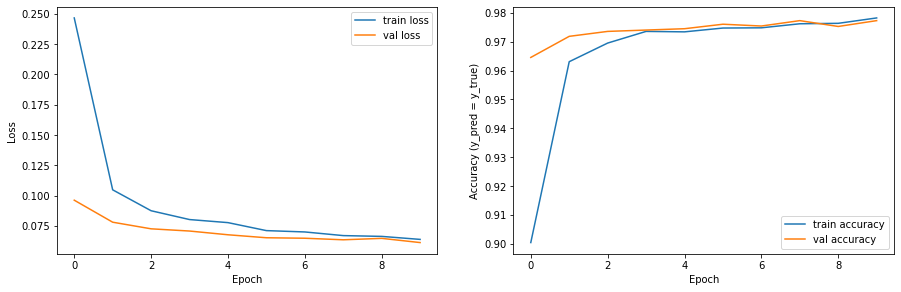

In [45]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [46]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

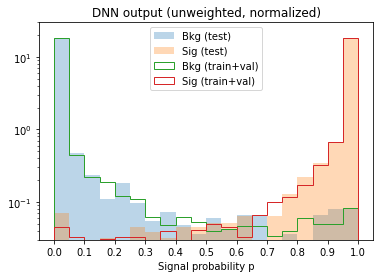

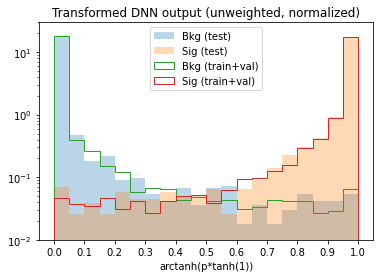

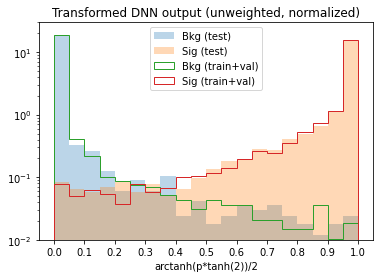

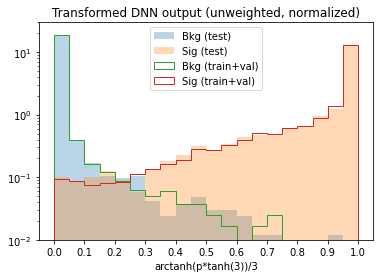

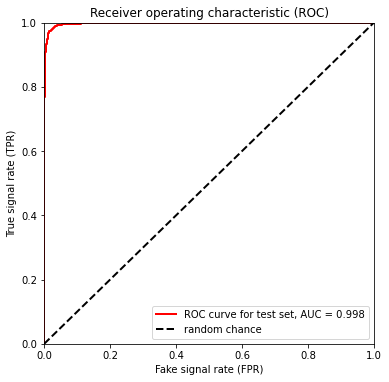

Test loss, test accuracy: [0.059219626071028, 0.9772974848747253]


In [47]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(3e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 20, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 128)
print("Test loss, test accuracy:", results)

## Save trained model

In [48]:
joblib.dump(scaler, 'trained_models_rerunBtag/mt2b_scaler.gz')
model.save('trained_models_rerunBtag/mt2b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models_rerunBtag/mt2b_scaler.gz')
savedmodel = keras.models.load_model('trained_models_rerunBtag/mt2b_model')
savedmodel.summary()

# Write model prediction to root files (NOW USE ANOTHER NOTEBOOK TO WRITE)

## Load all root files one by one

In [49]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/mt18_raw/'
outfolder18 = 'root_outputs/mt18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('mutau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/mt17_raw/'
outfolder17 = 'root_outputs/mt17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('mutau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/mt16_raw/'
outfolder16 = 'root_outputs/mt16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt15.root', 'gghbbtt20.root', 'gghbbtt25.root', 'gghbbtt30.root', 'gghbbtt35.root', 'gghbbtt40.root'\
         , 'gghbbtt45.root', 'gghbbtt50.root', 'gghbbtt55.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt15.root', 'vbfbbtt20.root', 'vbfbbtt25.root', 'vbfbbtt30.root', 'vbfbbtt35.root', 'vbfbbtt40.root'\
         , 'vbfbbtt45.root', 'vbfbbtt50.root', 'vbfbbtt55.root', 'vbfbbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('mutau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbmu', m_bbmu)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [50]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

root_raw/mt18_raw/DY.root
root_raw/mt18_raw/DY1.root
root_raw/mt18_raw/DY2.root
root_raw/mt18_raw/DY3.root
root_raw/mt18_raw/DY4.root
root_raw/mt18_raw/GGHTT.root
root_raw/mt18_raw/GGHWW.root
root_raw/mt18_raw/GGZHLLTT.root
root_raw/mt18_raw/GGZHNNTT.root
root_raw/mt18_raw/GGZHQQTT.root
root_raw/mt18_raw/GGZHWW.root
root_raw/mt18_raw/ST_tW_antitop.root
root_raw/mt18_raw/ST_tW_top.root
root_raw/mt18_raw/ST_t_antitop.root
root_raw/mt18_raw/ST_t_top.root
root_raw/mt18_raw/TTTo2L2Nu.root
root_raw/mt18_raw/TTToHadronic.root
root_raw/mt18_raw/TTToSemiLeptonic.root
root_raw/mt18_raw/VBFHTT.root
root_raw/mt18_raw/VBFHWW.root
root_raw/mt18_raw/VV2L2Nu.root
root_raw/mt18_raw/WZ2L2Q.root
root_raw/mt18_raw/WZ3LNu.root
root_raw/mt18_raw/WminusHTT.root
root_raw/mt18_raw/WminusHWW.root
root_raw/mt18_raw/WplusHTT.root
root_raw/mt18_raw/WplusHWW.root
root_raw/mt18_raw/ZHTT.root
root_raw/mt18_raw/ZHWW.root
root_raw/mt18_raw/ZZ2L2Q.root
root_raw/mt18_raw/ZZ4L.root
root_raw/mt18_raw/data_obs.root
root_raw

In [52]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

root_raw/mt17_raw/DY.root
root_raw/mt17_raw/DY1.root
root_raw/mt17_raw/DY2.root
root_raw/mt17_raw/DY3.root
root_raw/mt17_raw/DY4.root
root_raw/mt17_raw/GGHTT.root
root_raw/mt17_raw/GGHWW.root
root_raw/mt17_raw/GGZHLLTT.root
root_raw/mt17_raw/GGZHNNTT.root
root_raw/mt17_raw/GGZHQQTT.root
root_raw/mt17_raw/GGZHWW.root
root_raw/mt17_raw/ST_tW_antitop.root
root_raw/mt17_raw/ST_tW_top.root
root_raw/mt17_raw/ST_t_antitop.root
root_raw/mt17_raw/ST_t_top.root
root_raw/mt17_raw/TTTo2L2Nu.root
root_raw/mt17_raw/TTToHadronic.root
root_raw/mt17_raw/TTToSemiLeptonic.root
root_raw/mt17_raw/VBFHTT.root
root_raw/mt17_raw/VBFHWW.root
root_raw/mt17_raw/VV2L2Nu.root
root_raw/mt17_raw/WZ2L2Q.root
root_raw/mt17_raw/WZ3L1Nu.root
root_raw/mt17_raw/WminusHTT.root
root_raw/mt17_raw/WminusHWW.root
root_raw/mt17_raw/WplusHTT.root
root_raw/mt17_raw/WplusHWW.root
root_raw/mt17_raw/ZHTT.root
root_raw/mt17_raw/ZHWW.root
root_raw/mt17_raw/ZZ2L2Q.root
root_raw/mt17_raw/ZZ4L.root
root_raw/mt17_raw/data_obs.root
root_ra

In [54]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

root_raw/mt16_raw/DY.root
root_raw/mt16_raw/DY1.root
root_raw/mt16_raw/DY2.root
root_raw/mt16_raw/DY3.root
root_raw/mt16_raw/DY4.root
root_raw/mt16_raw/GGHTT.root
root_raw/mt16_raw/GGHWW.root
root_raw/mt16_raw/GGZHLLTT.root
root_raw/mt16_raw/GGZHNNTT.root
root_raw/mt16_raw/GGZHQQTT.root
root_raw/mt16_raw/GGZHWW.root
root_raw/mt16_raw/ST_tW_antitop.root
root_raw/mt16_raw/ST_tW_top.root
root_raw/mt16_raw/ST_t_antitop.root
root_raw/mt16_raw/ST_t_top.root
root_raw/mt16_raw/TT.root
root_raw/mt16_raw/VBFHTT.root
root_raw/mt16_raw/VBFHWW.root
root_raw/mt16_raw/VV2L2Nu.root
root_raw/mt16_raw/WZ2L2Q.root
root_raw/mt16_raw/WZ3L1Nu.root
root_raw/mt16_raw/WminusHTT.root
root_raw/mt16_raw/WminusHWW.root
root_raw/mt16_raw/WplusHTT.root
root_raw/mt16_raw/WplusHWW.root
root_raw/mt16_raw/ZHTT.root
root_raw/mt16_raw/ZHWW.root
root_raw/mt16_raw/ZZ2L2Q.root
root_raw/mt16_raw/ZZ4L.root
root_raw/mt16_raw/data_obs.root
root_raw/mt16_raw/embedded.root
root_raw/mt16_raw/ggH_bbtt15.root
root_raw/mt16_raw/ggH_bb

## Feed to NN and write outputs to root files

In [51]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths18[i])

root_outputs/mt18_outputs/DY.root
root_outputs/mt18_outputs/DY1.root
root_outputs/mt18_outputs/DY2.root
root_outputs/mt18_outputs/DY3.root
root_outputs/mt18_outputs/DY4.root
root_outputs/mt18_outputs/GGHTT.root
root_outputs/mt18_outputs/GGHWW.root
root_outputs/mt18_outputs/GGZHLLTT.root
root_outputs/mt18_outputs/GGZHNNTT.root
root_outputs/mt18_outputs/GGZHQQTT.root
root_outputs/mt18_outputs/GGZHWW.root
root_outputs/mt18_outputs/ST_tW_antitop.root
root_outputs/mt18_outputs/ST_tW_top.root
root_outputs/mt18_outputs/ST_t_antitop.root
root_outputs/mt18_outputs/ST_t_top.root
root_outputs/mt18_outputs/TTTo2L2Nu.root
root_outputs/mt18_outputs/TTToHadronic.root
root_outputs/mt18_outputs/TTToSemiLeptonic.root
root_outputs/mt18_outputs/VBFHTT.root
root_outputs/mt18_outputs/VBFHWW.root
root_outputs/mt18_outputs/VV2L2Nu.root
root_outputs/mt18_outputs/WZ2L2Q.root
root_outputs/mt18_outputs/WZ3LNu.root
root_outputs/mt18_outputs/WminusHTT.root
root_outputs/mt18_outputs/WminusHWW.root
root_outputs/mt18_

In [53]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths17[i])

root_outputs/mt17_outputs/DY.root
root_outputs/mt17_outputs/DY1.root
root_outputs/mt17_outputs/DY2.root
root_outputs/mt17_outputs/DY3.root
root_outputs/mt17_outputs/DY4.root
root_outputs/mt17_outputs/GGHTT.root
root_outputs/mt17_outputs/GGHWW.root
root_outputs/mt17_outputs/GGZHLLTT.root
root_outputs/mt17_outputs/GGZHNNTT.root
root_outputs/mt17_outputs/GGZHQQTT.root
root_outputs/mt17_outputs/GGZHWW.root
root_outputs/mt17_outputs/ST_tW_antitop.root
root_outputs/mt17_outputs/ST_tW_top.root
root_outputs/mt17_outputs/ST_t_antitop.root
root_outputs/mt17_outputs/ST_t_top.root
root_outputs/mt17_outputs/TTTo2L2Nu.root
root_outputs/mt17_outputs/TTToHadronic.root
root_outputs/mt17_outputs/TTToSemiLeptonic.root
root_outputs/mt17_outputs/VBFHTT.root
root_outputs/mt17_outputs/VBFHWW.root
root_outputs/mt17_outputs/VV2L2Nu.root
root_outputs/mt17_outputs/WZ2L2Q.root
root_outputs/mt17_outputs/WZ3L1Nu.root
root_outputs/mt17_outputs/WminusHTT.root
root_outputs/mt17_outputs/WminusHWW.root
root_outputs/mt17

In [55]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths16[i])

root_outputs/mt16_outputs/DY.root
root_outputs/mt16_outputs/DY1.root
root_outputs/mt16_outputs/DY2.root
root_outputs/mt16_outputs/DY3.root
root_outputs/mt16_outputs/DY4.root
root_outputs/mt16_outputs/GGHTT.root
root_outputs/mt16_outputs/GGHWW.root
root_outputs/mt16_outputs/GGZHLLTT.root
root_outputs/mt16_outputs/GGZHNNTT.root
root_outputs/mt16_outputs/GGZHQQTT.root
root_outputs/mt16_outputs/GGZHWW.root
root_outputs/mt16_outputs/ST_tW_antitop.root
root_outputs/mt16_outputs/ST_tW_top.root
root_outputs/mt16_outputs/ST_t_antitop.root
root_outputs/mt16_outputs/ST_t_top.root
root_outputs/mt16_outputs/TT.root
root_outputs/mt16_outputs/VBFHTT.root
root_outputs/mt16_outputs/VBFHWW.root
root_outputs/mt16_outputs/VV2L2Nu.root
root_outputs/mt16_outputs/WZ2L2Q.root
root_outputs/mt16_outputs/WZ3L1Nu.root
root_outputs/mt16_outputs/WminusHTT.root
root_outputs/mt16_outputs/WminusHWW.root
root_outputs/mt16_outputs/WplusHTT.root
root_outputs/mt16_outputs/WplusHWW.root
root_outputs/mt16_outputs/ZHTT.root
